# Семинар 5. Метод опорных векторов. Калибровка вероятностей

### Простая задача двухклассовой классификации

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
# set default dpi
mpl.rcParams['figure.dpi'] = 300

**Разделимый случай**

Сгенерируем данные для задачи классификации

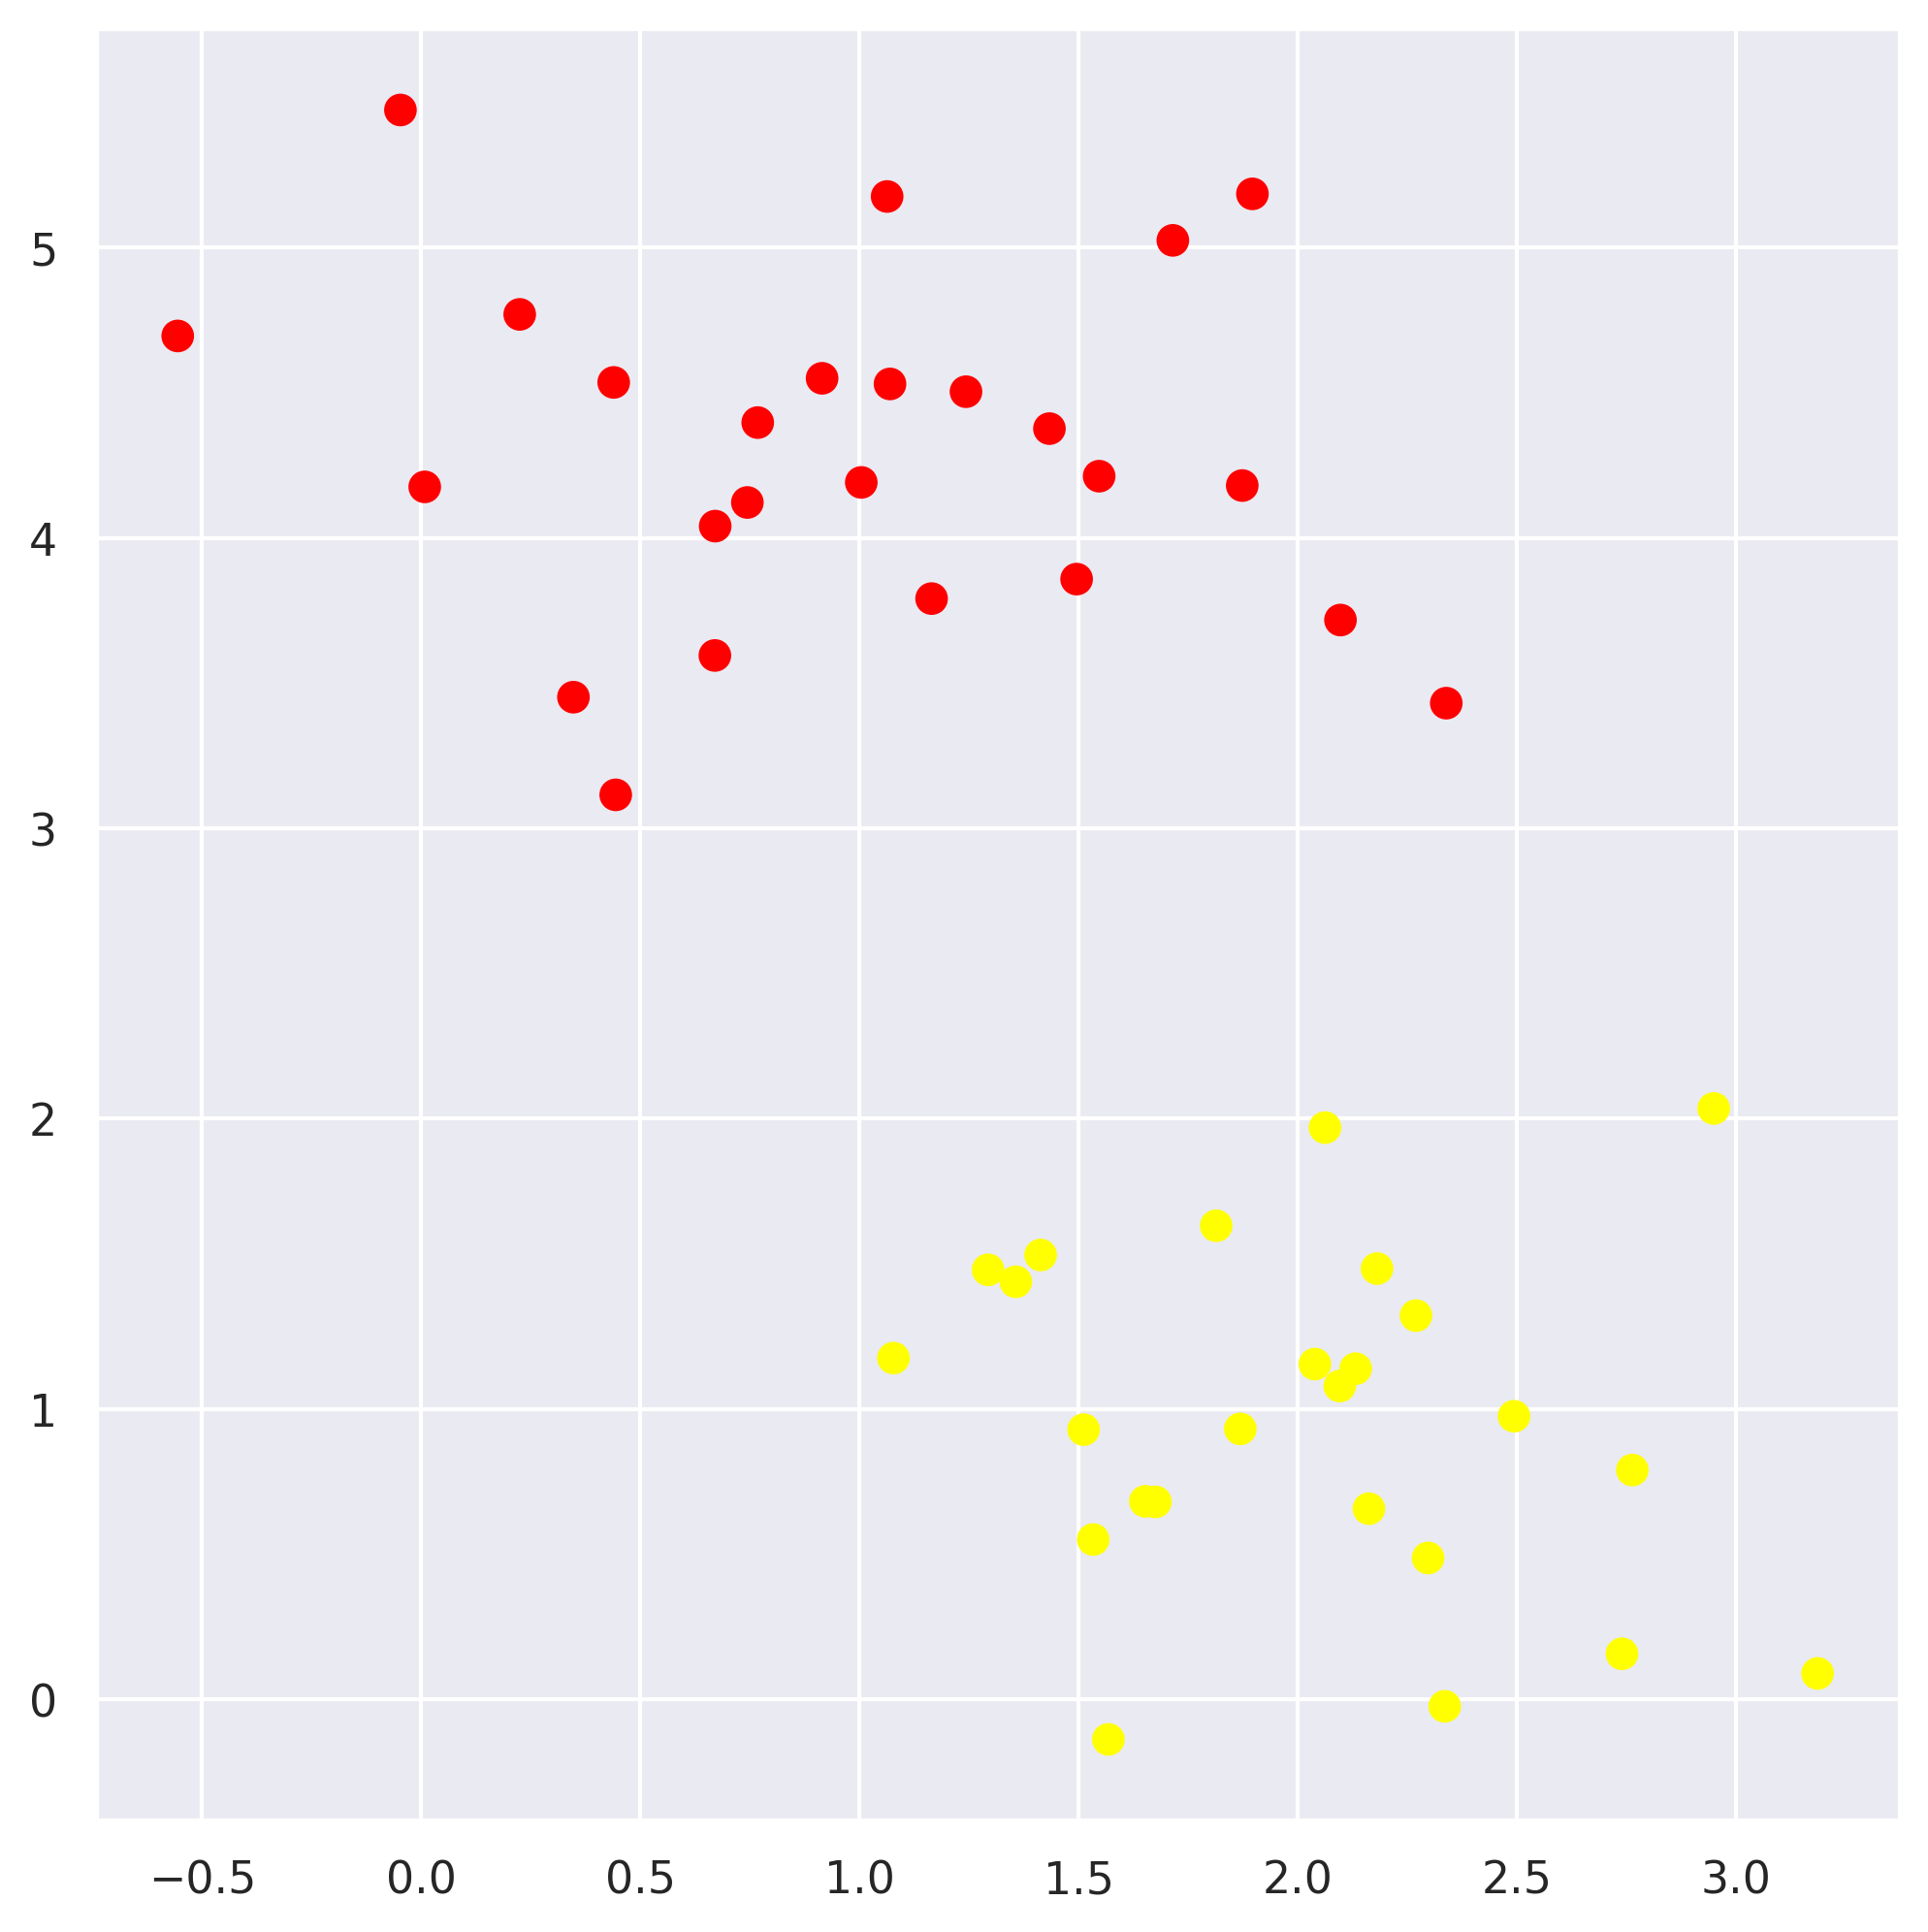

In [2]:
from sklearn.datasets import make_blobs

fig, ax = plt.subplots(figsize=(8, 8))
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

В случае линейно разделимой выборки существует бесконечно много классификаторов, решающих задачу без ошибок. Нарисуем несколько разделяющих поверхностей

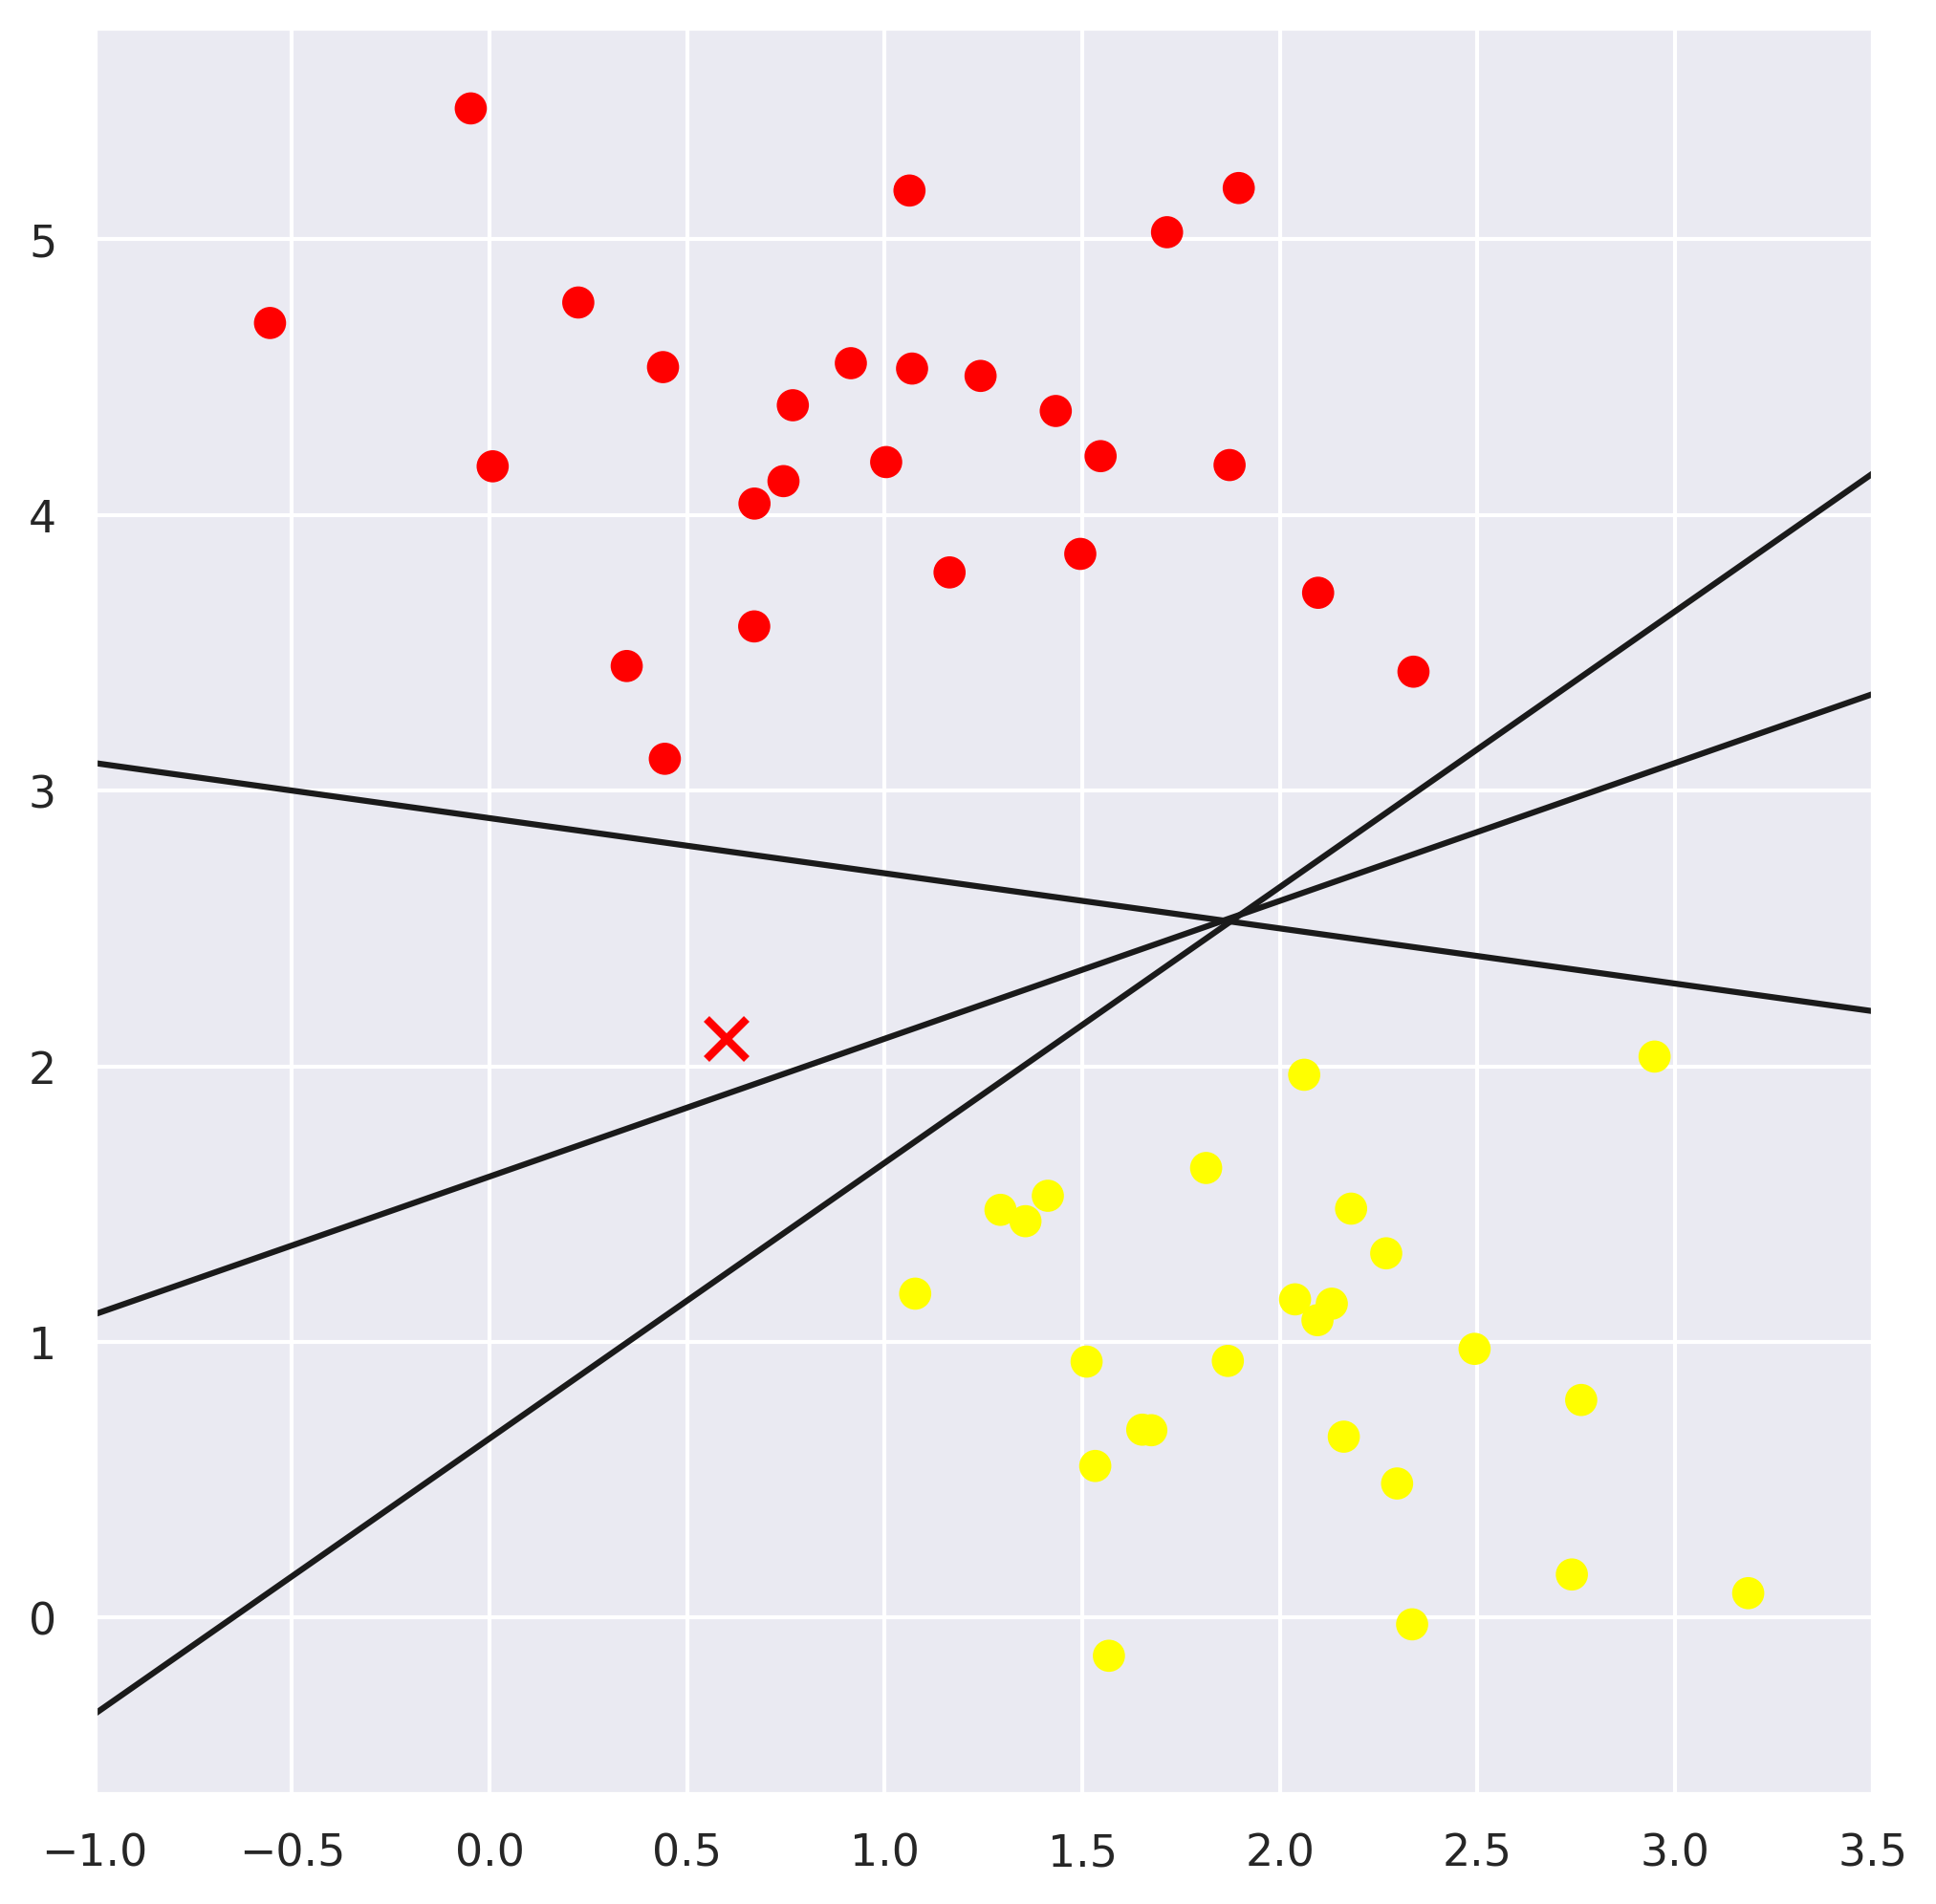

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

Нарисуем разделяющие поверхности вместе с разделяющими полосами

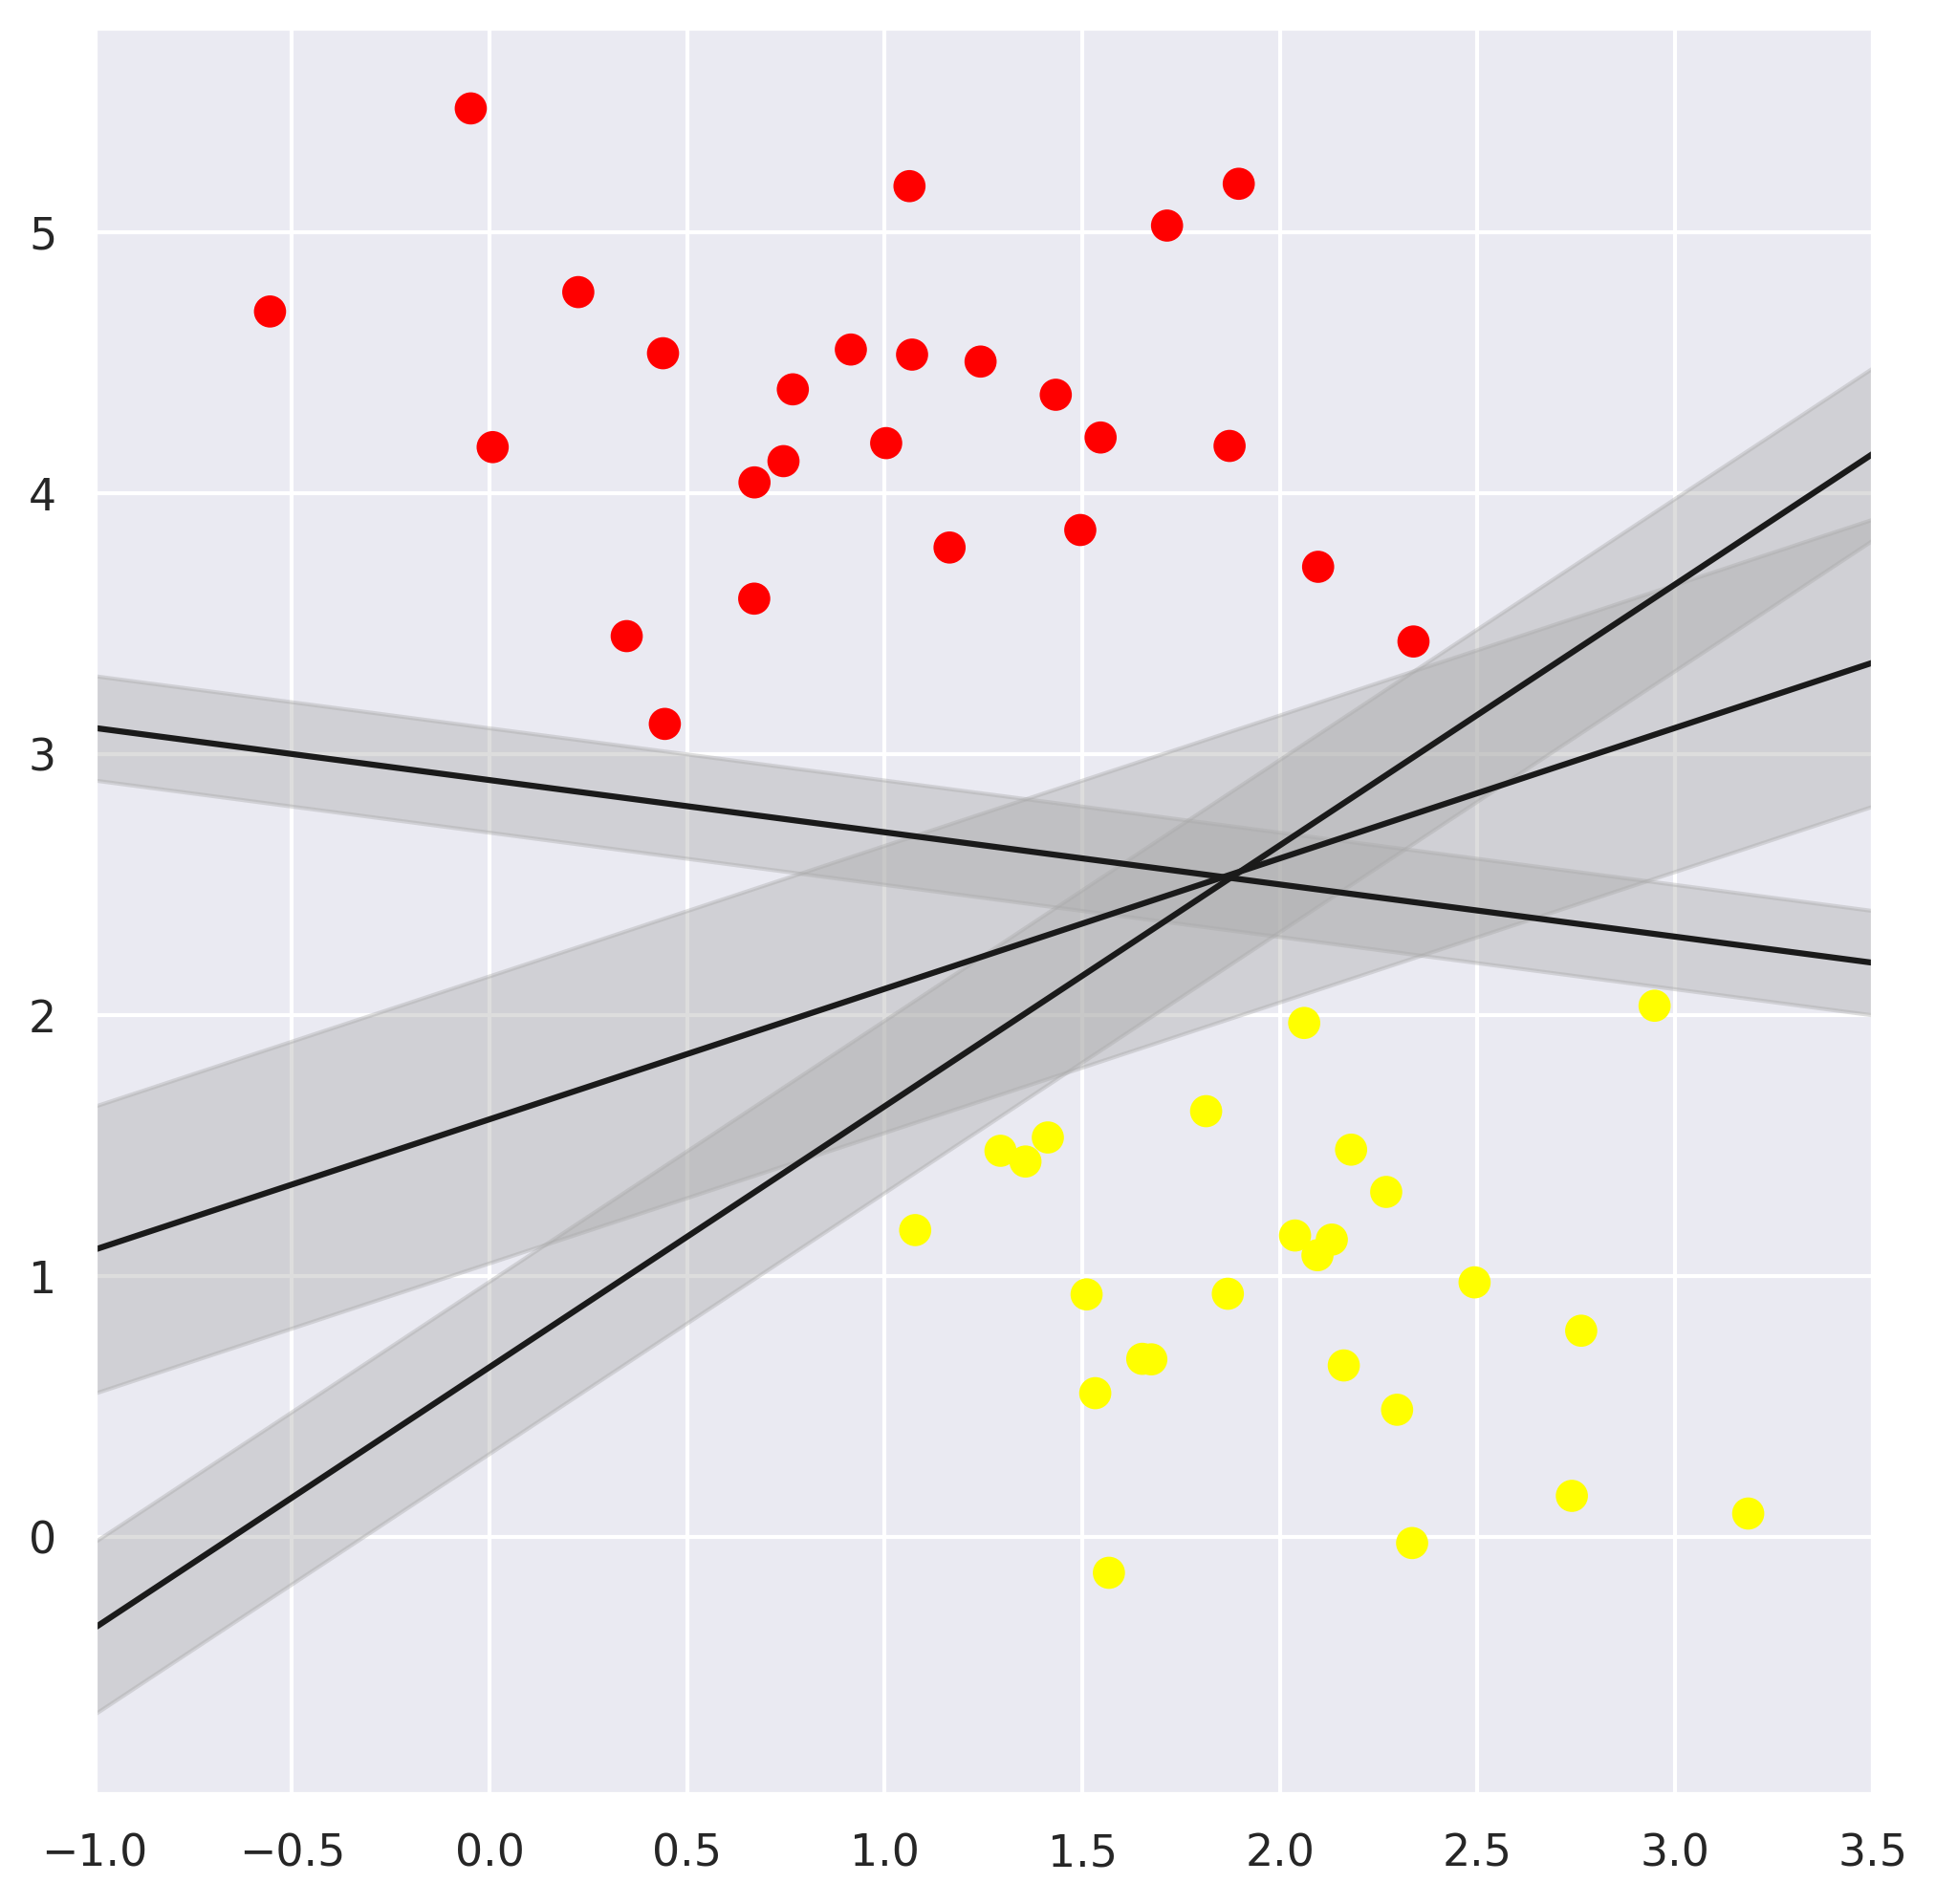

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)
plt.show()

Цель **метода опорных векторов** (support vector machine, SVM) $-$ максимизировать ширину разделяющей полосы $d$. Обучим SVM.

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Нами было задано линейное ядро и большой параметр регуляризации $C$ (то есть регуляризация почти отсутствует).

Создадим функцию <code><font color=blue>plot_svc_decision_function</font></code> для визуализации метода

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

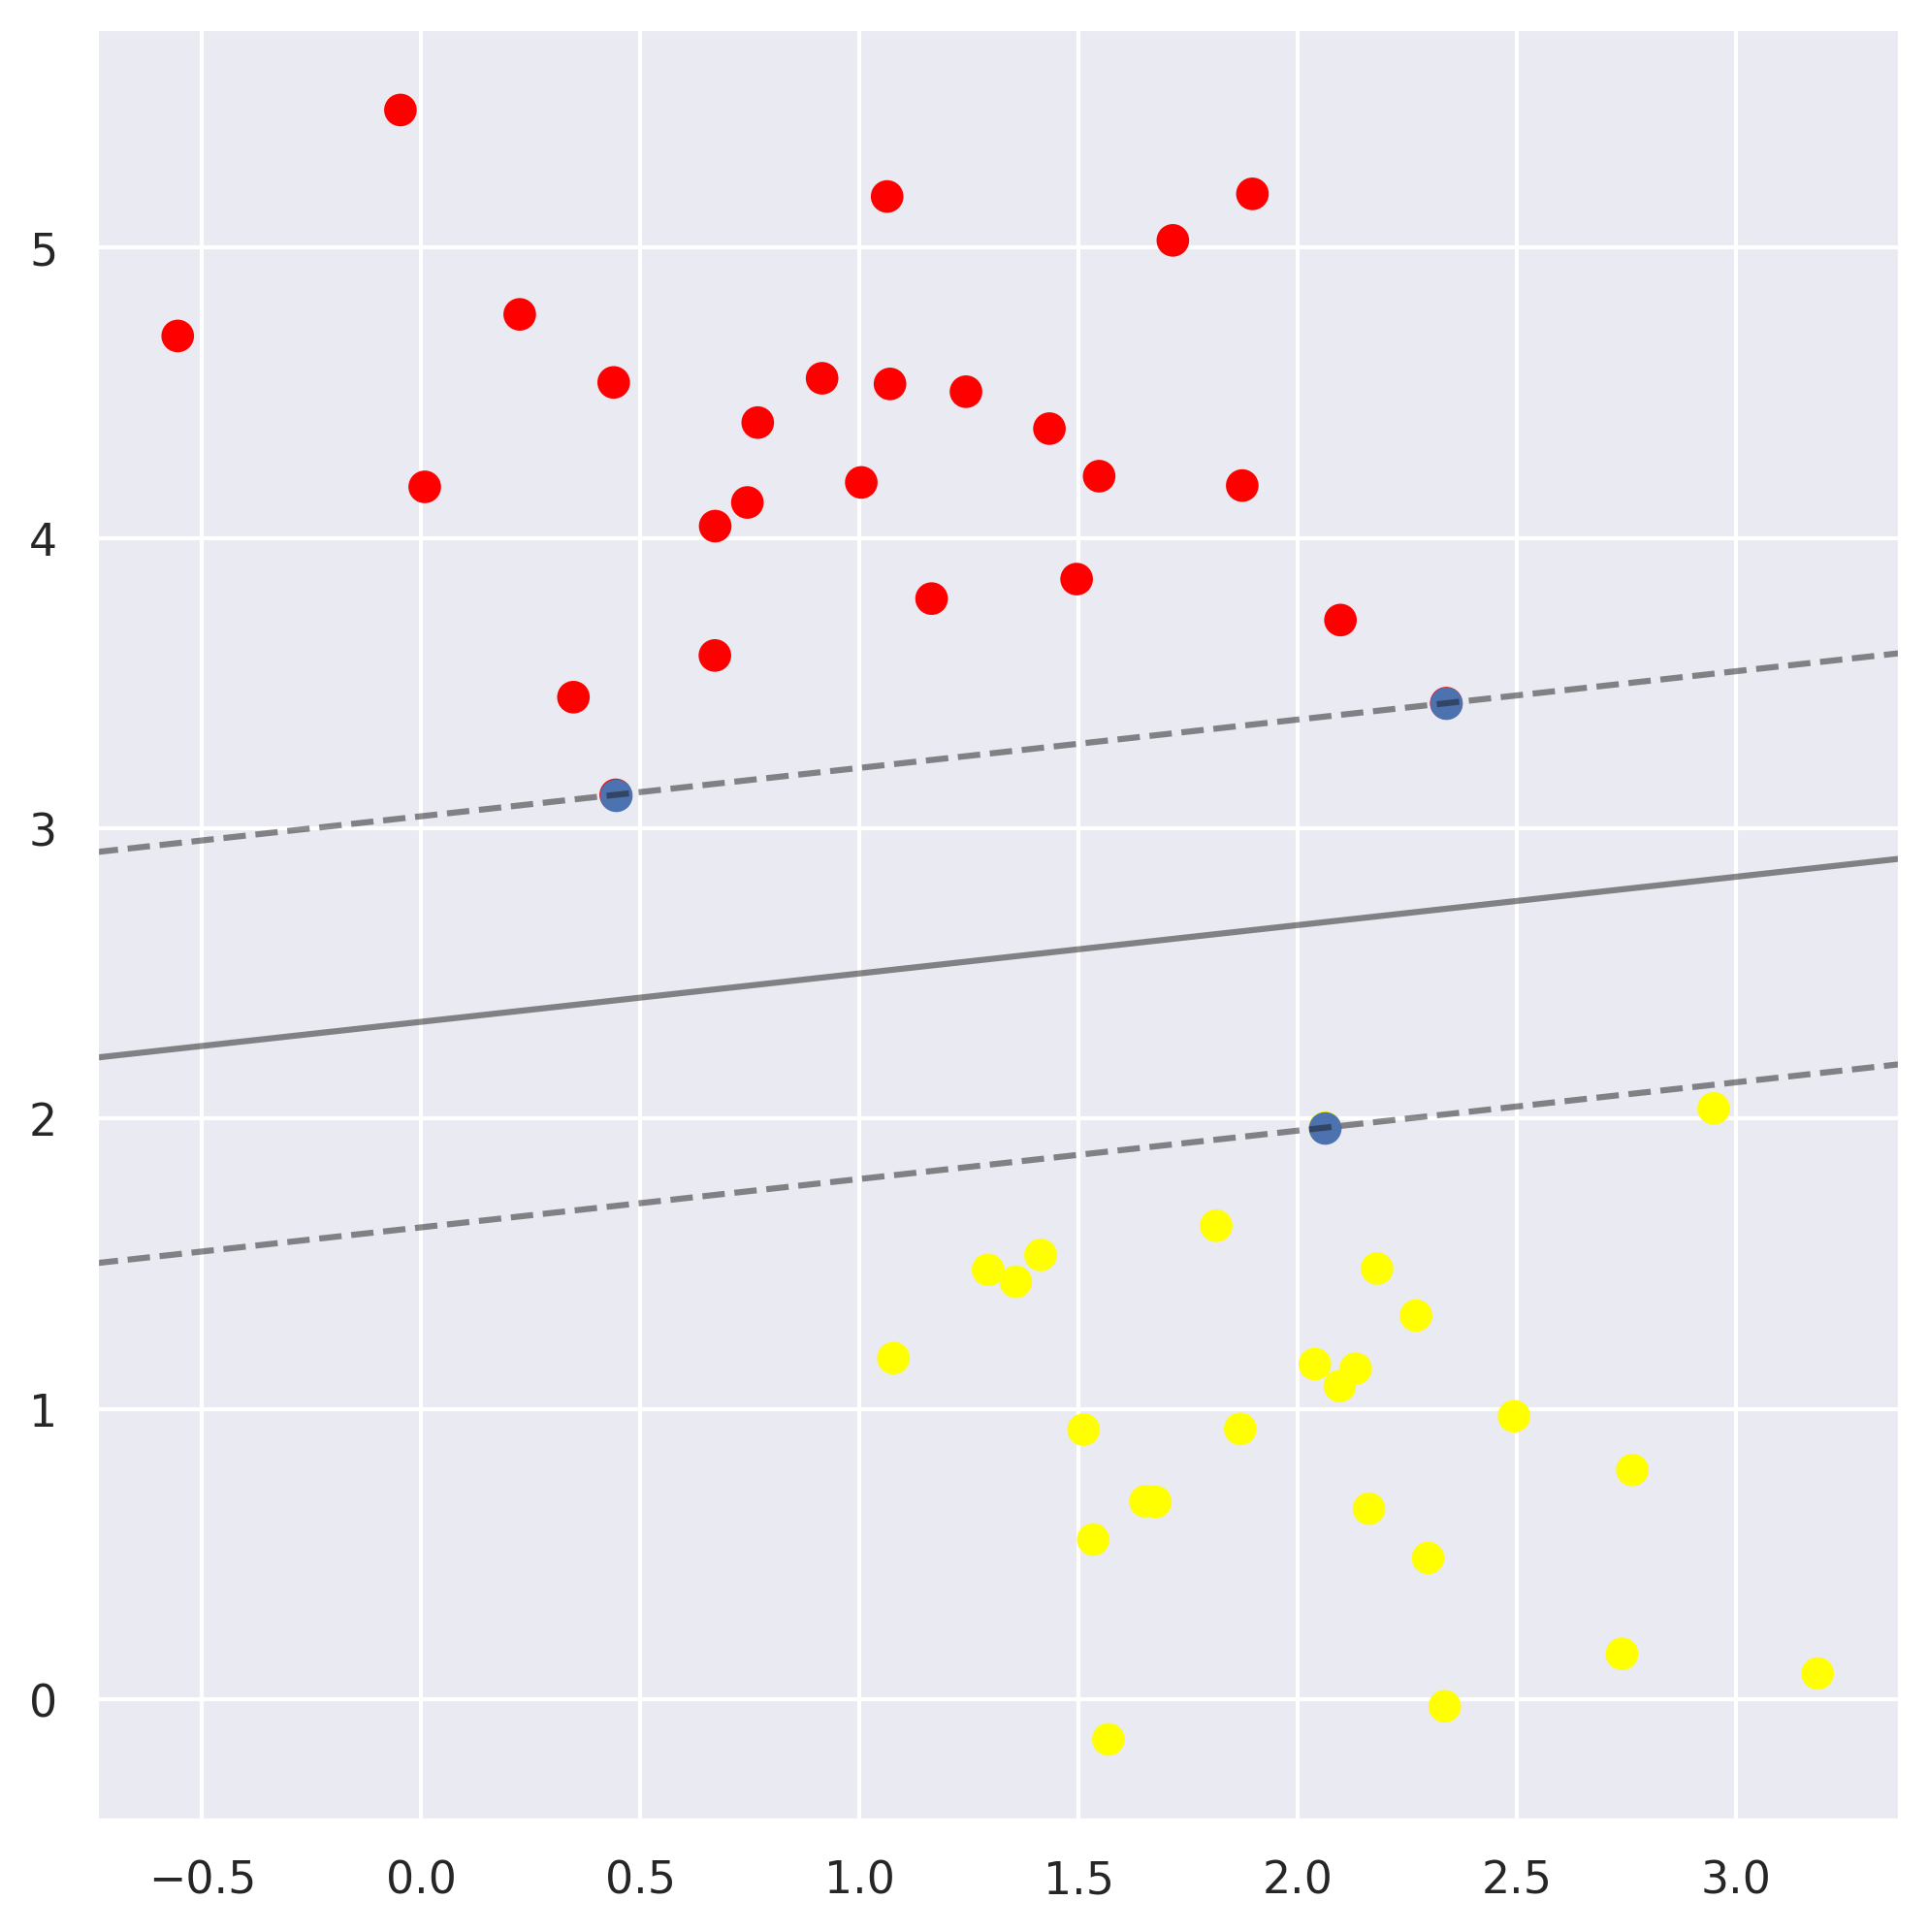

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)
plt.show()

Выведем опорные вектора, относительно которых была построена разделяющая гиперплоскость

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Для SVM важны только позиции опорных векторов!

Обучим метод на первых 10 точках, а затем на первых 500 точках.

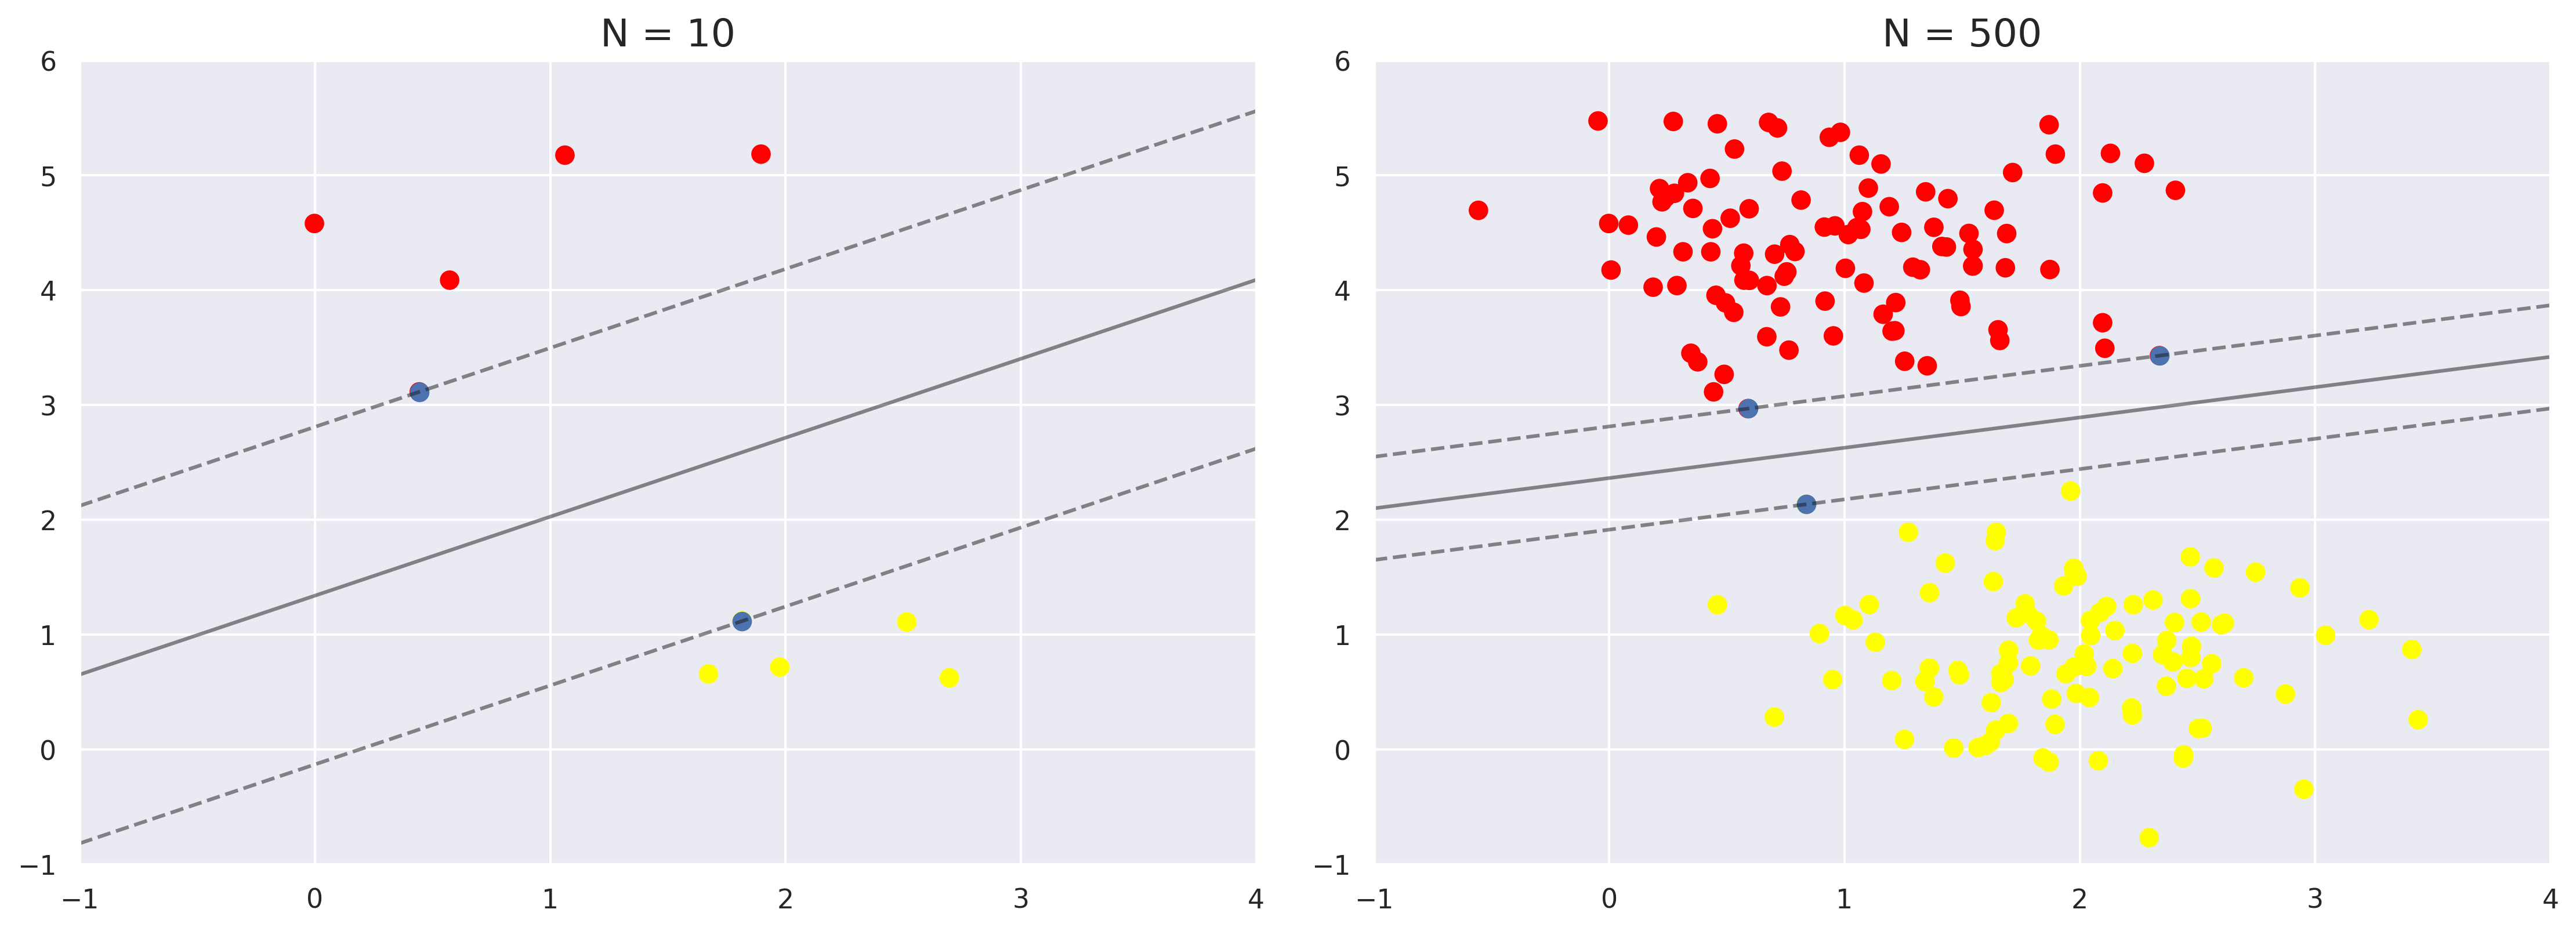

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [10, 500]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N), size=16)

Интерактивная визуализация SVM

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200, 1000], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200, 1000), value=10), Output()), _dom_c…

**Неразделимый случай**

С помощью функции <code>make_blobs</code> сгенерируйте выборку из 100 элементов для задачи двухклассовой классификации с частично пересекающимися классами.

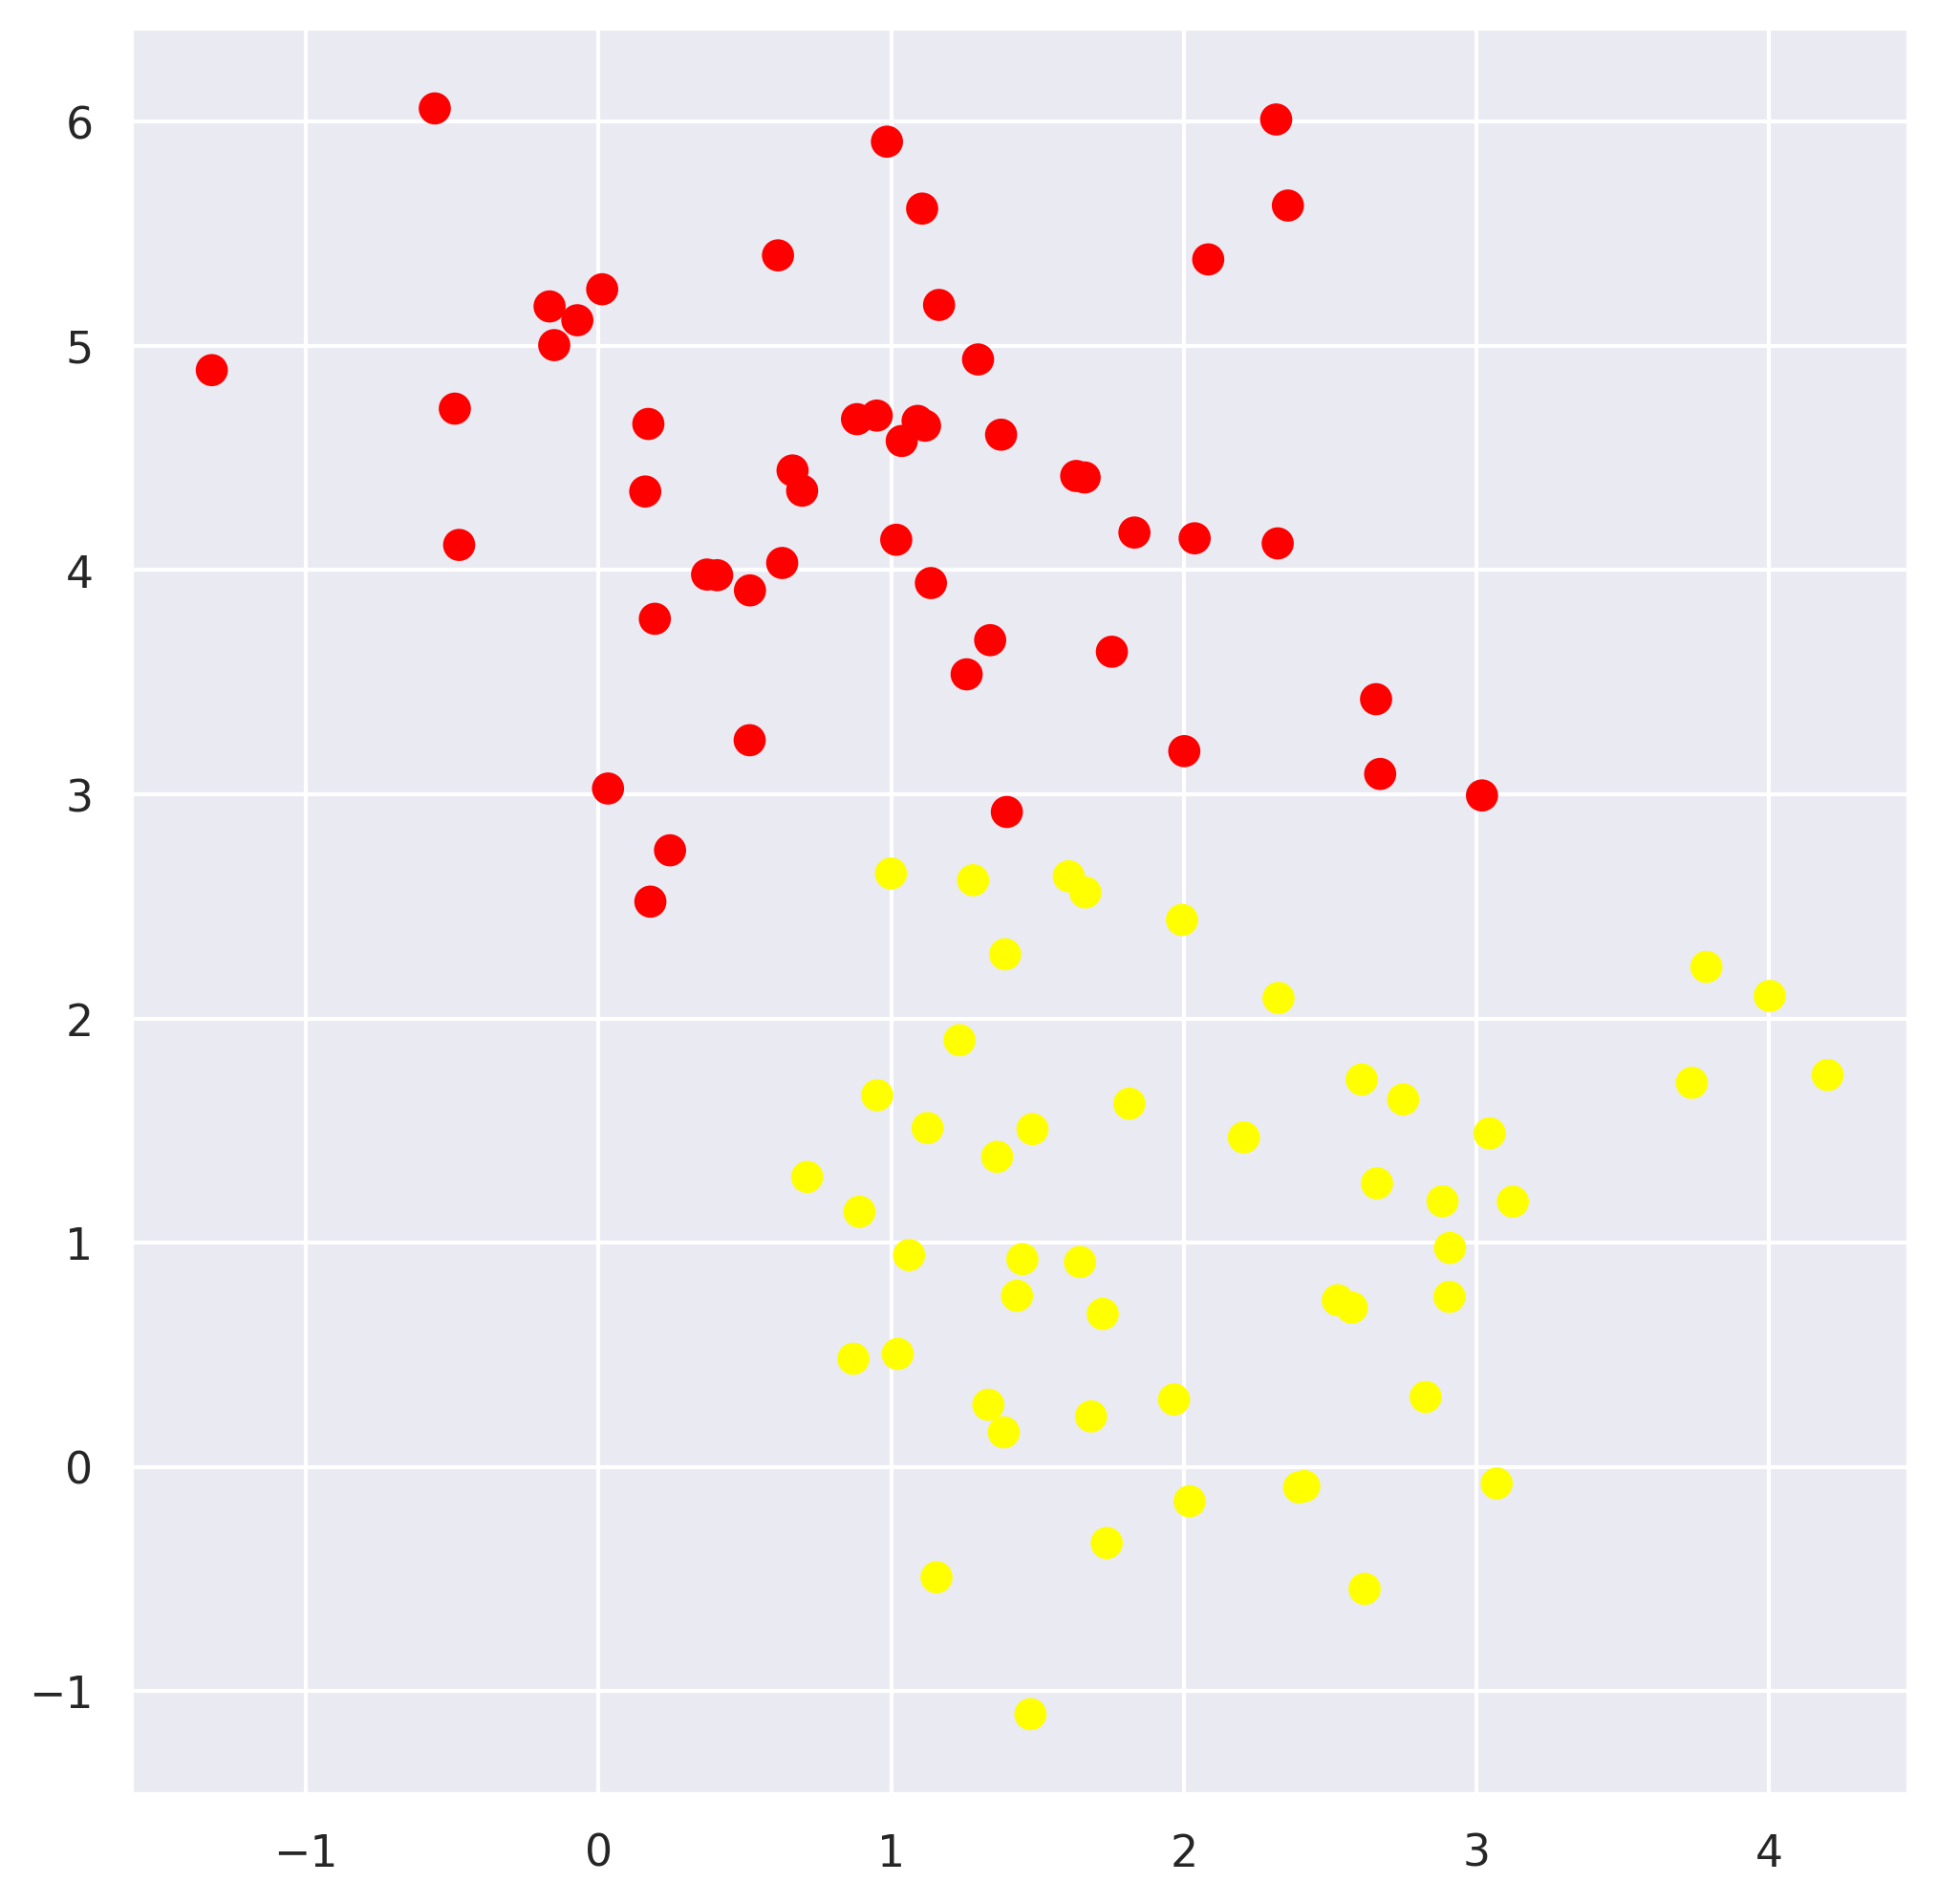

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.90)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

Посмотрим на результат работы SVM при различных значений параметра регуляризации $C$ на этих данных.

Обучим SVM с линейным ядром (<code>kernel='linear'</code>) и значением параметра $C$ равным значению переменной в цикле на этих данных

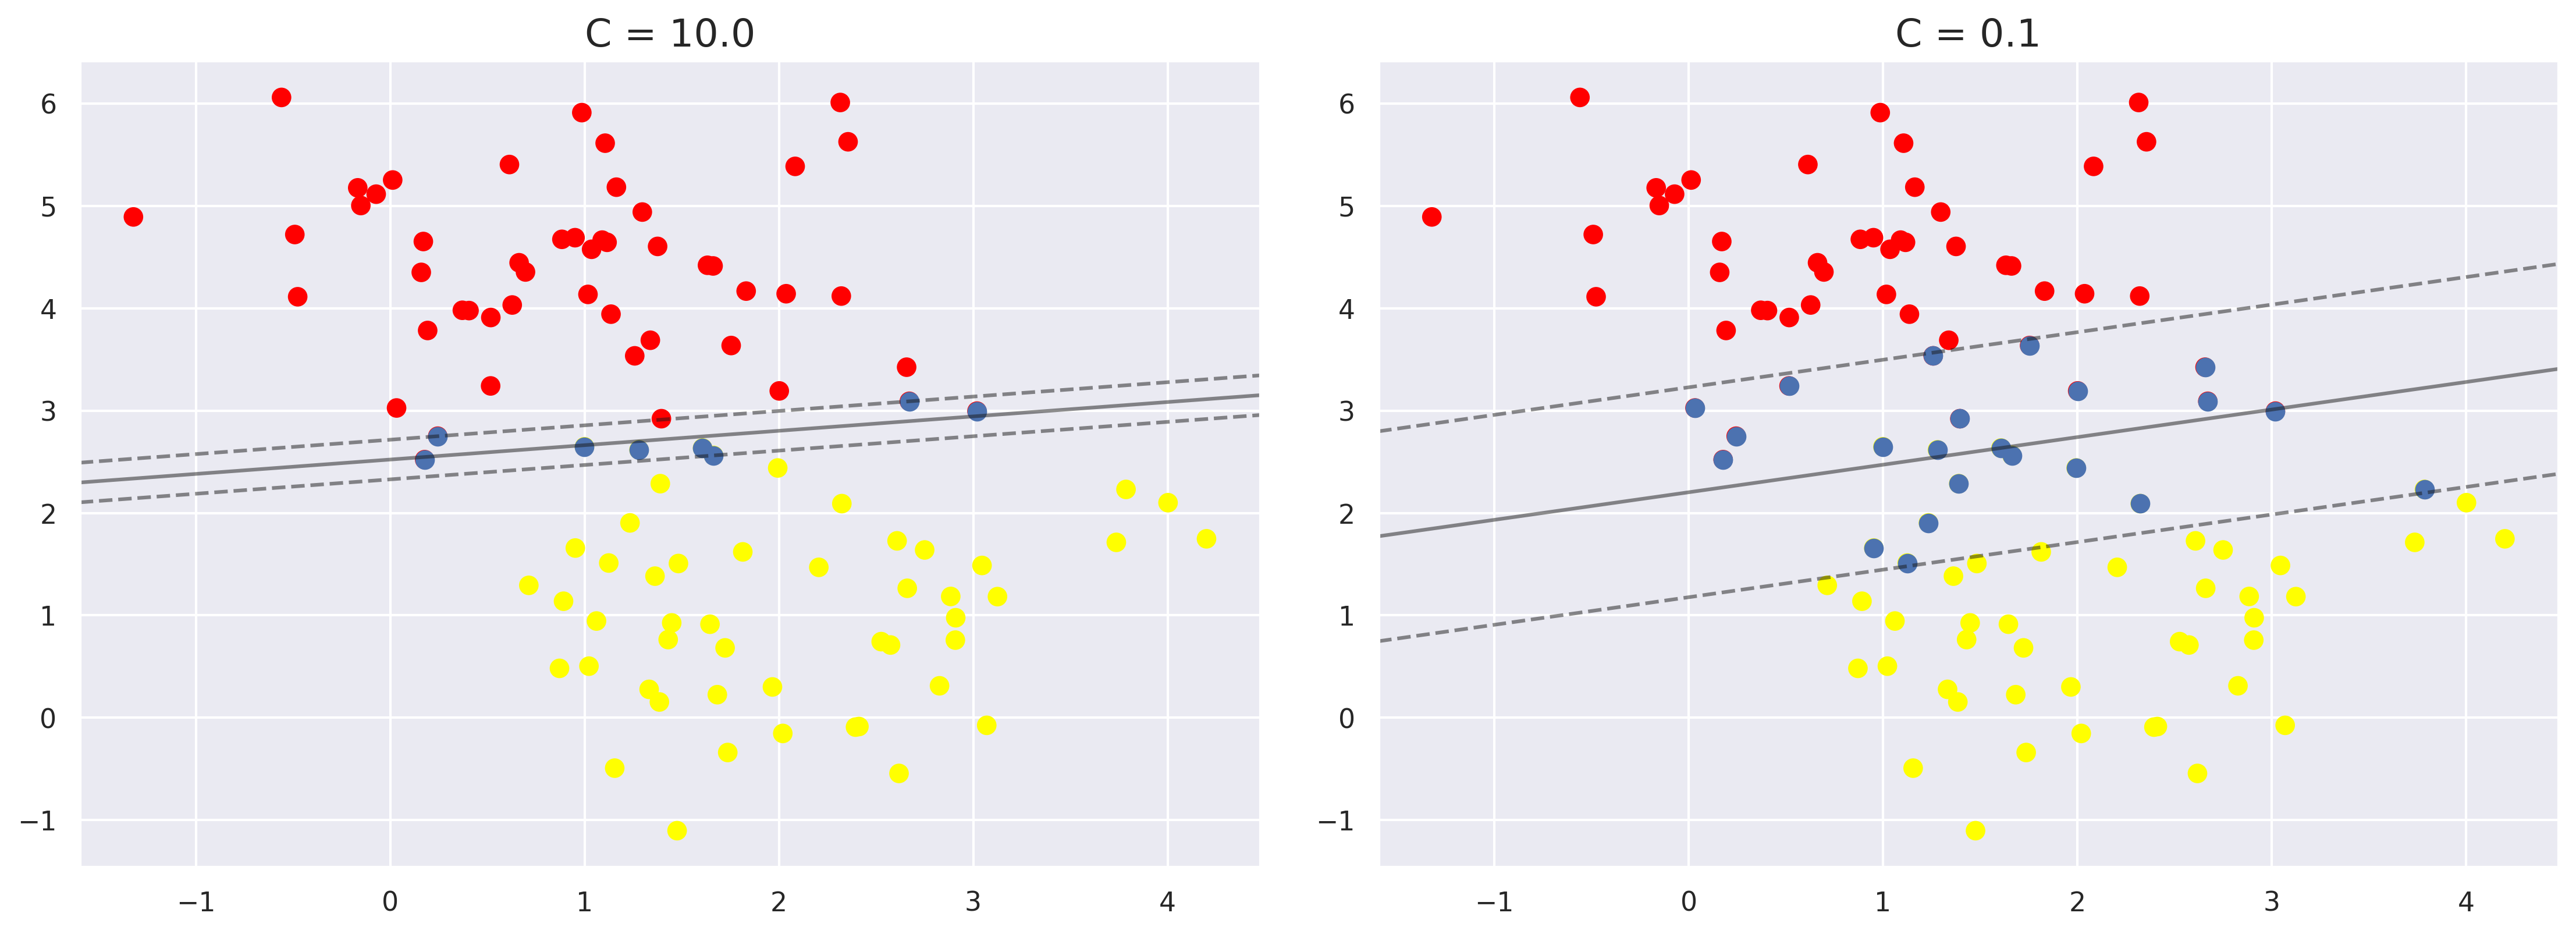

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, c in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=c)
    model.fit(X, y)
        
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(c), size=16)

Чем меньше значения параметра регуляризации $C$, тем больше точек попадает за пределы порога. Чем больше $C$, тем больше склонность модели к переобучению.

### Задача распознавания лиц

Решим задачу классификации лиц (задача многоклассовой классификации) с помощью метода опорных векторов

In [13]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Нарисуем несколько лиц из датасета

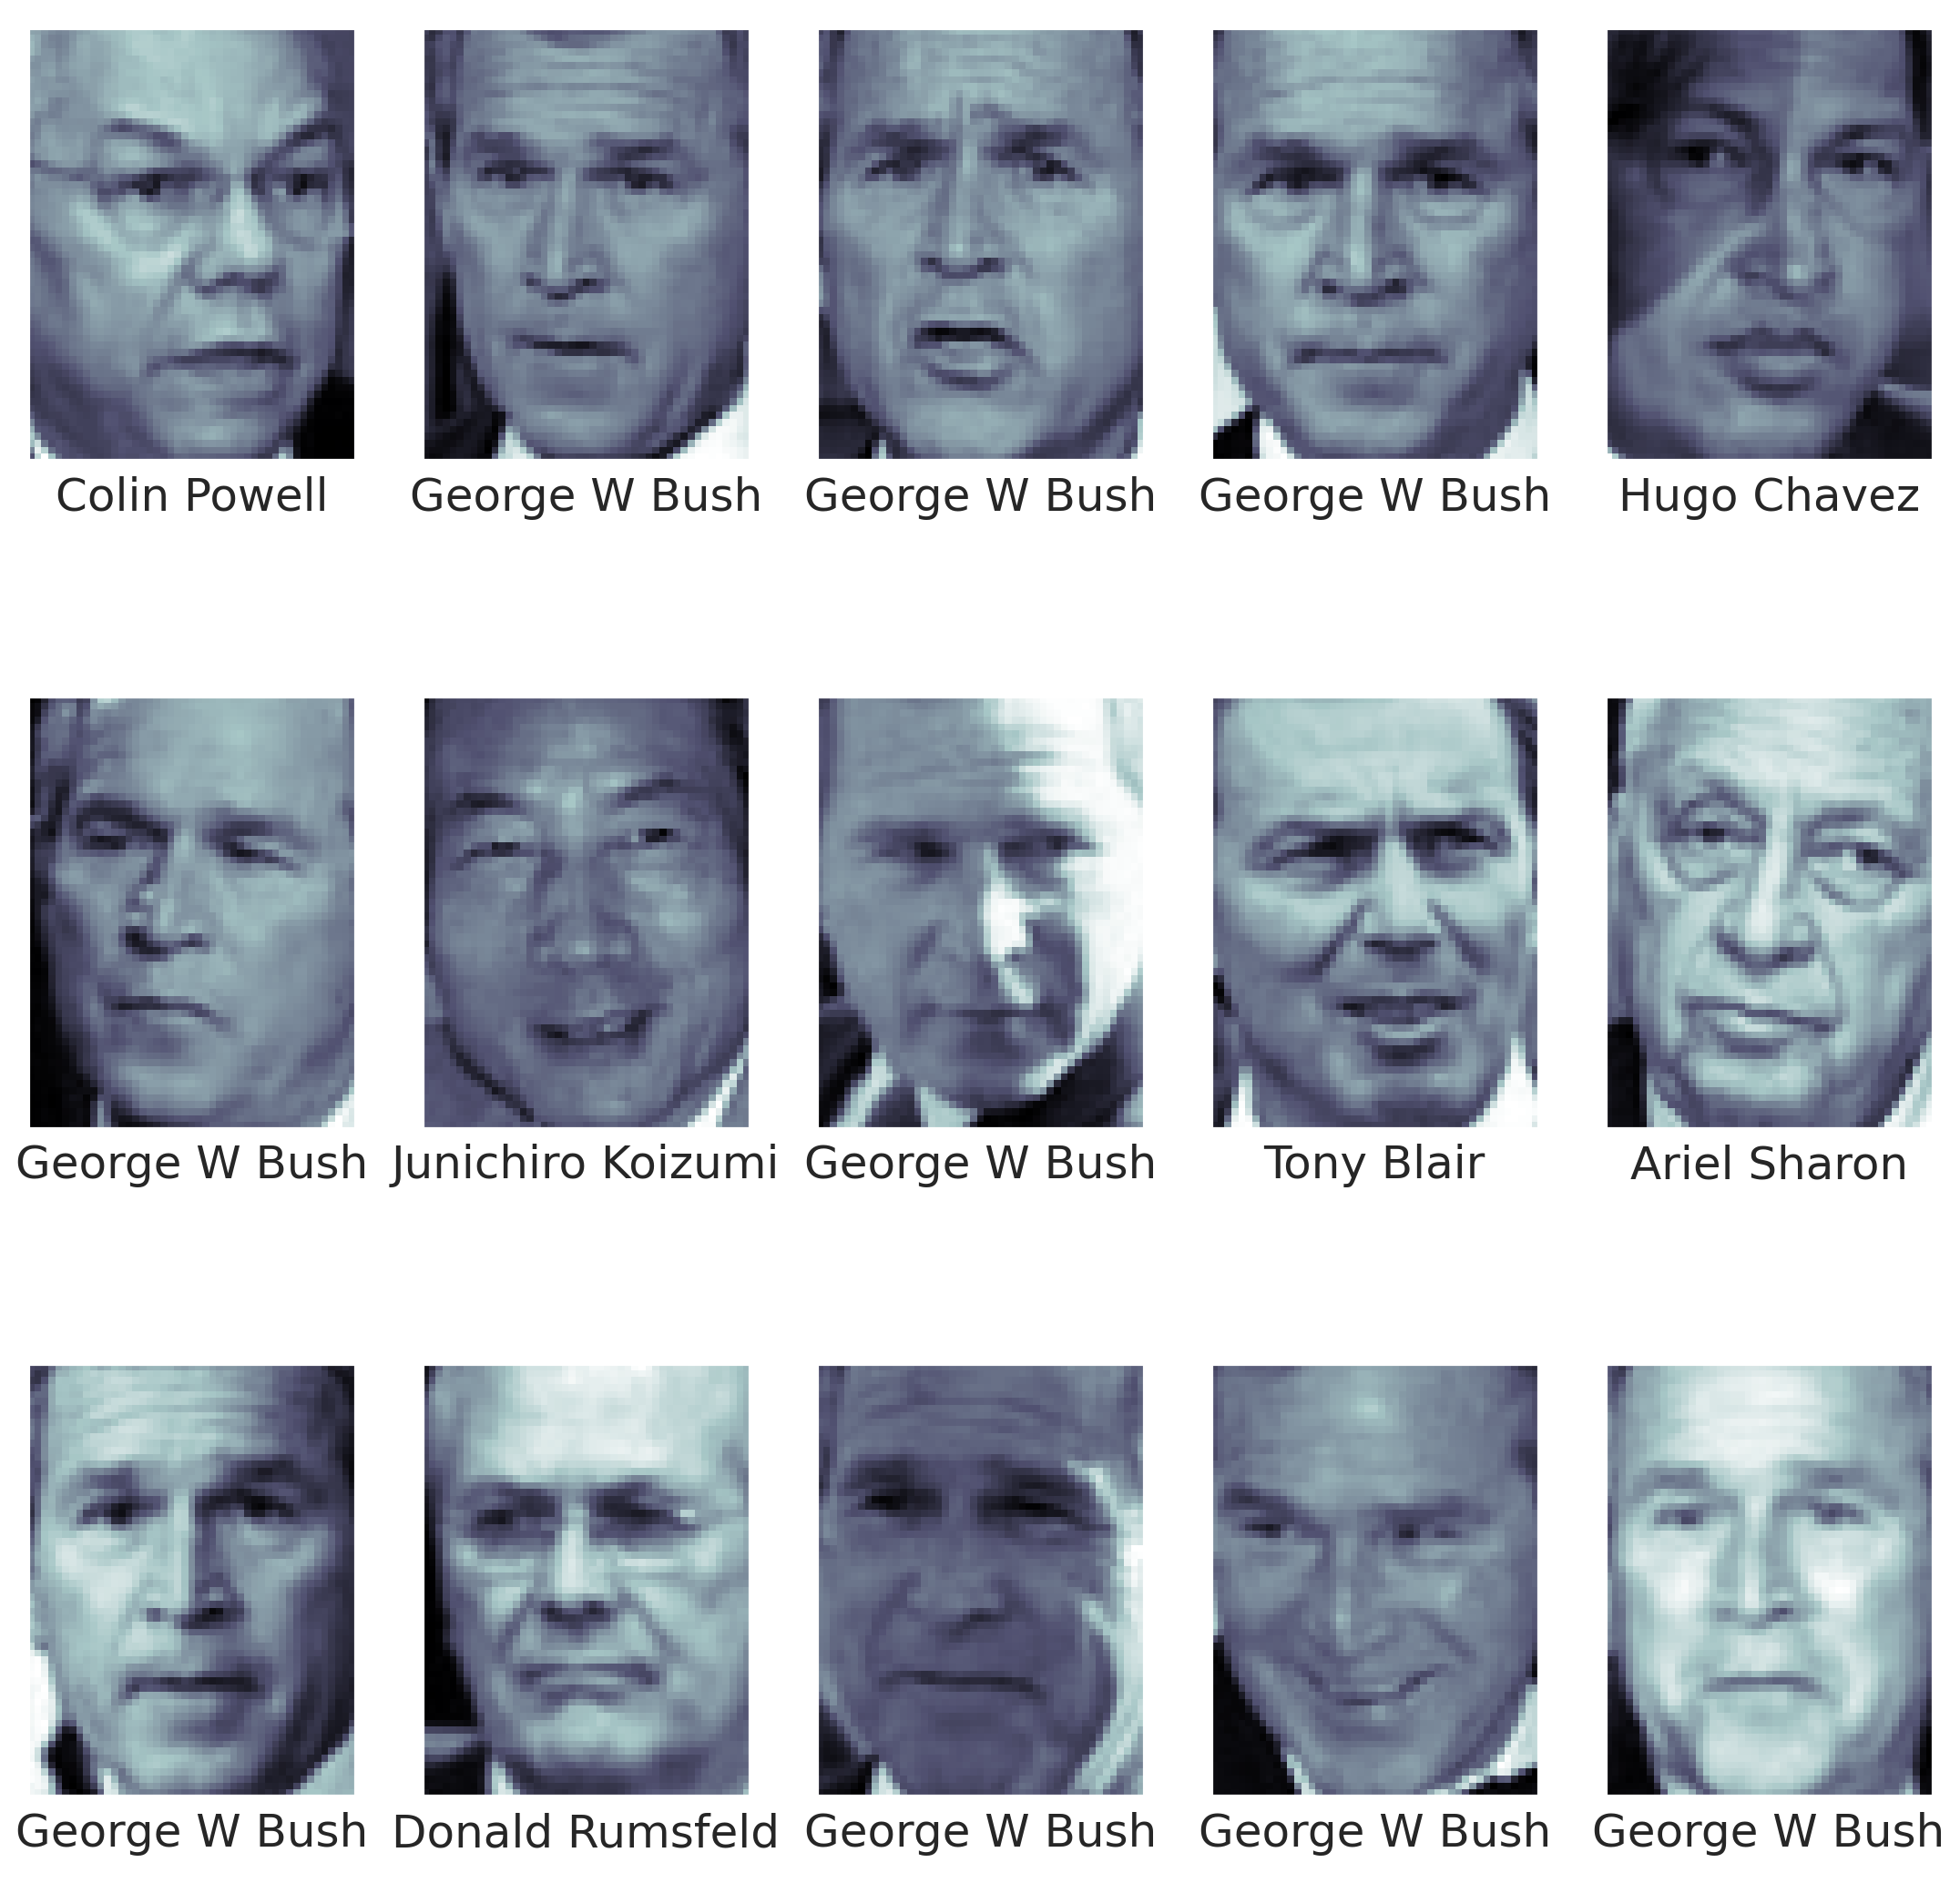

In [14]:
fig, ax = plt.subplots(3, 5, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Выведите на экран все фотографии Буша.

In [15]:
bush_faces = faces.images[faces.target == 3] # George W Bush

In [16]:
bush_faces.shape

(530, 62, 47)

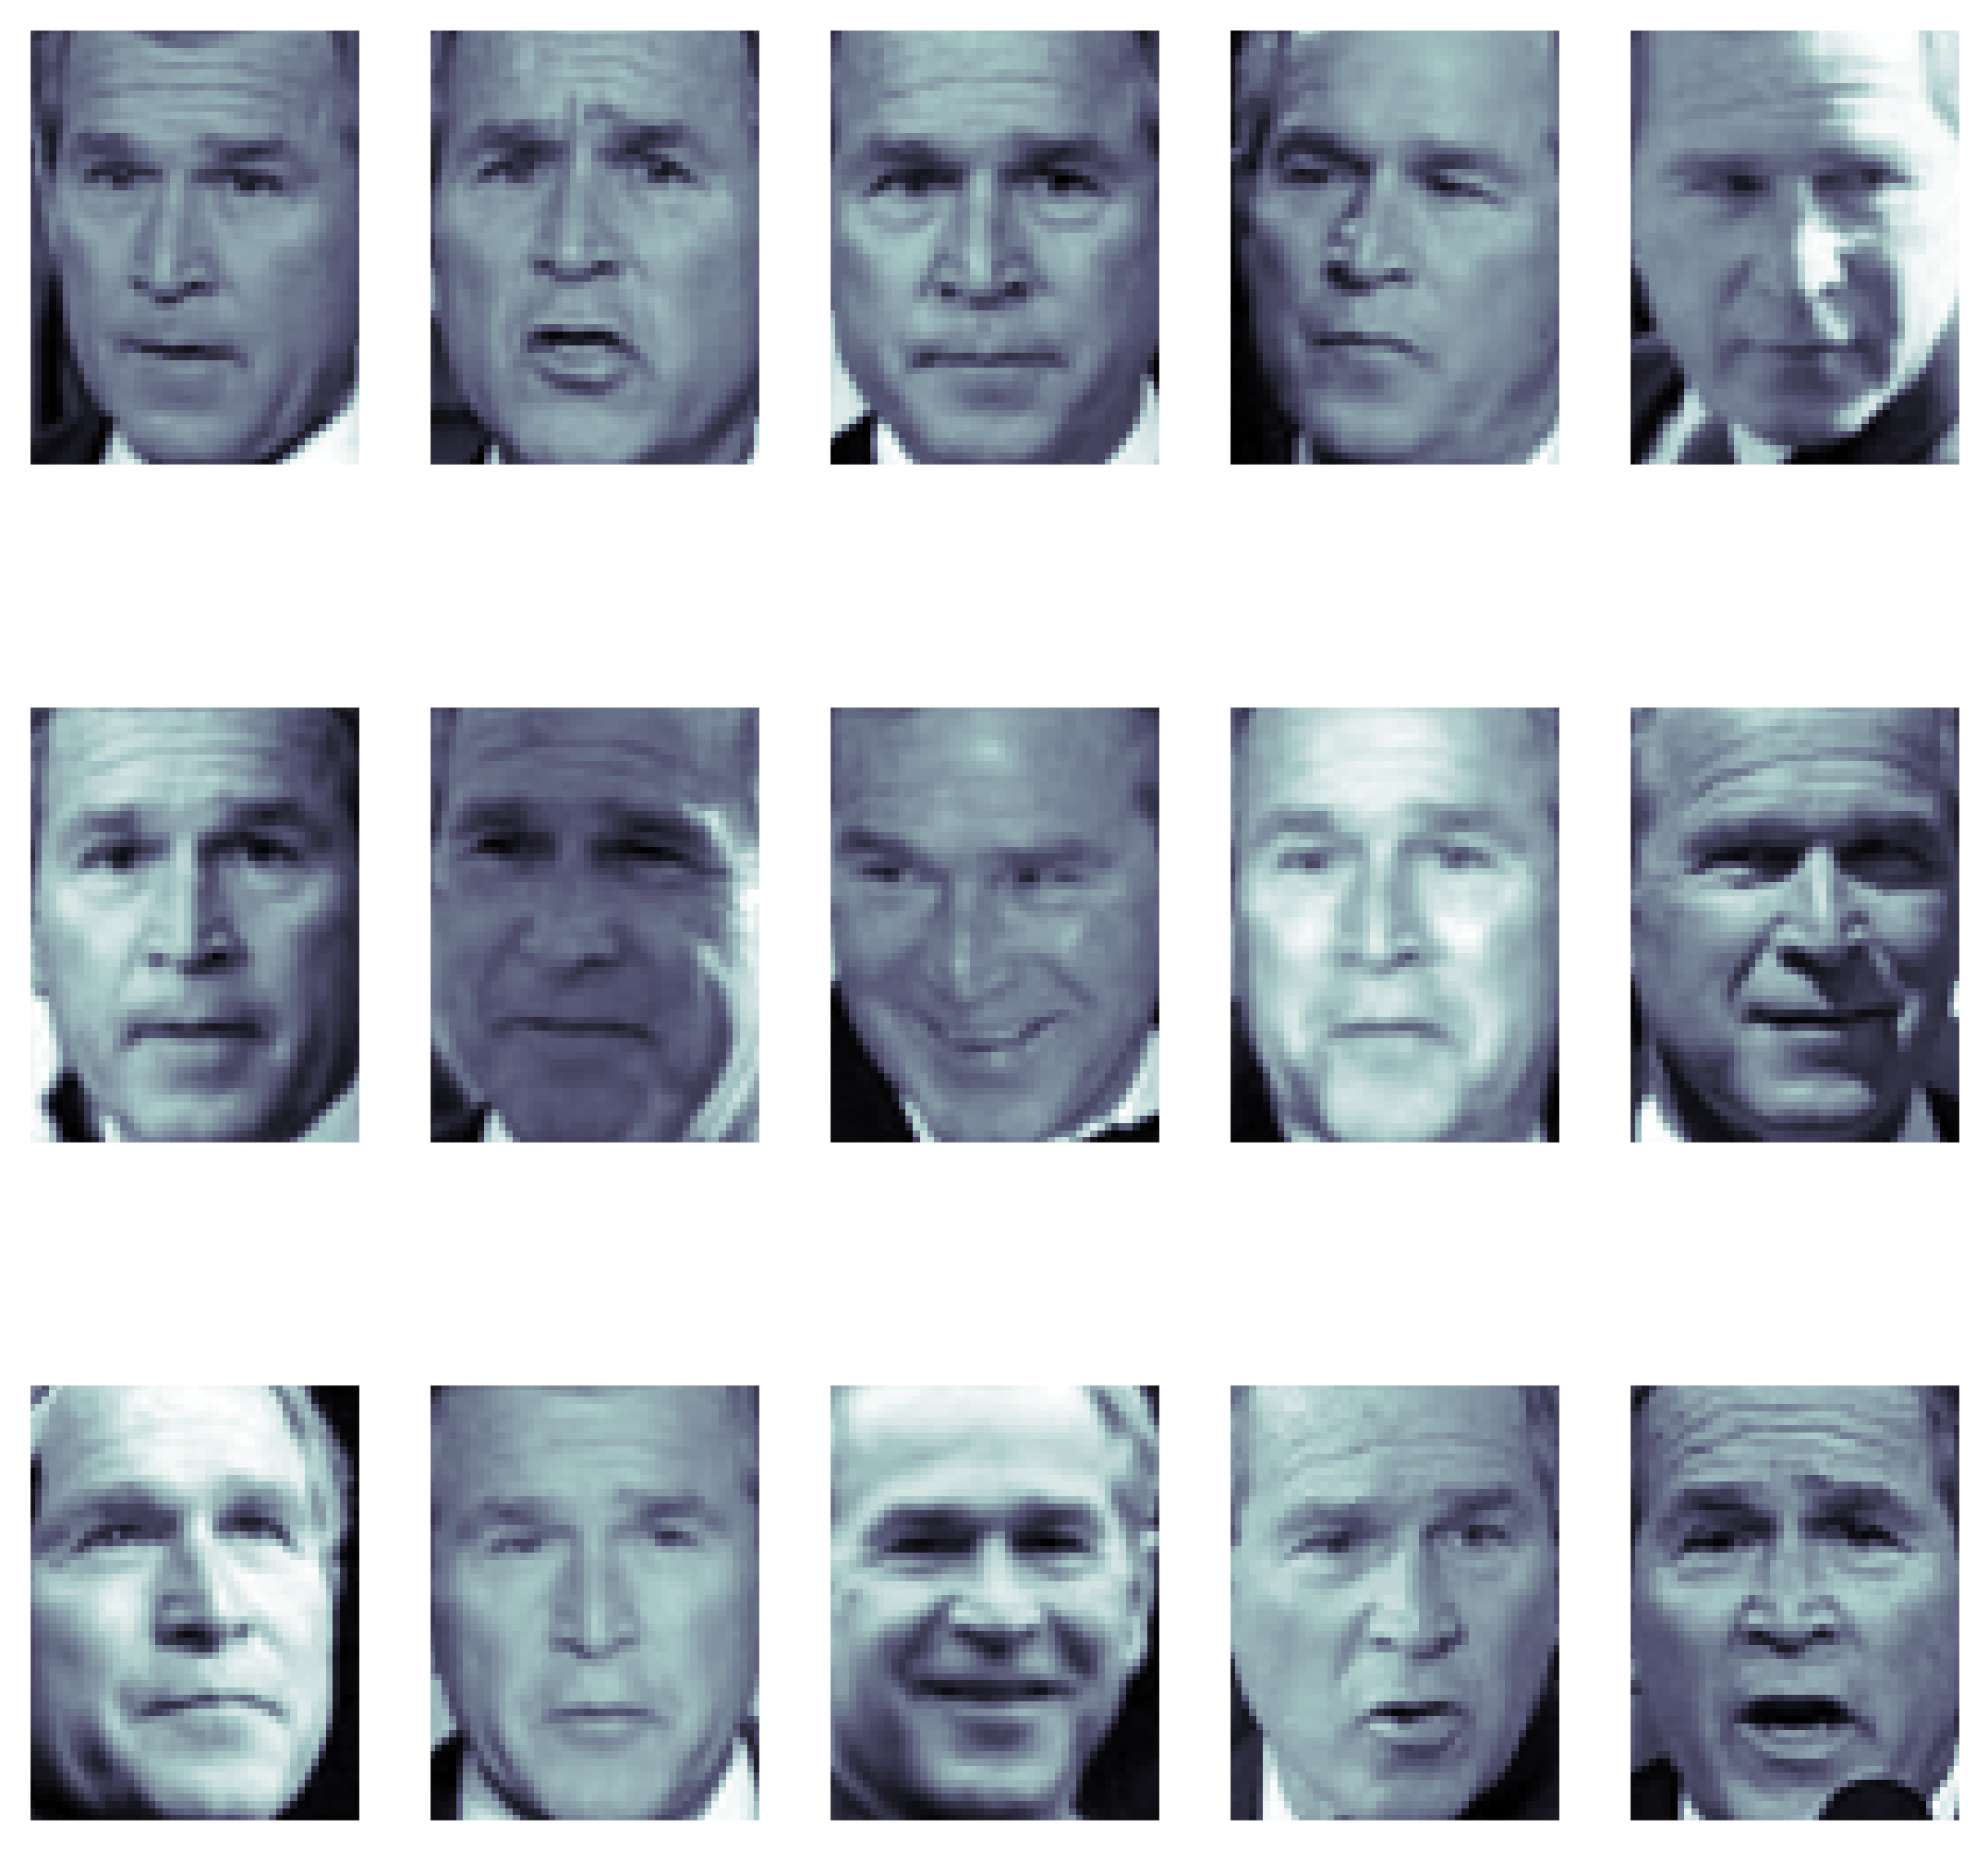

In [17]:
fig, ax = plt.subplots(3, 5, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(bush_faces[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

Каждое изображение имеет размер [62×47] $-$ это примерно 3000 пикселей. Мы можем использовать пиксели как признаки, но лучше понизить размерность пространства признаков.

Извлечем 150 самых информативных признаков из данных фотографий методом **RandomizedPCA** (суть данного алгоритм разберем чуть позже)

In [18]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

Попробуем решить задачу классификации методом SVM

In [19]:
svc = SVC(kernel='linear', class_weight='balanced')

model = make_pipeline(pca, svc)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [21]:
X_train.shape

(1011, 2914)

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 17.2 s, sys: 156 ms, total: 17.3 s
Wall time: 4.35 s
{'svc__C': 1}


In [23]:
model = grid.best_estimator_

y_fit = model.predict(X_test)

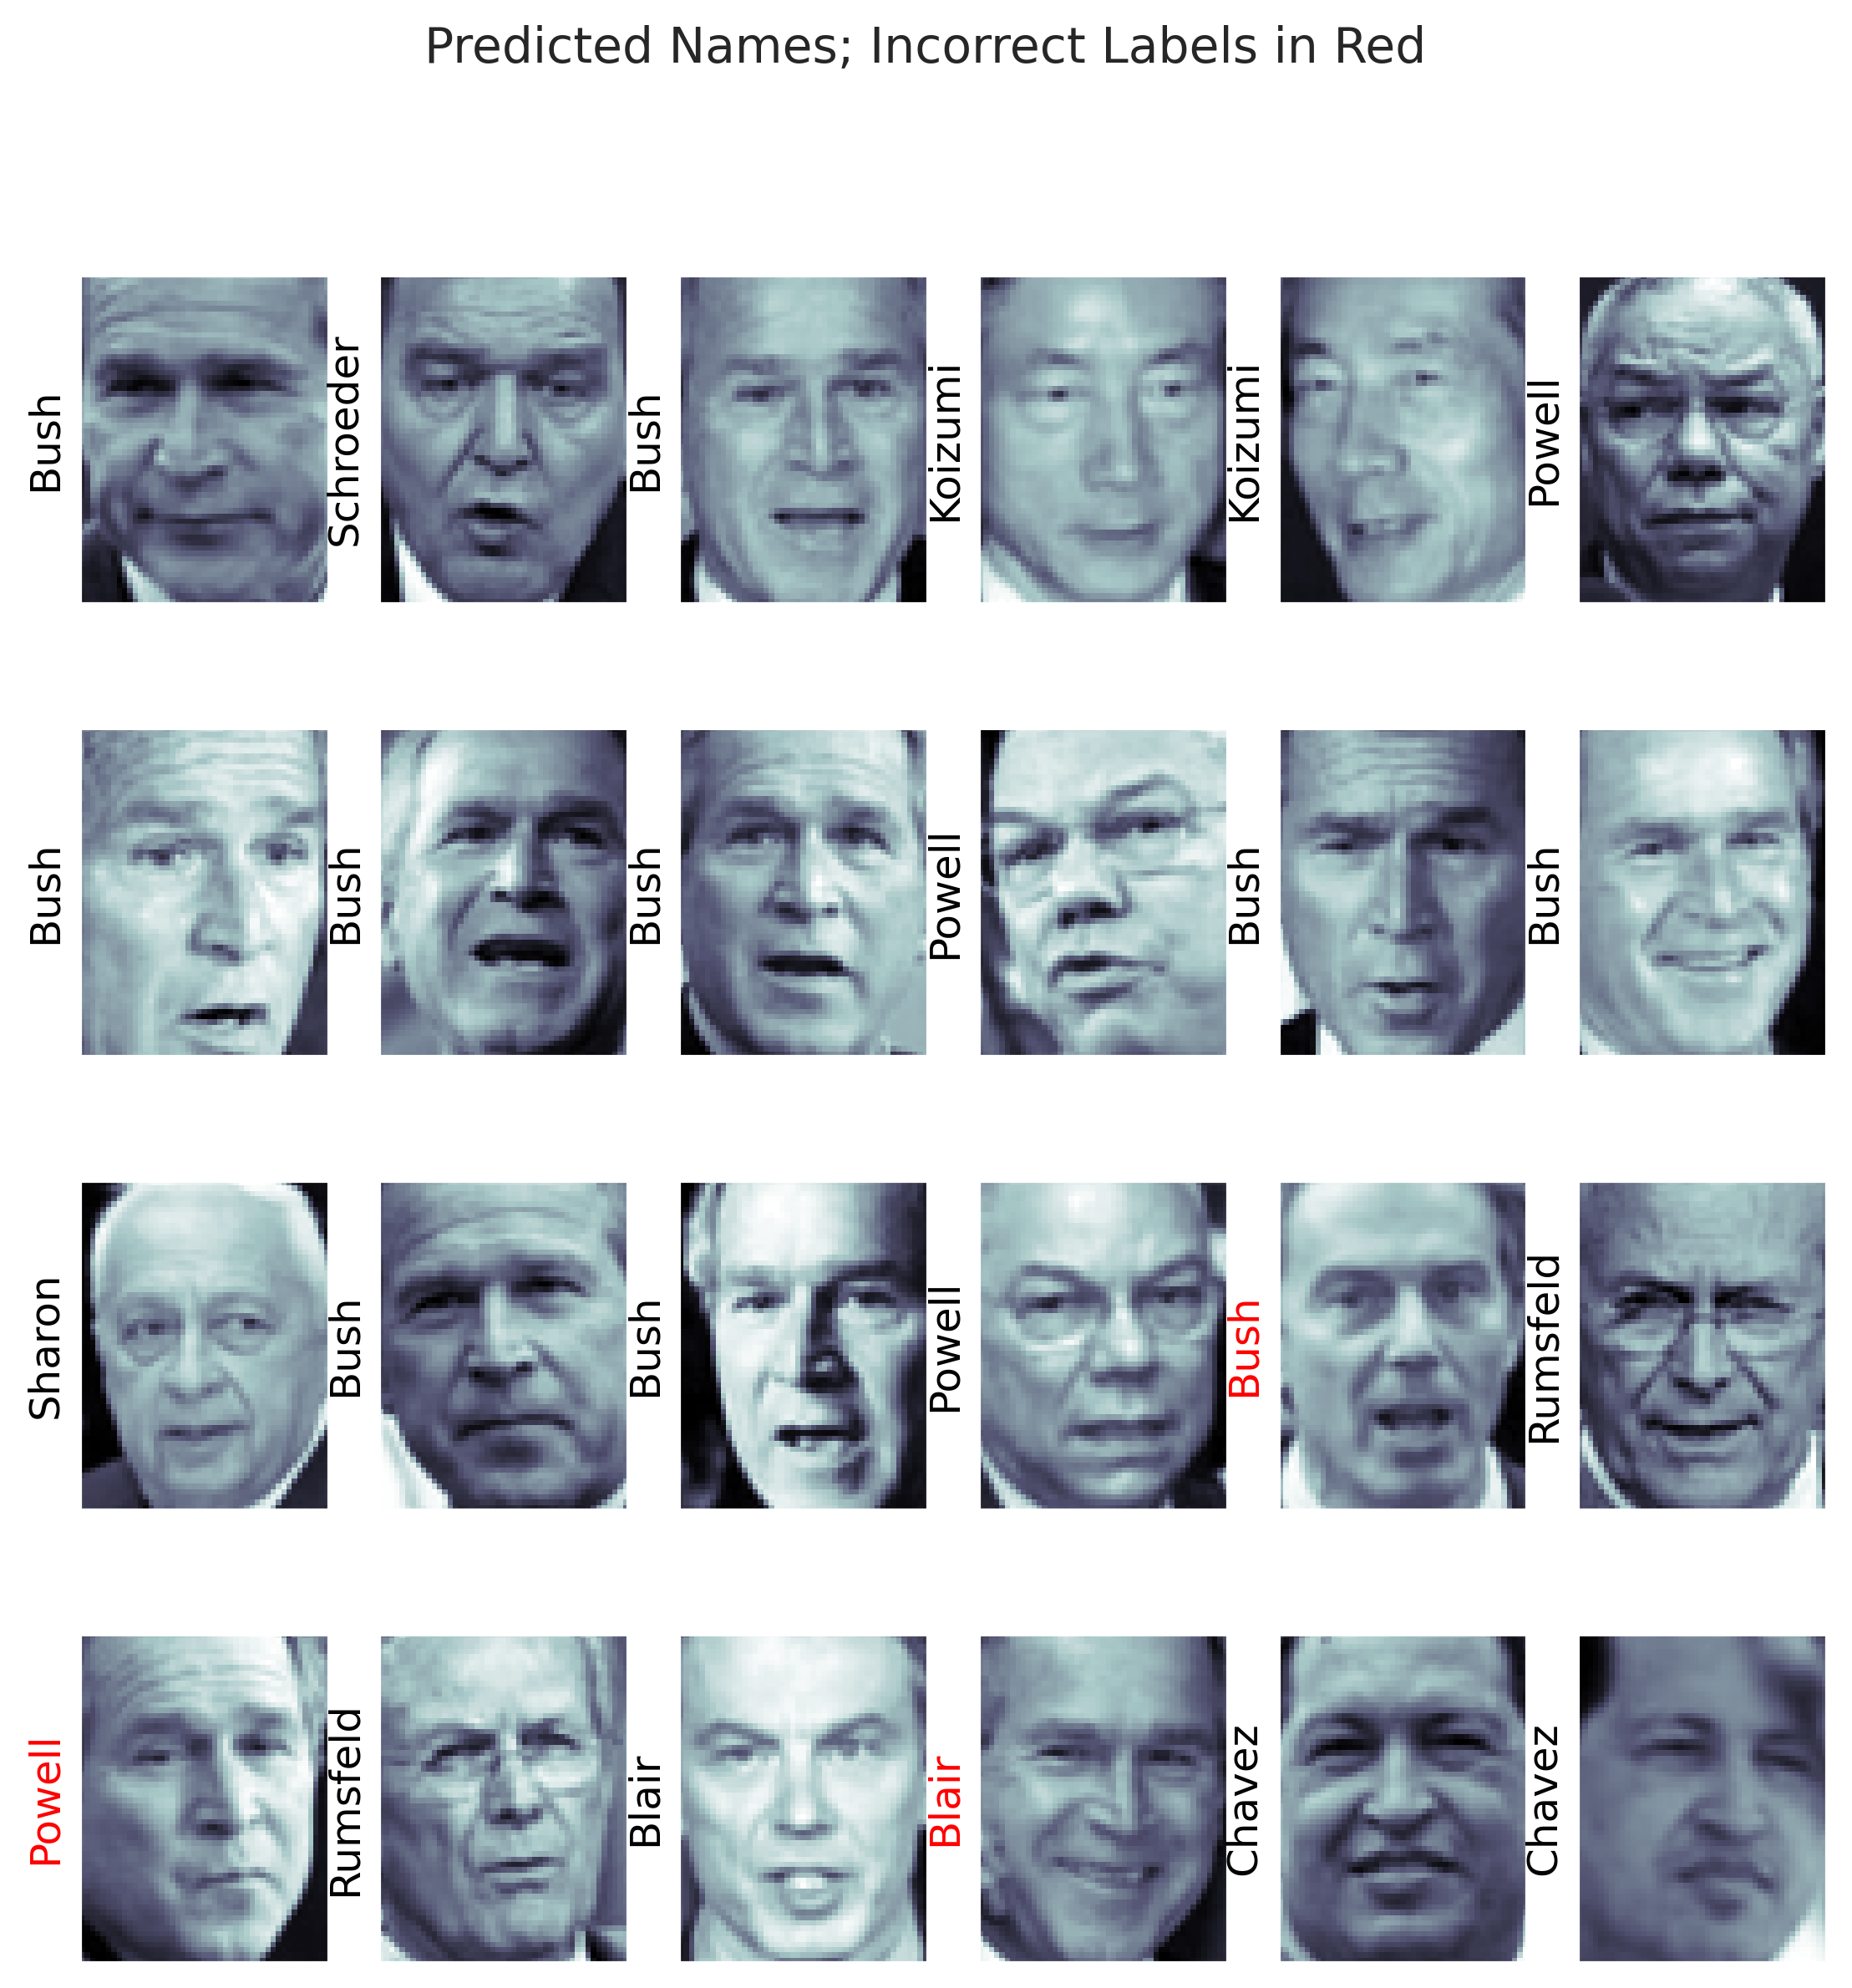

In [24]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

Выведем на экран метрики классификации.

In [25]:
f1_scores = dict()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit,
                            target_names=faces.target_names))
report = classification_report(y_test, y_fit,
                            target_names=faces.target_names, output_dict=True)
f1_scores['linear'] = report['macro avg']['f1-score']

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.67      0.65        15
     Colin Powell       0.78      0.85      0.82        68
  Donald Rumsfeld       0.69      0.71      0.70        31
    George W Bush       0.85      0.79      0.81       126
Gerhard Schroeder       0.68      0.74      0.71        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.73      0.76      0.74        42

         accuracy                           0.78       337
        macro avg       0.77      0.78      0.77       337
     weighted avg       0.79      0.78      0.78       337



Лучше всего предсказывается Junichiro Koizumi (для него самое большое <code>f1-score</code>).

Изобразим матрицу ошибок классификатора (<code>confusion_matrix</code>)

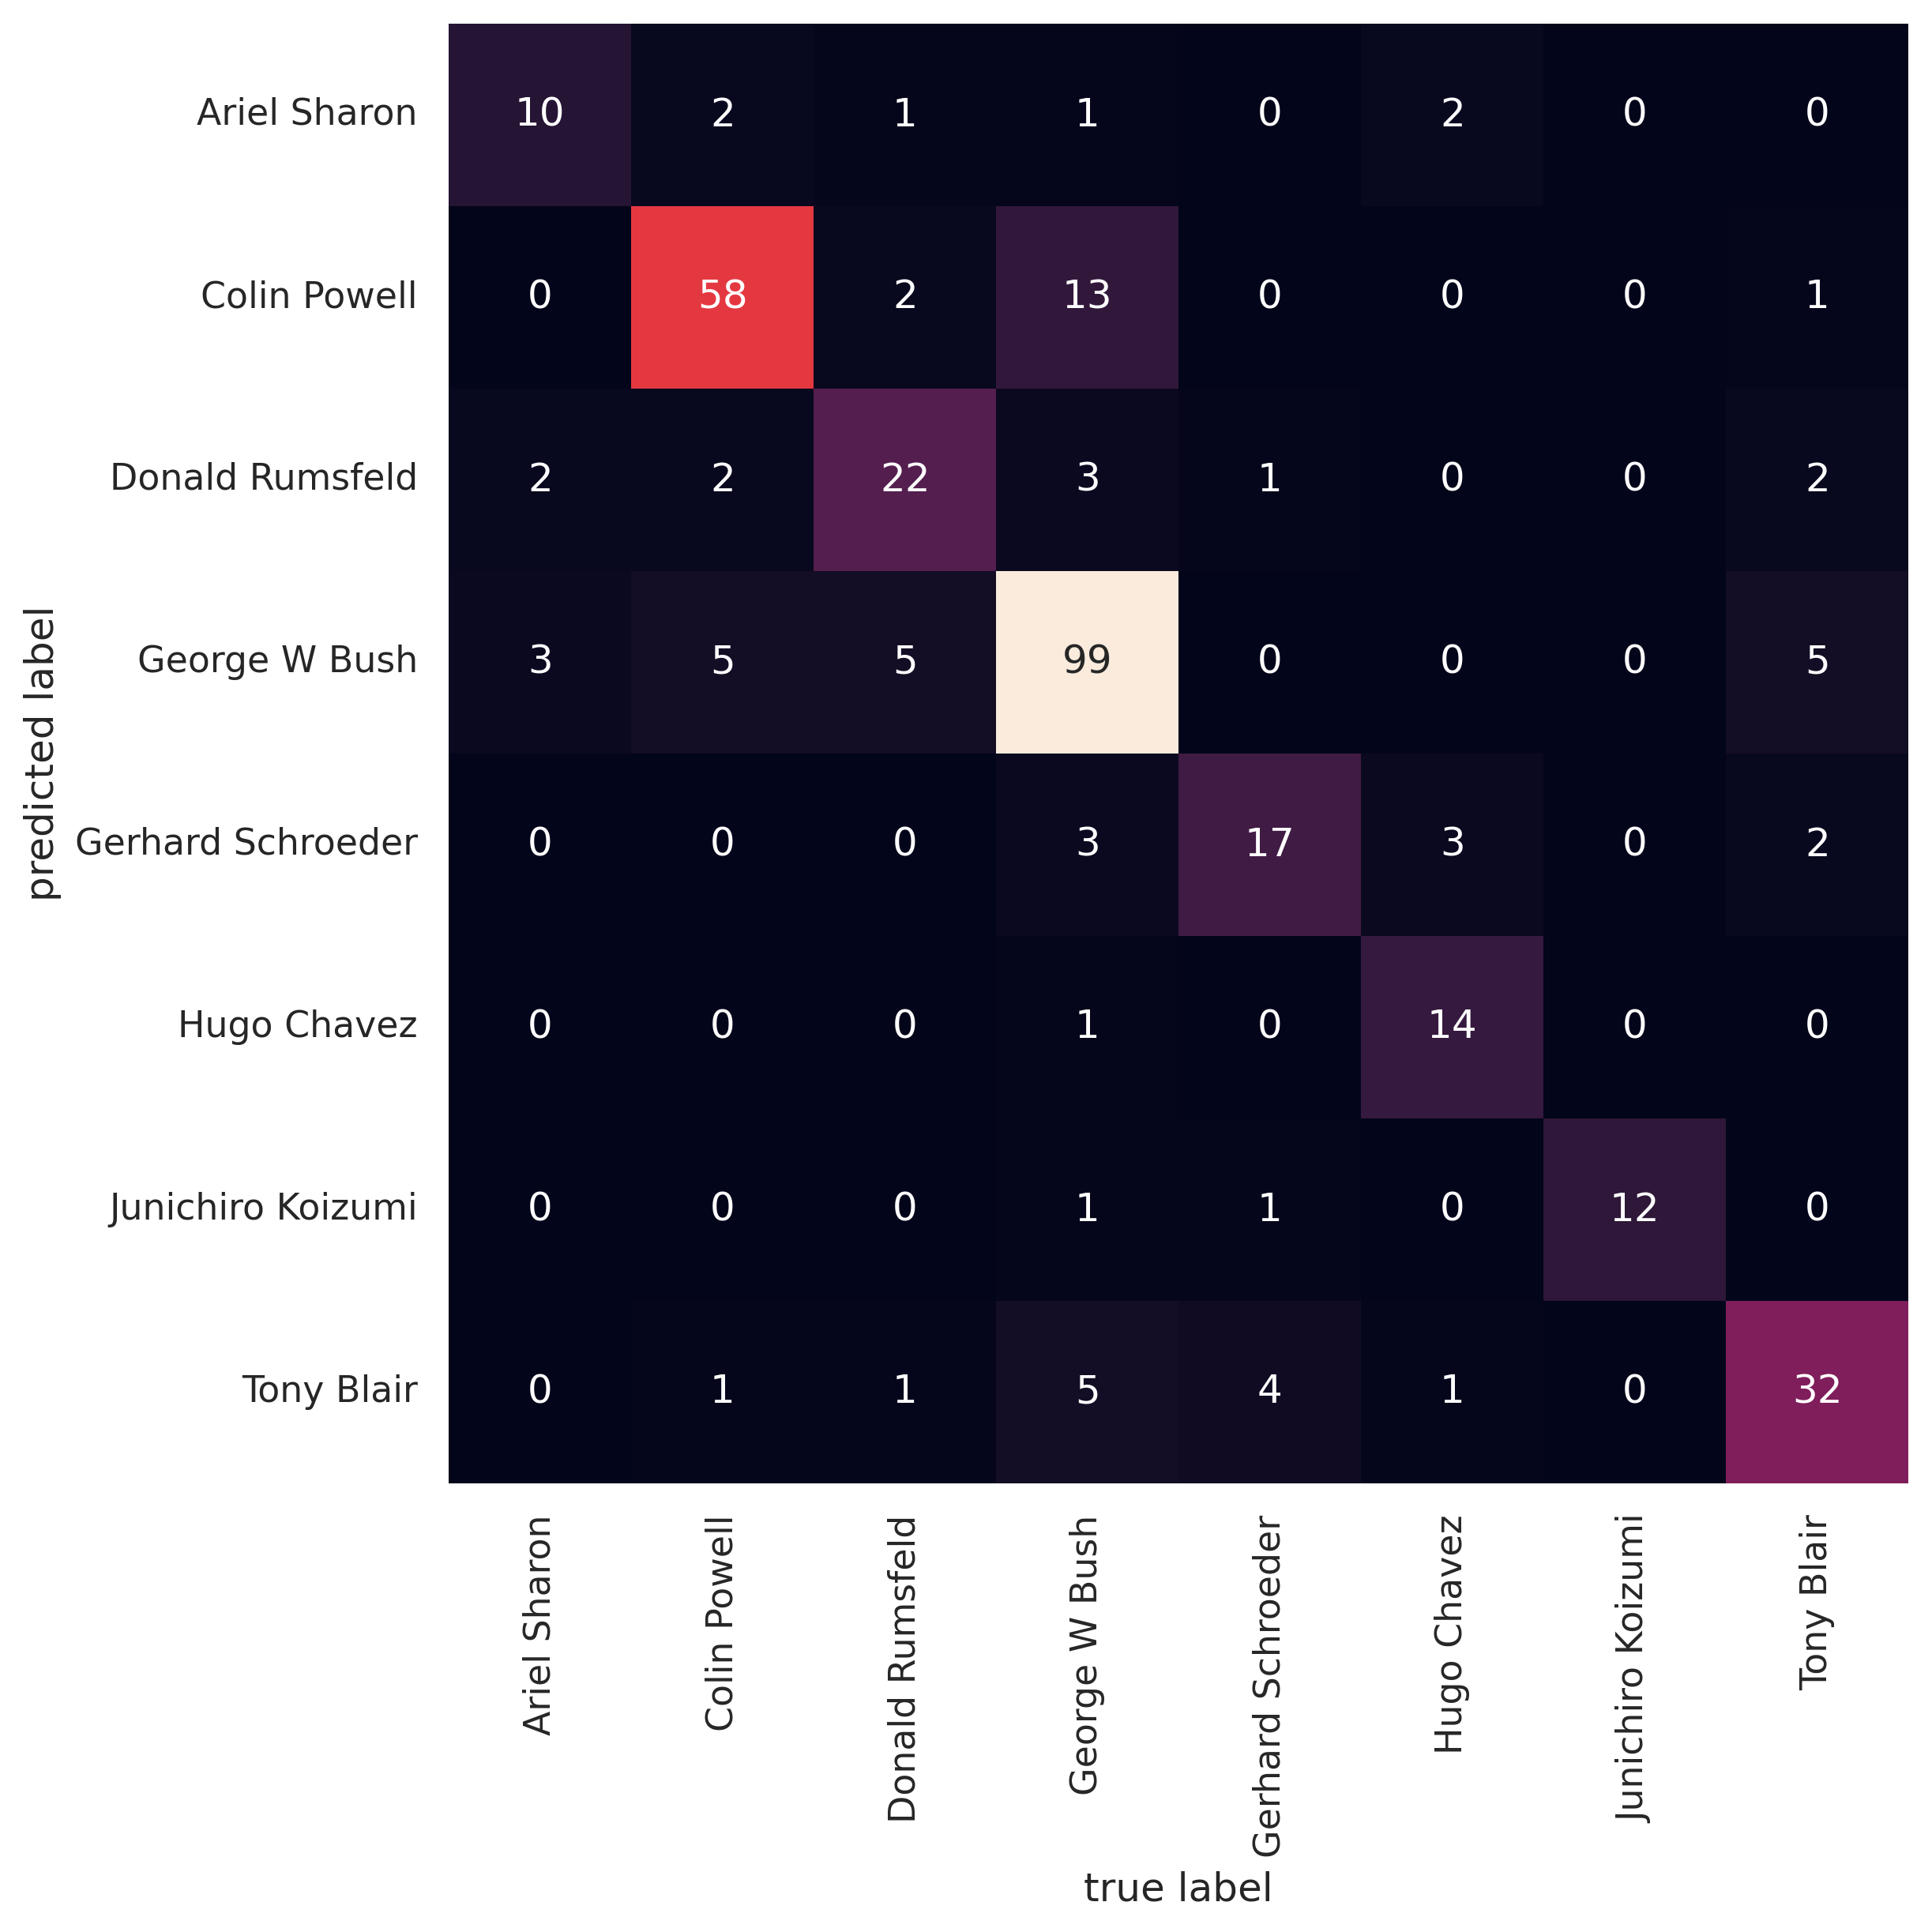

In [27]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_fit, y_test)

0.7833827893175074

### Решение нелинейных задач с помощью SVM

Решим другую задачу классификации, в которой объекты одного класса окаймляют объекты другого класса. Для этого, как и раньше, используем метод SVM с линейным ядром

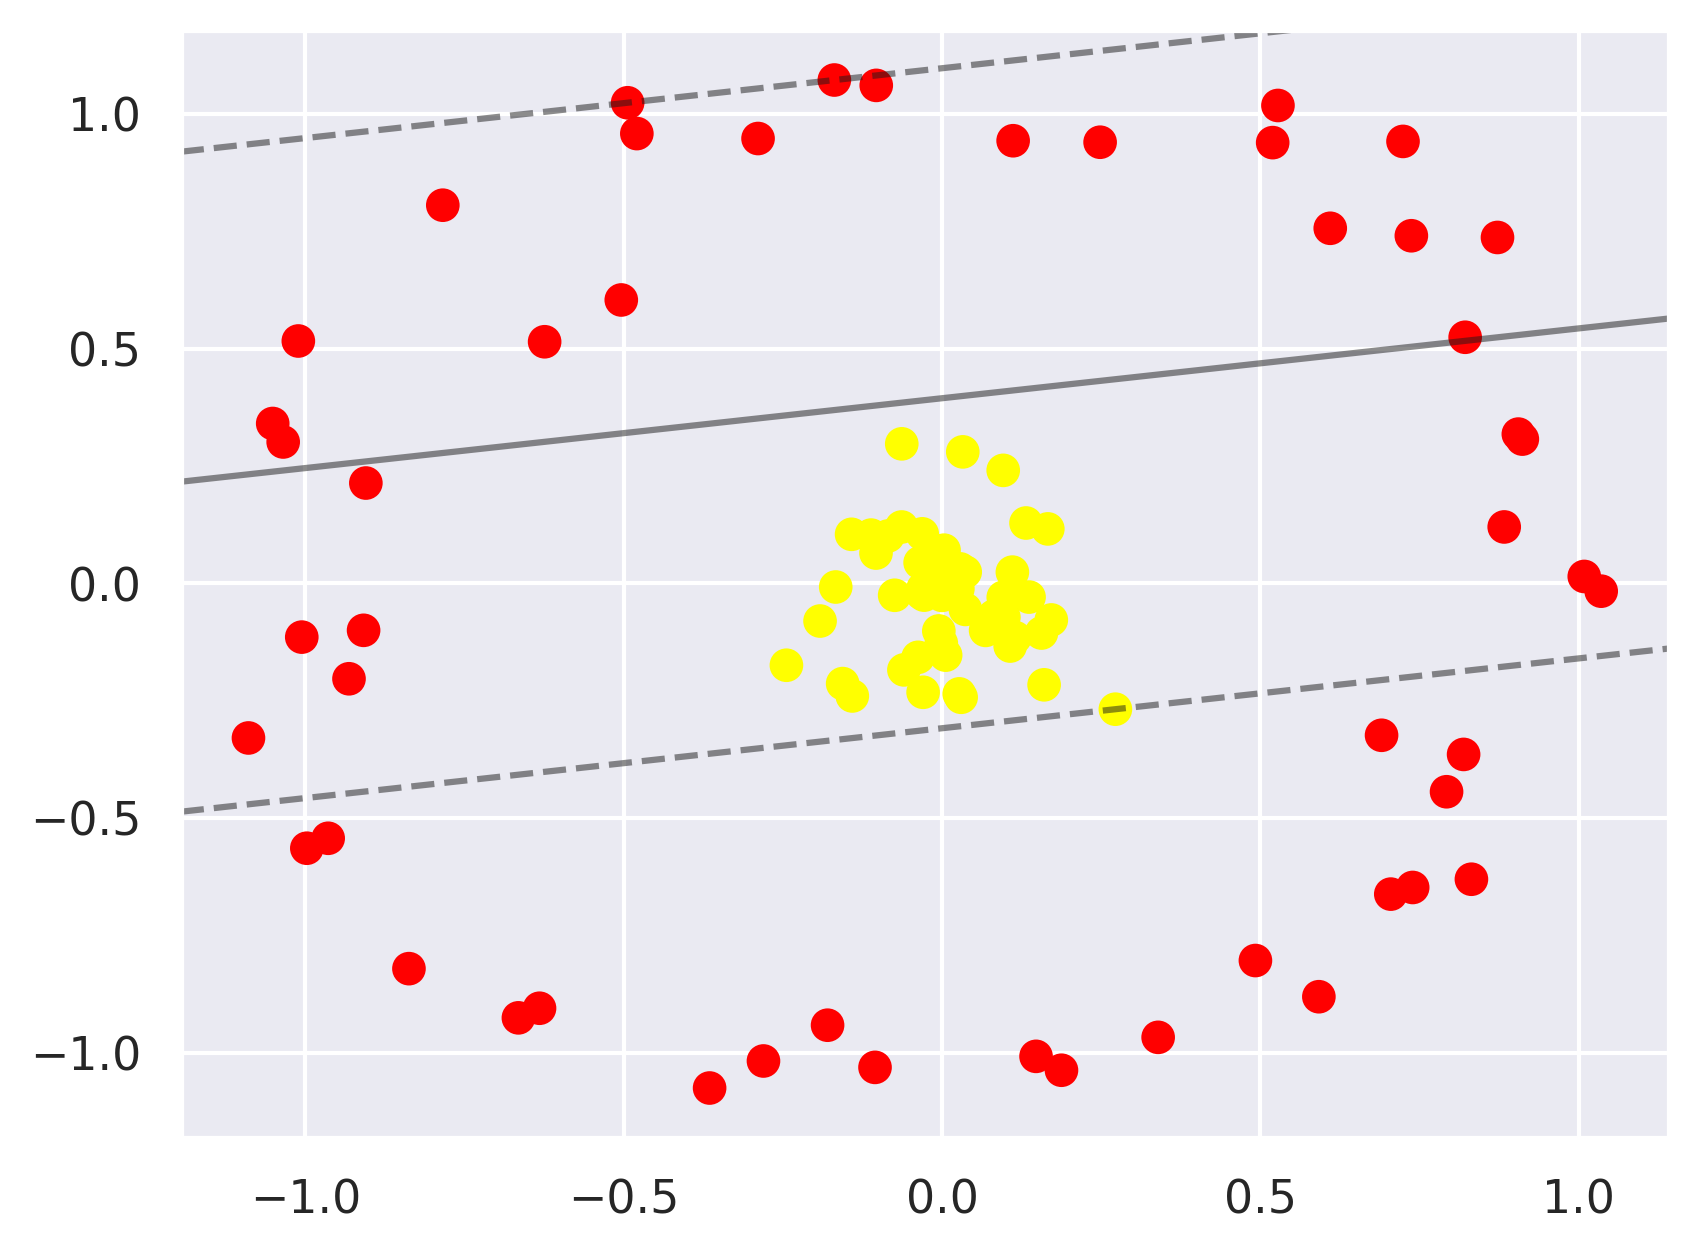

In [29]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=0.1, noise=0.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Перейдем в пространство новой (большей) размерности. В данном примере в качестве третьей координаты можно использовать радиальную фунцию:

In [30]:
r = np.exp(-(X**2).sum(1))

In [31]:
from mpl_toolkits import mplot3d

In [32]:
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45, 0, 45, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, -45, 0, 45, 90), value=-90), IntSlider(value=…

Видим, что в новом пространстве выборка стала линейно разделимой.

Решение исходной задачи в новом пространстве с помощью SVM называется **ядровым SVM** (Kernel SVM). Для этого используем rbf-ядро (**radial basis function kernel**)

$$ K(x, x') = \exp(-\gamma ||x - x'||^2), \quad \gamma > 0.$$

In [33]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

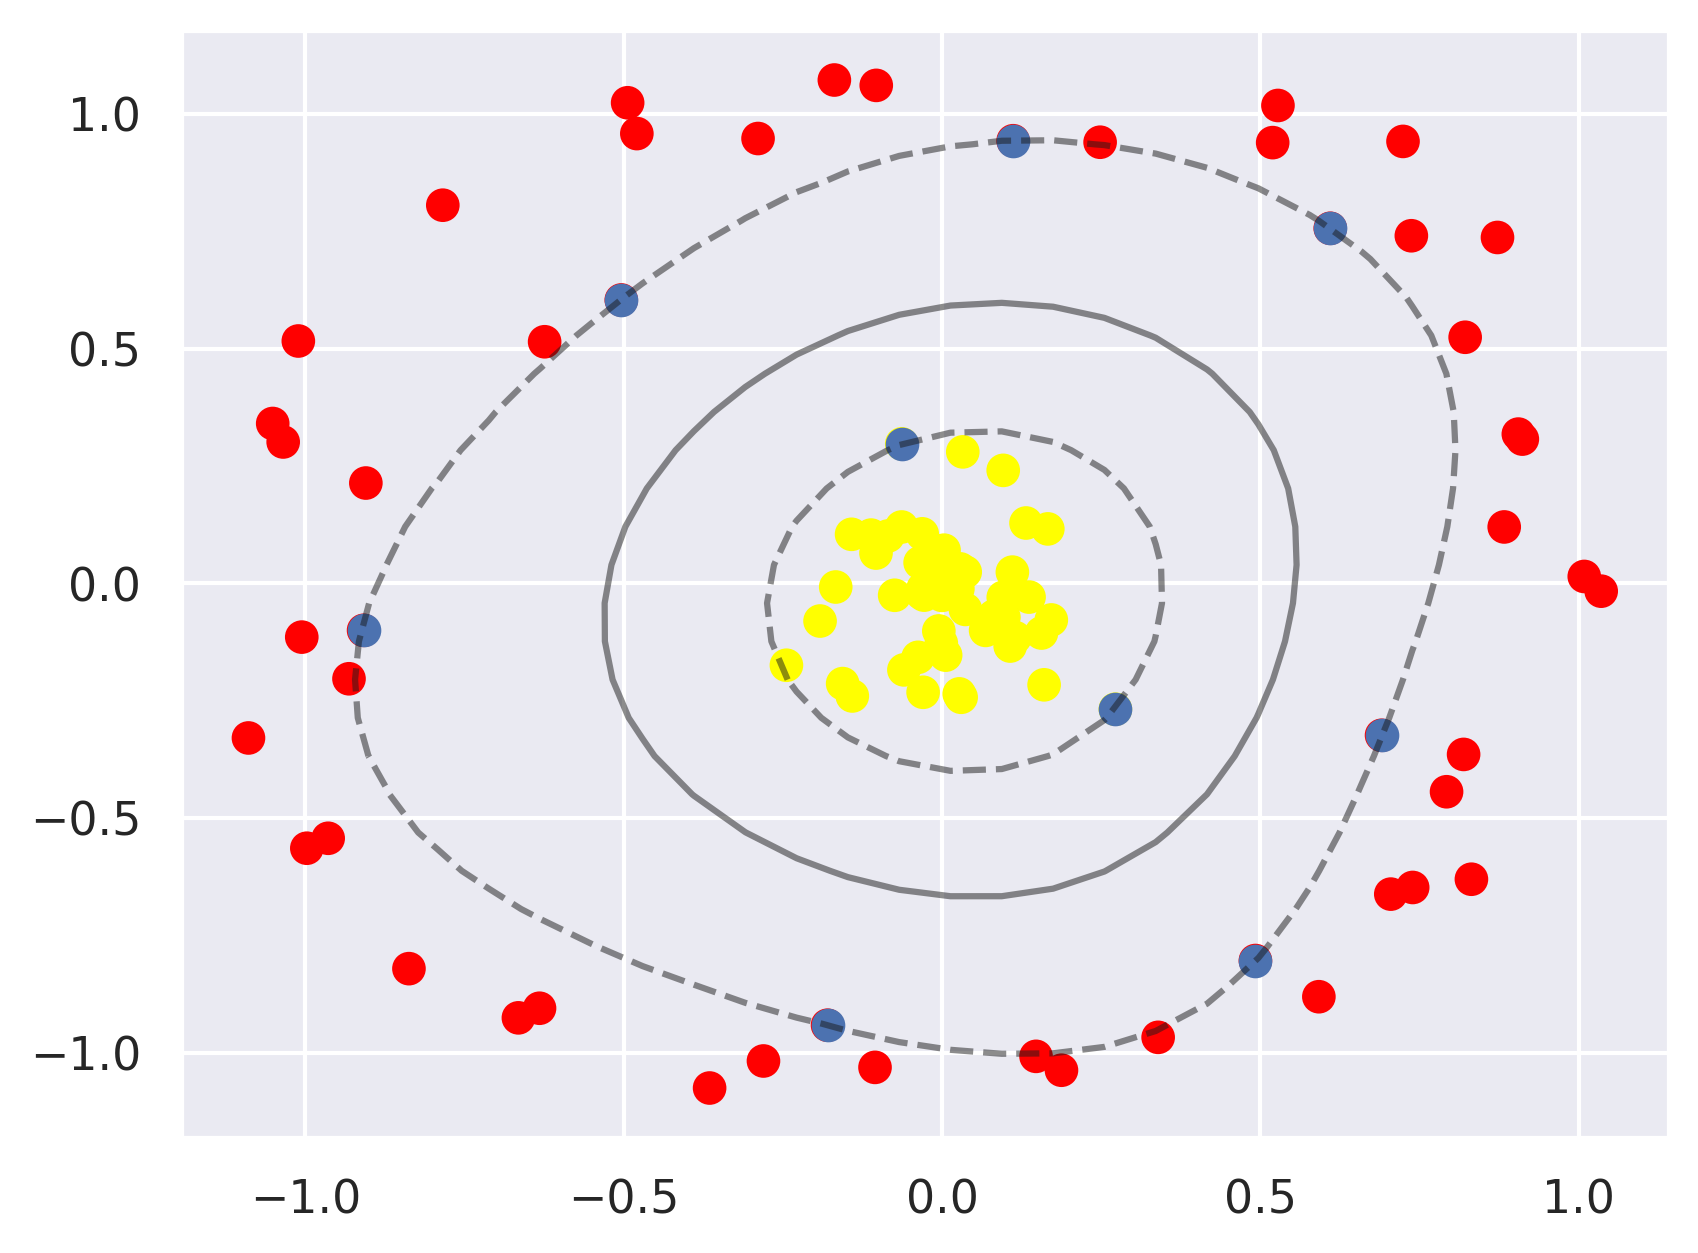

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Задание 1

Решим задачу распознавания лиц с помощью SVM с ядром. Попробуйте различные ядра: <code>'poly'</code>, <code>'rbf'</code>, <code>'sigmoid'</code>.

Подберем гиперпараметры по кросс-валидации.

1. Ядро <code>poly</code>

In [35]:
svc = SVC(kernel='poly', class_weight='balanced')
model = make_pipeline(pca, svc)

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 22.1 s, sys: 188 ms, total: 22.3 s
Wall time: 5.62 s
{'svc__C': 50}


In [37]:
model = grid.best_estimator_

y_fit = model.predict(X_test)

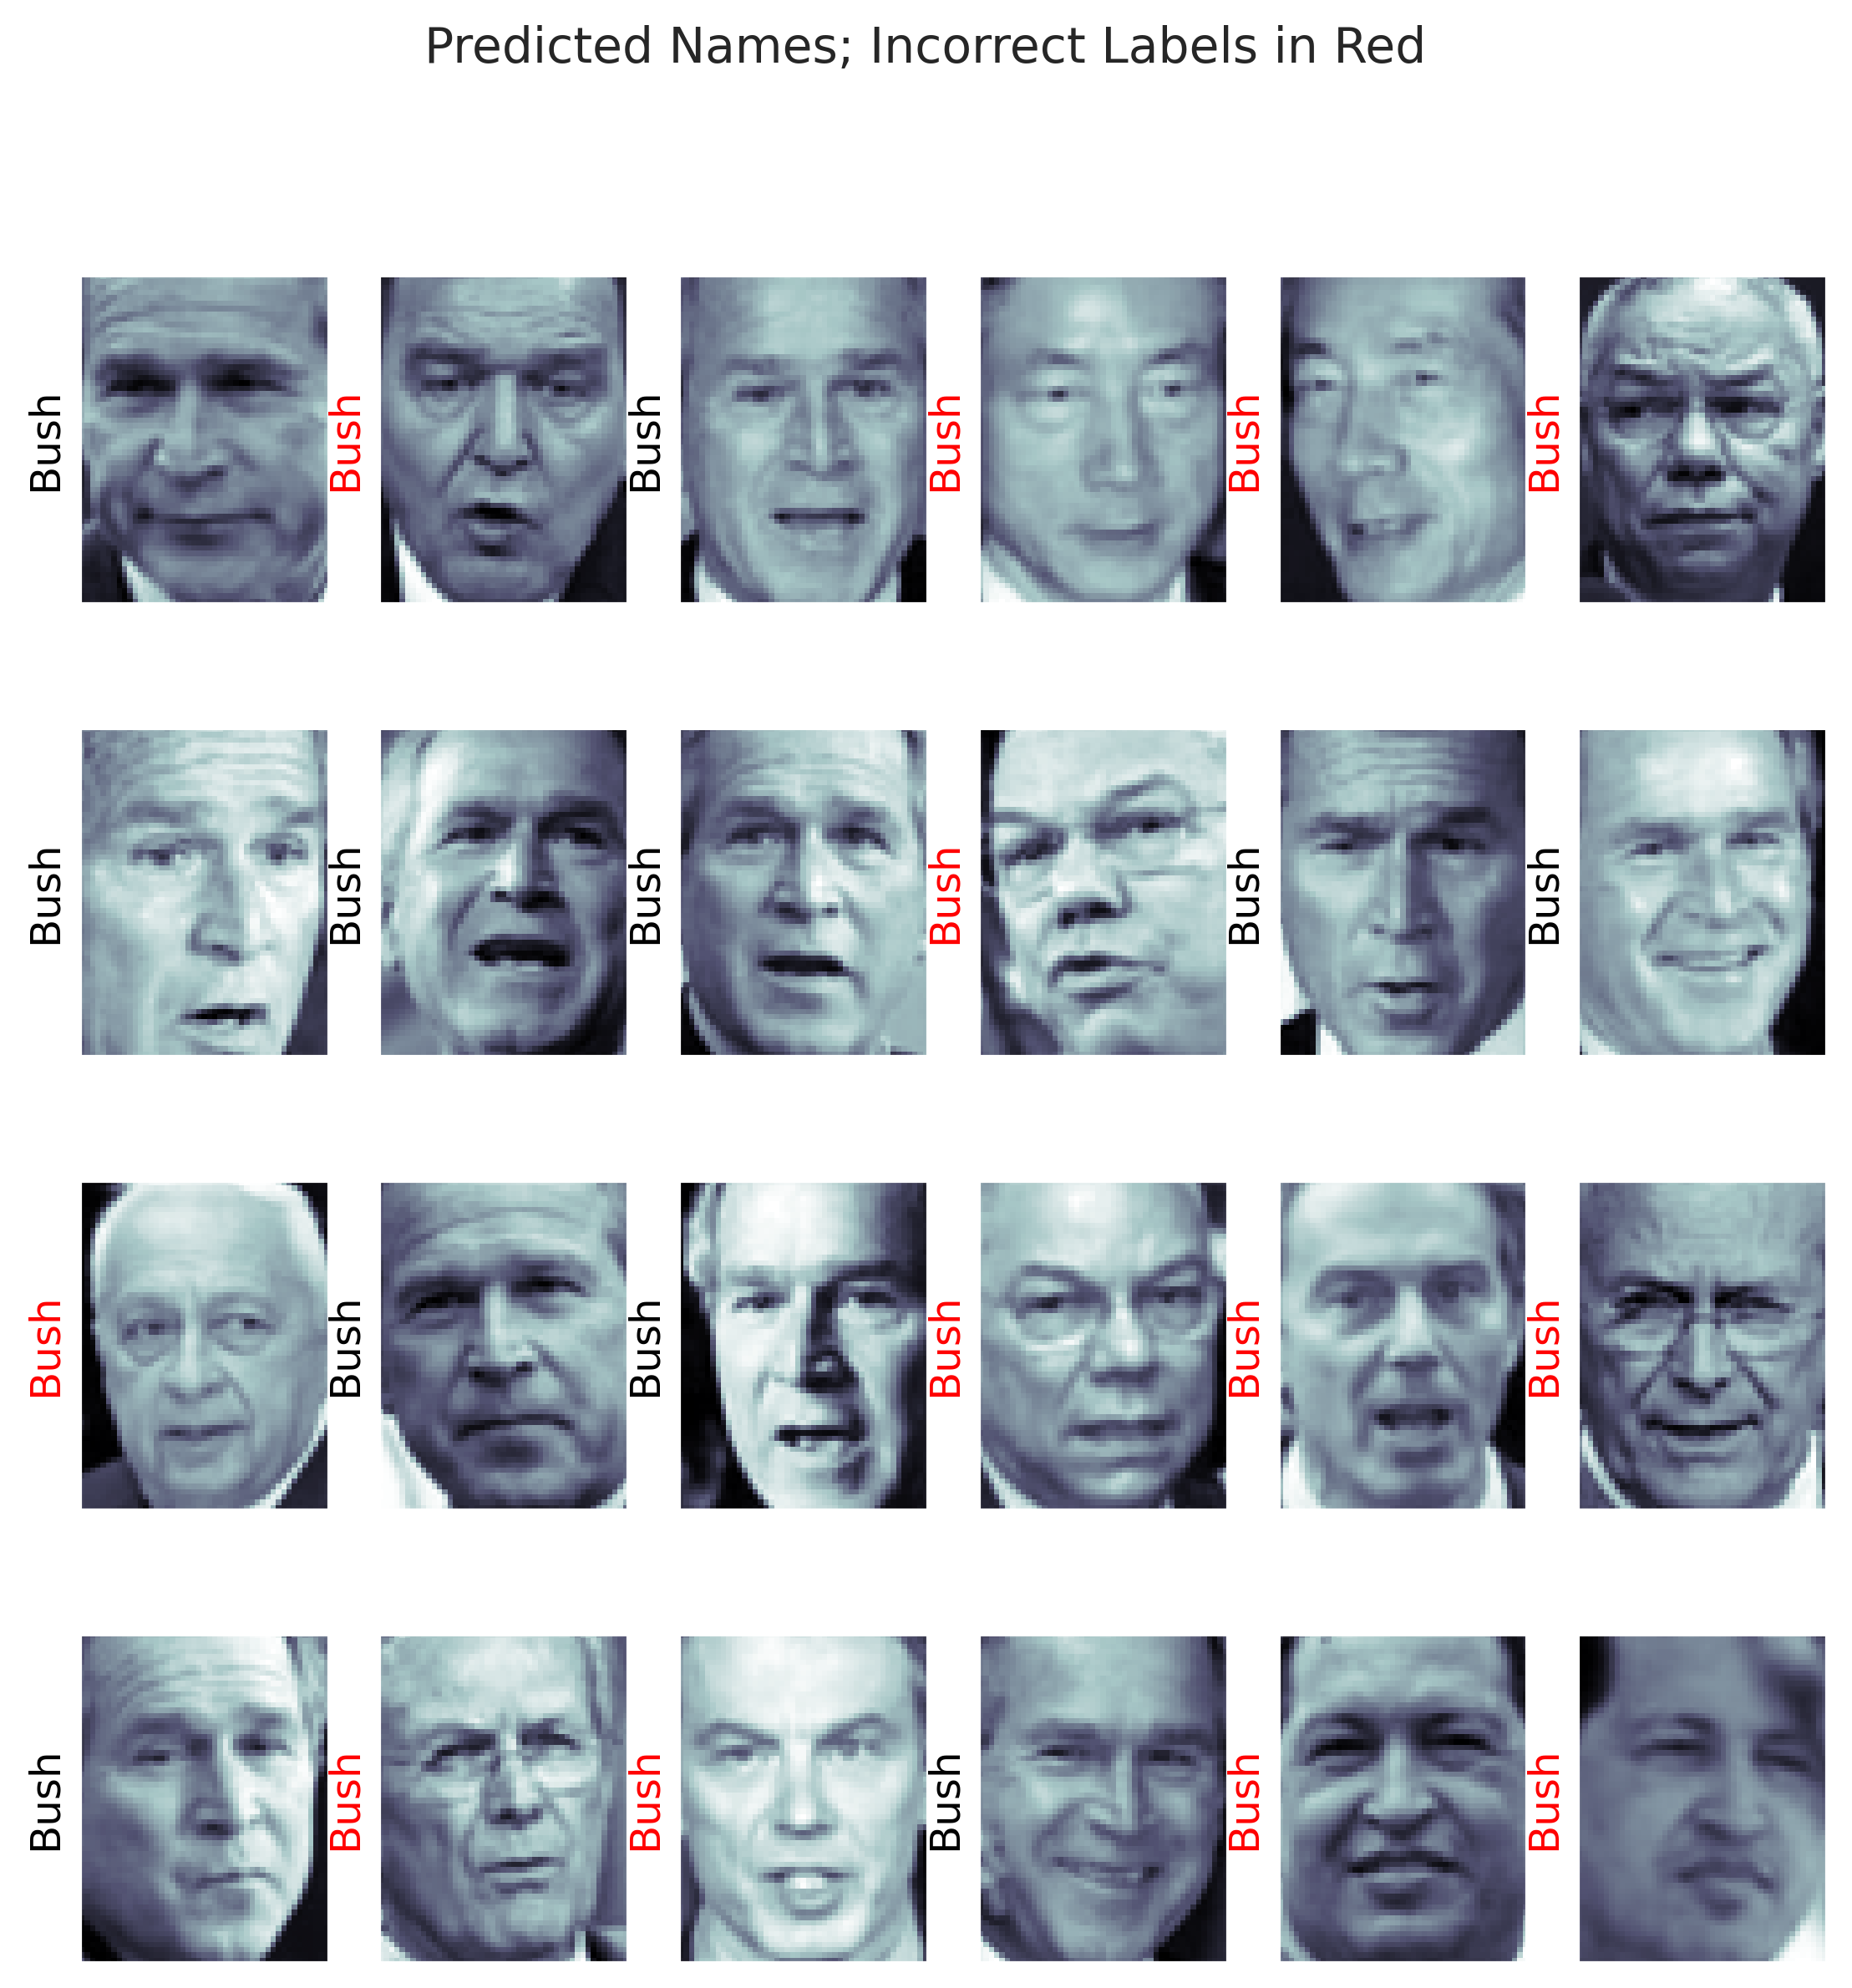

In [38]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

In [39]:
print(classification_report(y_test, y_fit,
                            target_names=faces.target_names))
report = classification_report(y_test, y_fit,
                            target_names=faces.target_names, output_dict=True)
f1_scores['poly'] = report['macro avg']['f1-score']

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.13      0.24        15
     Colin Powell       1.00      0.16      0.28        68
  Donald Rumsfeld       0.00      0.00      0.00        31
    George W Bush       0.40      0.99      0.57       126
Gerhard Schroeder       0.50      0.04      0.08        23
      Hugo Chavez       1.00      0.05      0.10        20
Junichiro Koizumi       1.00      0.33      0.50        12
       Tony Blair       1.00      0.07      0.13        42

         accuracy                           0.44       337
        macro avg       0.74      0.22      0.24       337
     weighted avg       0.65      0.44      0.33       337



2. Ядро <code>rbf</code>

In [40]:
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [41]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 22.4 s, sys: 168 ms, total: 22.6 s
Wall time: 5.67 s
{'svc__C': 1}


In [42]:
model = grid.best_estimator_

y_fit = model.predict(X_test)

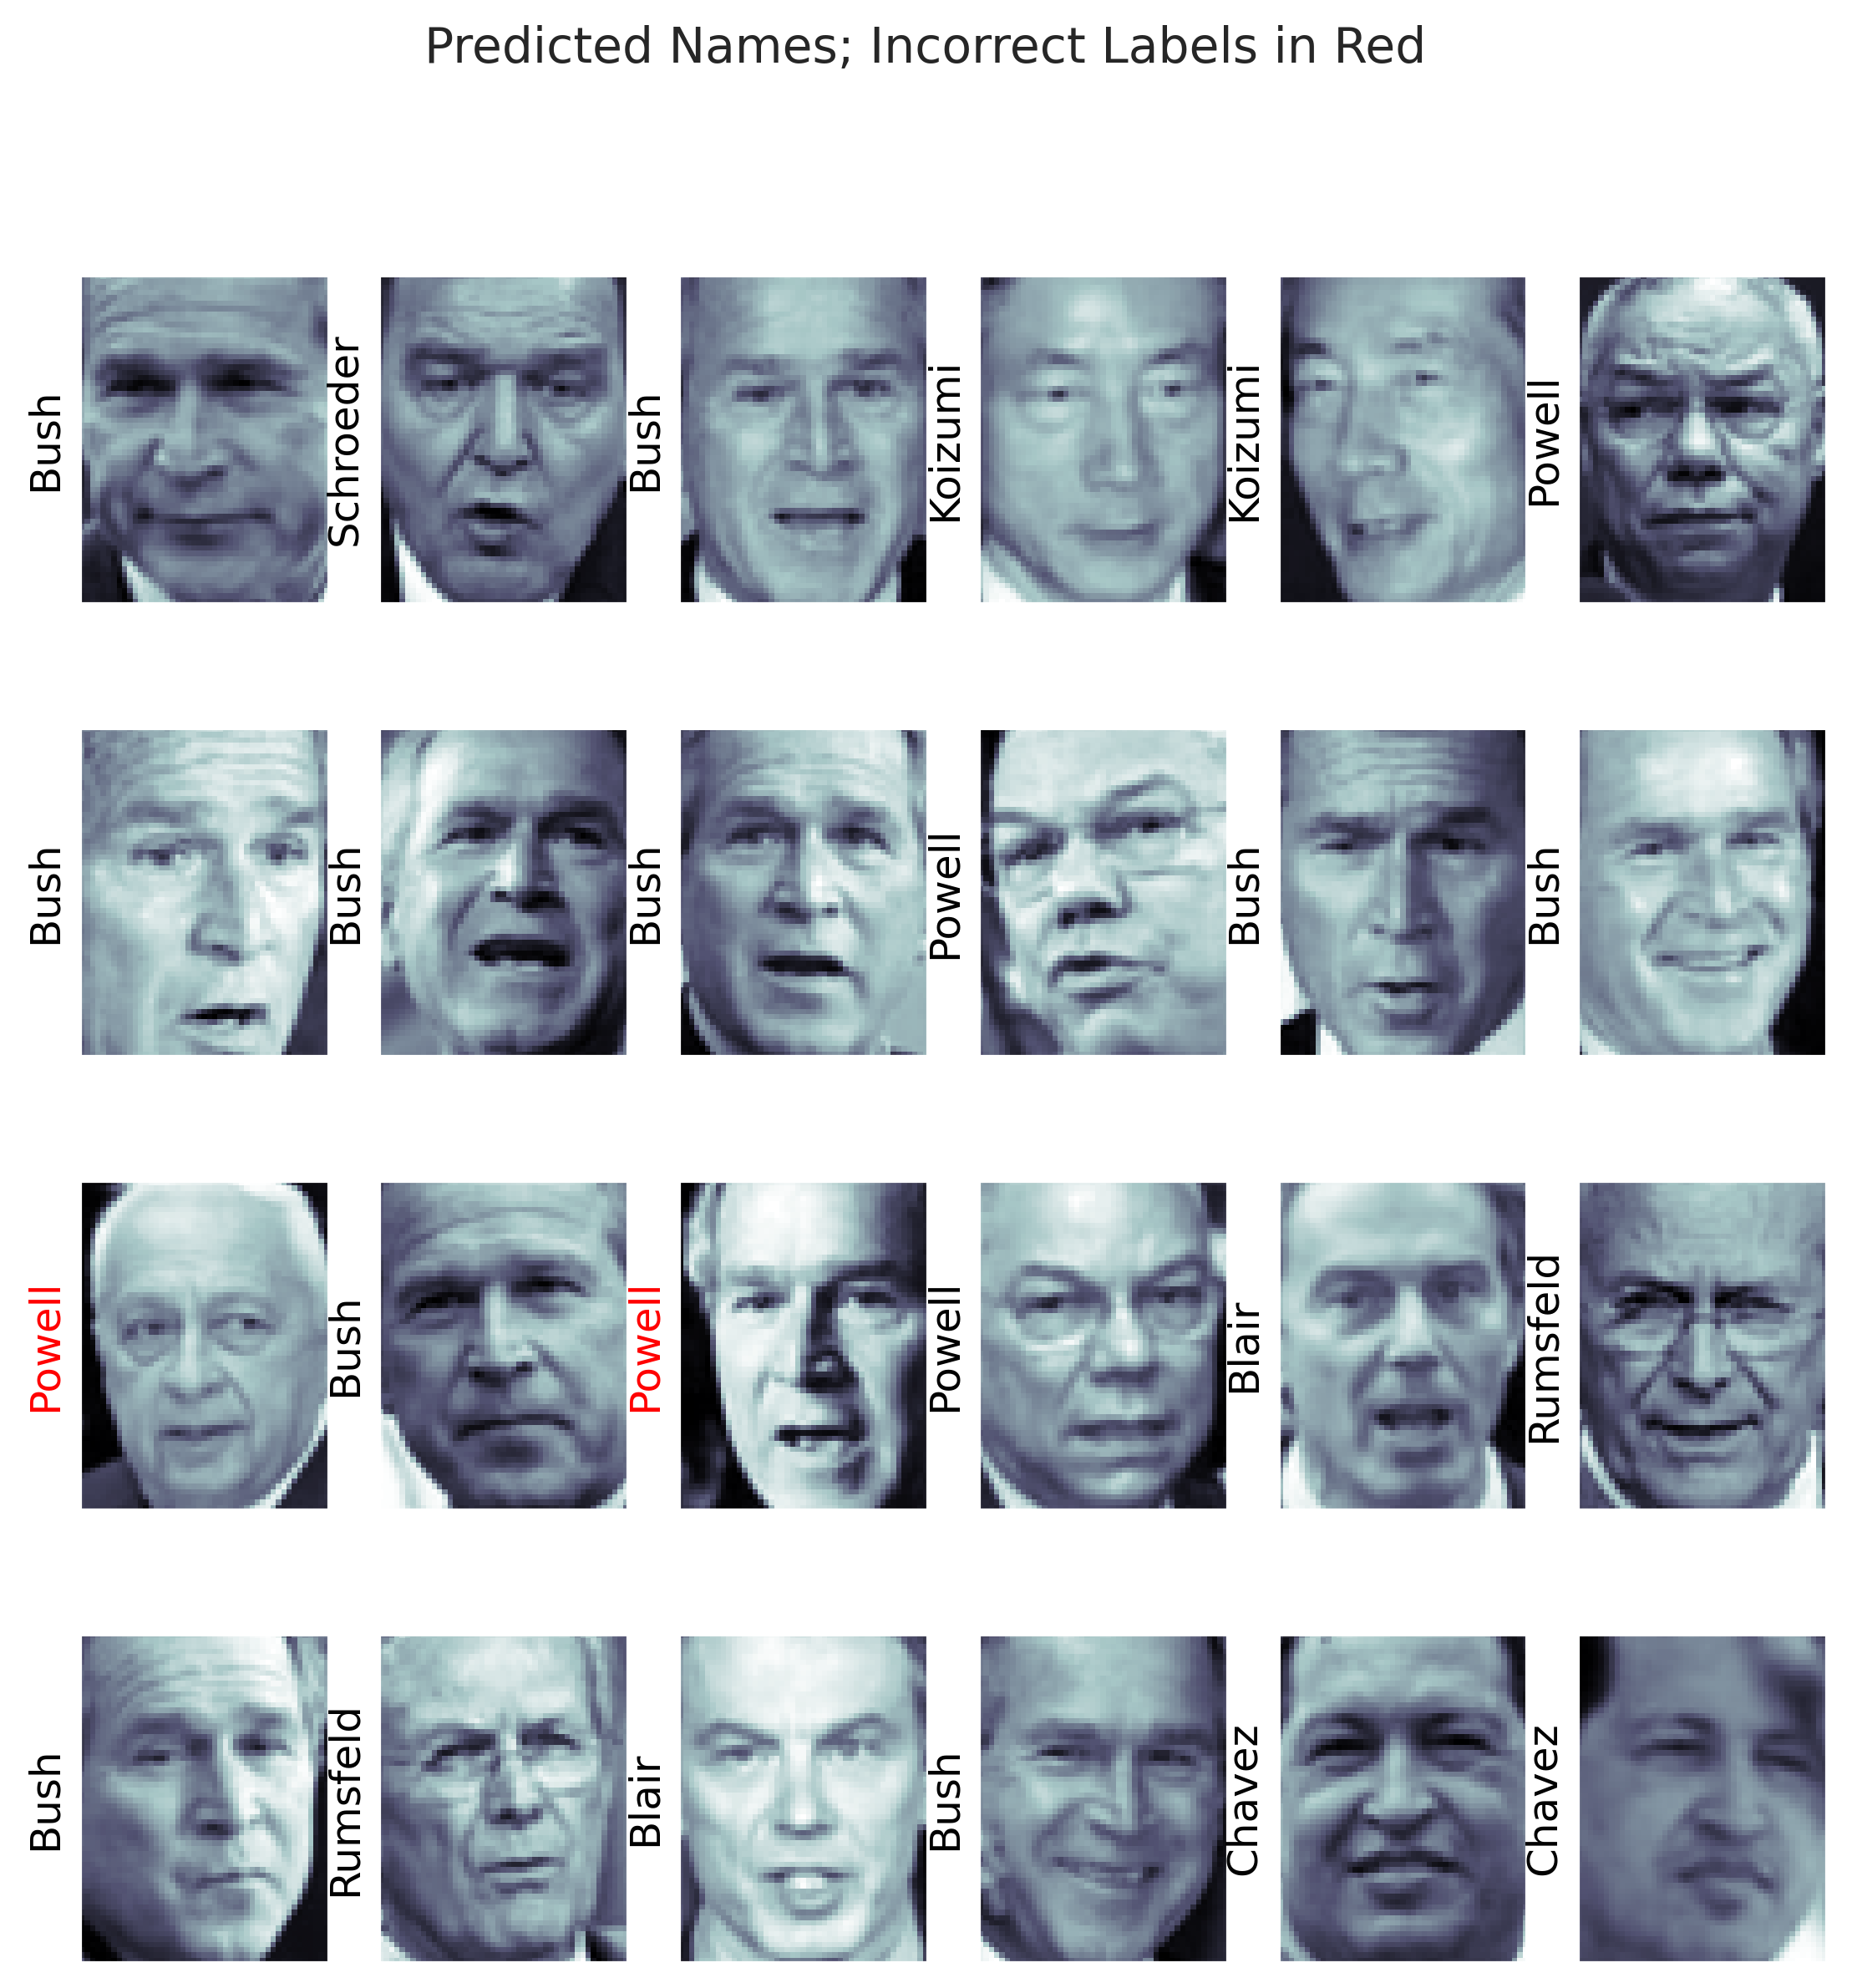

In [43]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

In [44]:
print(classification_report(y_test, y_fit,
                            target_names=faces.target_names))
report = classification_report(y_test, y_fit,
                            target_names=faces.target_names, output_dict=True)
f1_scores['rbf'] = report['macro avg']['f1-score']

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.73      0.85        15
     Colin Powell       0.68      0.96      0.80        68
  Donald Rumsfeld       0.92      0.77      0.84        31
    George W Bush       0.91      0.87      0.89       126
Gerhard Schroeder       0.89      0.74      0.81        23
      Hugo Chavez       1.00      0.65      0.79        20
Junichiro Koizumi       1.00      0.92      0.96        12
       Tony Blair       0.86      0.86      0.86        42

         accuracy                           0.85       337
        macro avg       0.91      0.81      0.85       337
     weighted avg       0.87      0.85      0.85       337



3. Ядро <code>sigmoid</code>

In [45]:
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [46]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 17.5 s, sys: 128 ms, total: 17.6 s
Wall time: 4.44 s
{'svc__C': 1}


In [47]:
model = grid.best_estimator_

y_fit = model.predict(X_test)

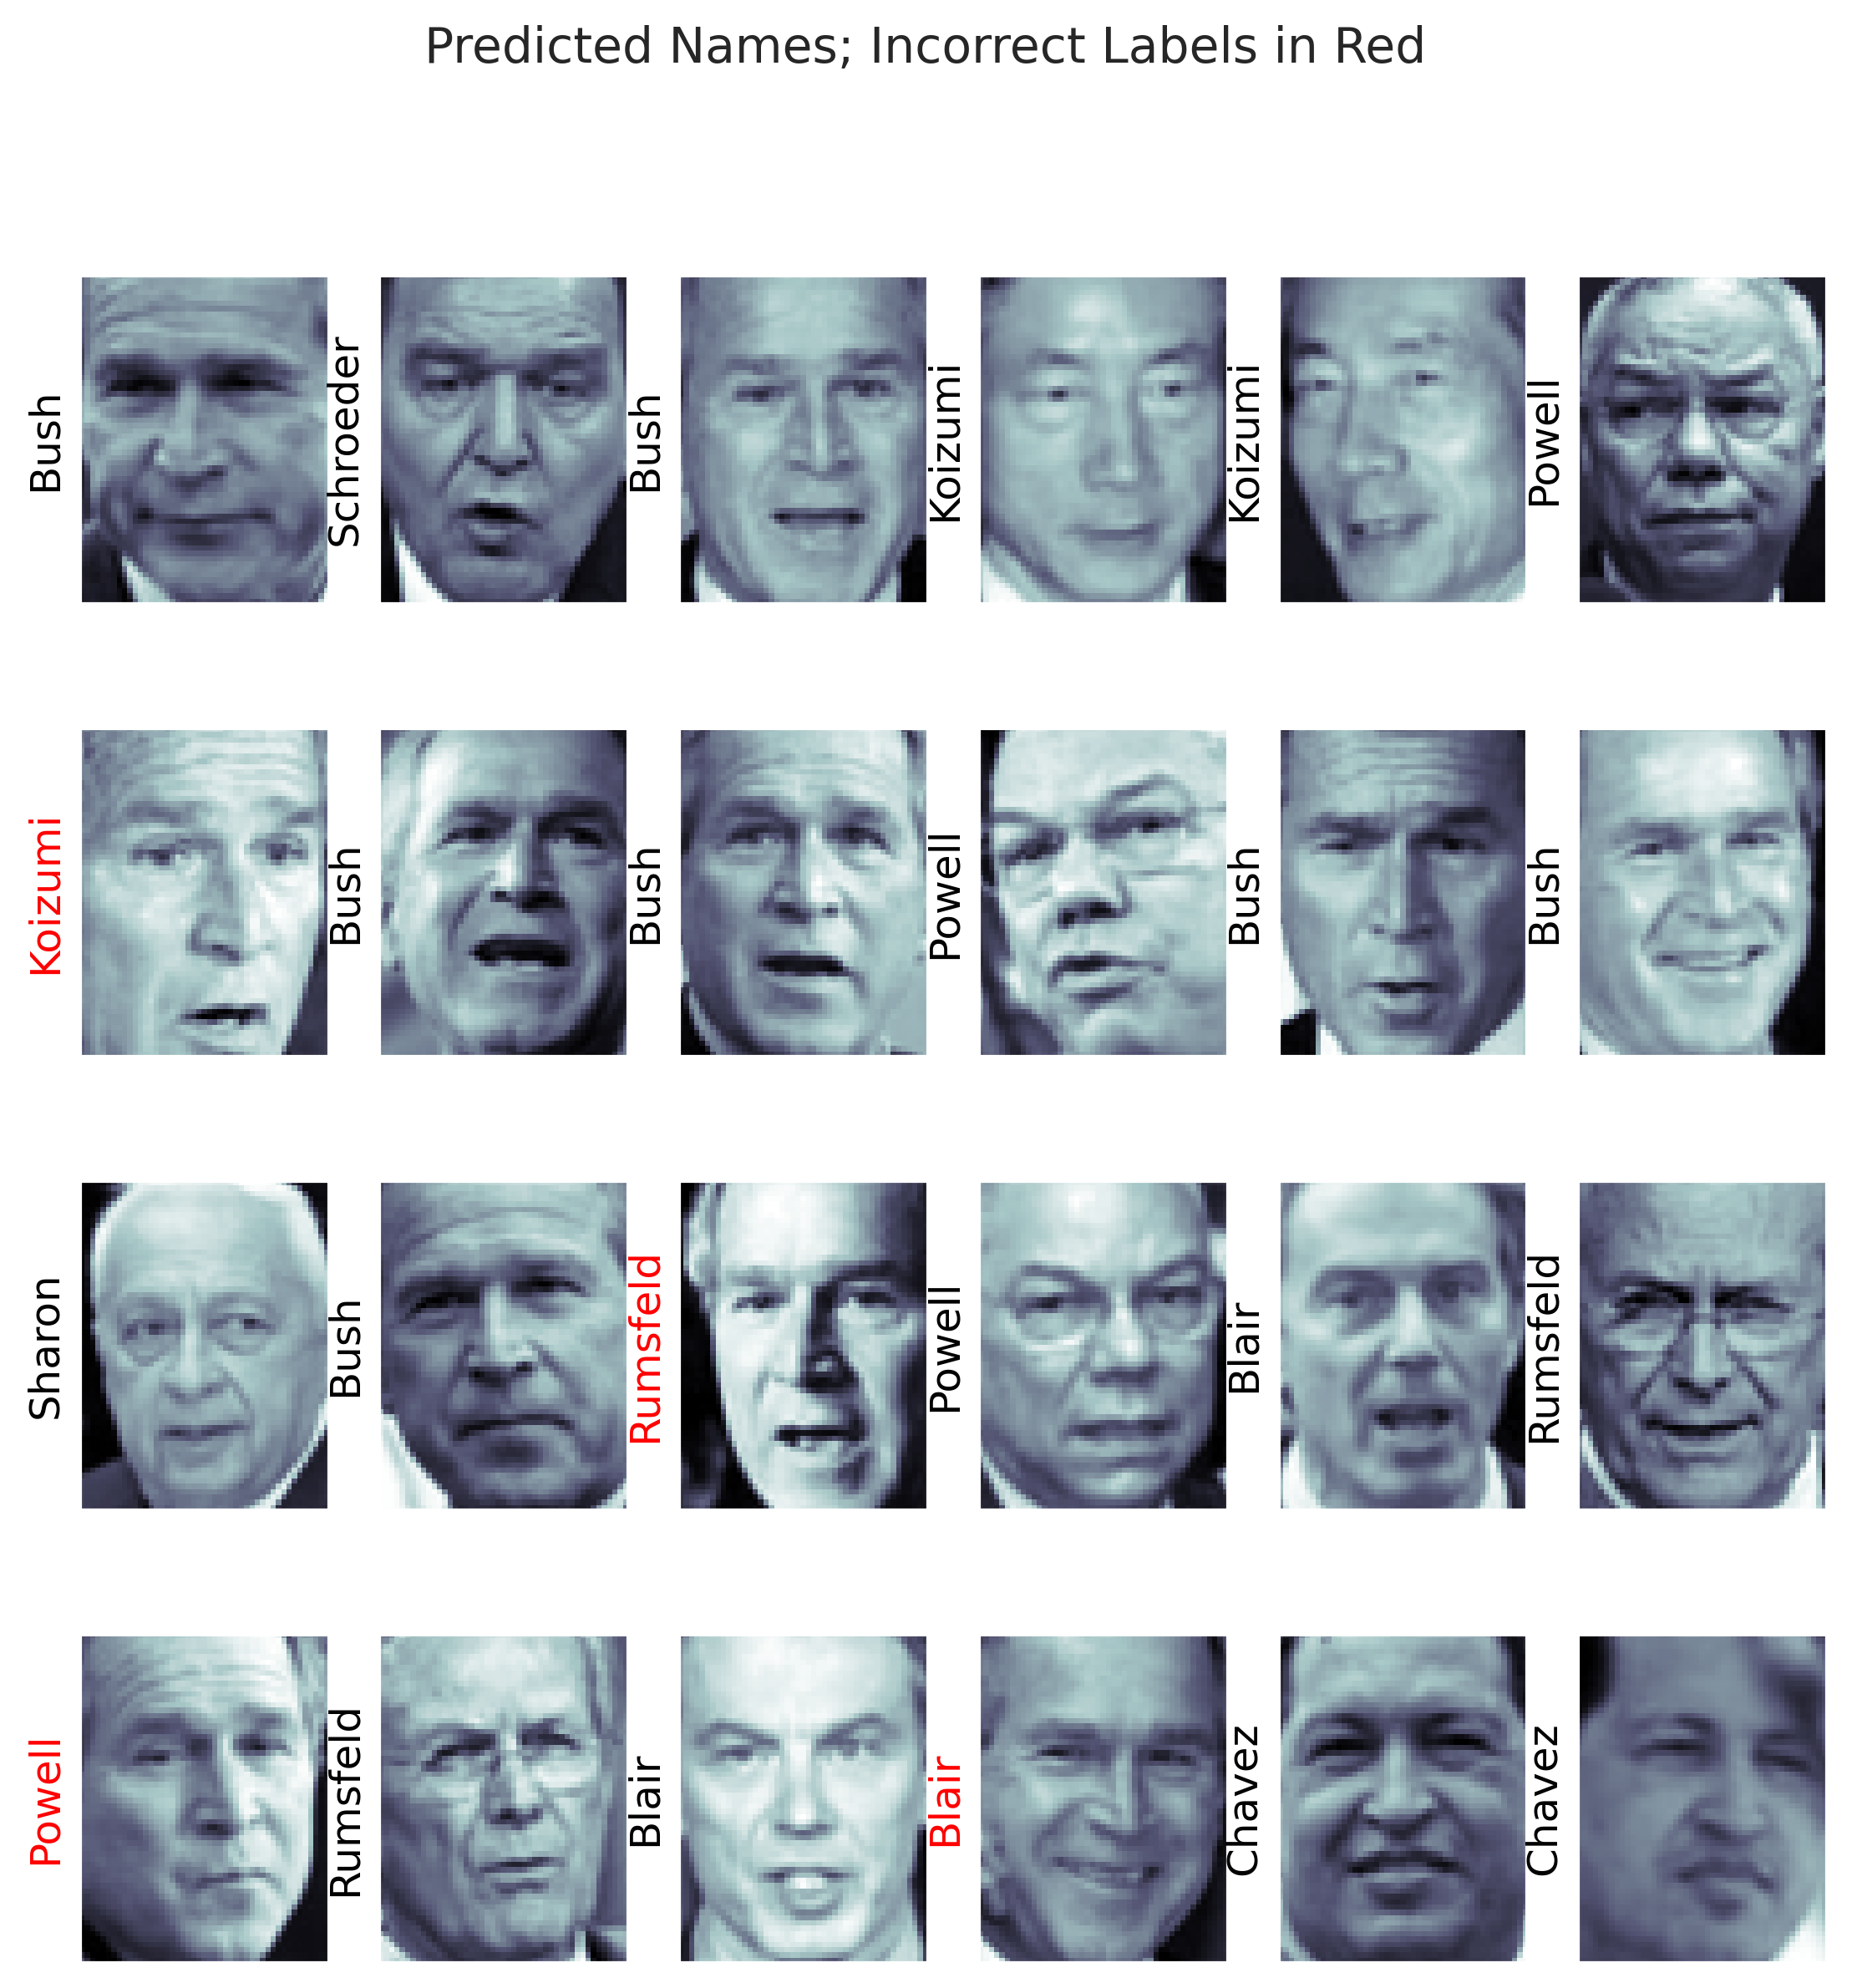

In [48]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

In [49]:
print(classification_report(y_test, y_fit,
                            target_names=faces.target_names))
report = classification_report(y_test, y_fit,
                            target_names=faces.target_names, output_dict=True)
f1_scores['sigmoid'] = report['macro avg']['f1-score']

                   precision    recall  f1-score   support

     Ariel Sharon       0.52      0.80      0.63        15
     Colin Powell       0.83      0.87      0.85        68
  Donald Rumsfeld       0.62      0.81      0.70        31
    George W Bush       0.99      0.73      0.84       126
Gerhard Schroeder       0.66      0.83      0.73        23
      Hugo Chavez       0.82      0.70      0.76        20
Junichiro Koizumi       0.75      1.00      0.86        12
       Tony Blair       0.79      0.90      0.84        42

         accuracy                           0.80       337
        macro avg       0.75      0.83      0.78       337
     weighted avg       0.84      0.80      0.81       337



Выведем средние значения <code>f1-score</code> для четырех ядер

In [50]:
f1_scores

{'linear': 0.7688608143653353,
 'poly': 0.23647783011015885,
 'rbf': 0.8478813971307733,
 'sigmoid': 0.7767526375381957}

Худшие результаты по величине <code>f1-scores</code> дает ядро <code>poly</code>. Далее идут <code>linear</code> и <code>sigmoid</code>. Лучшие результаты дает <code>rbf</code>.

### Задание 2

Воспользуемся **tSNE** (**t-distributed stochastic neighbor embedding**) для визуализации проекций признаков, полученных с помощью метода главных компонент, на двумерную плоскость.

In [51]:
from sklearn.manifold import TSNE

Создаем pipeline из PCA и TSNE

In [52]:
pca = PCA(n_components=150, svd_solver='randomized', whiten=True,
          random_state=42)

tsne = TSNE()

In [53]:
pipeline = make_pipeline(pca, tsne)

In [54]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('tsne', TSNE())])

Получим проекции объектов из обучающей выборки для предыдущего датасета на плоскость

In [55]:
points = pipeline.fit_transform(X_train)

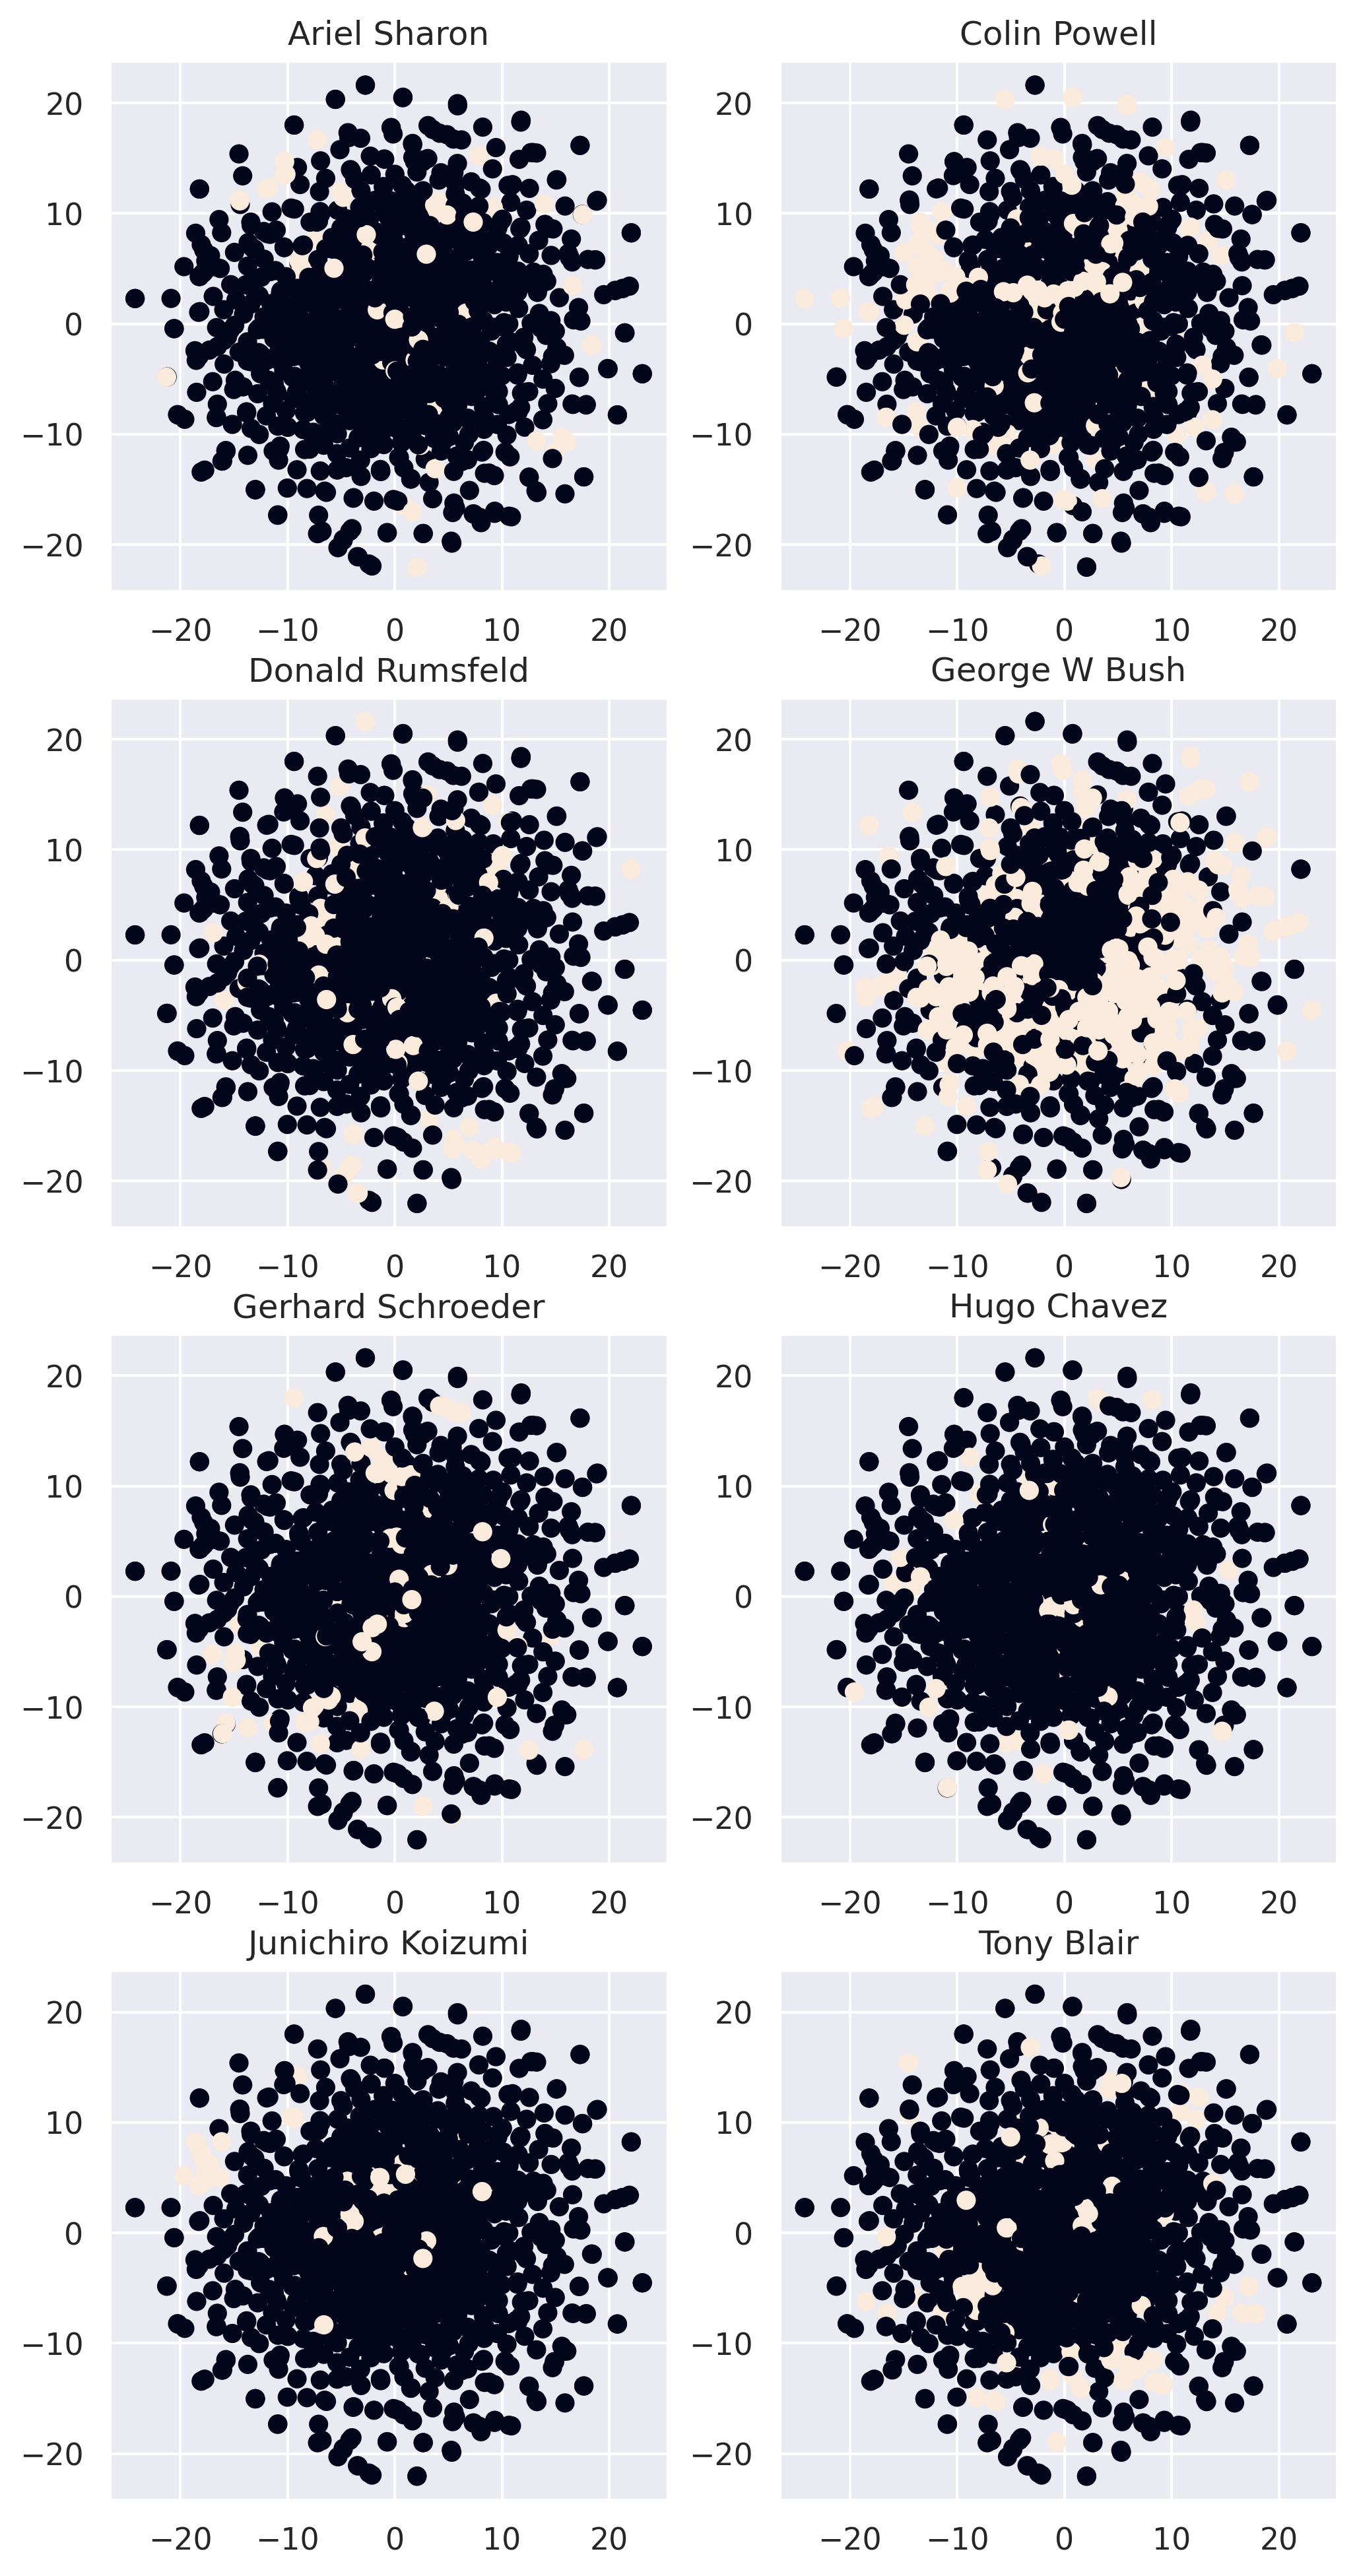

In [56]:
ncols = 2
nrows = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 16))
for i in range(nrows):
    for j in range(ncols):
        index = i * ncols + j
        axes[i][j].scatter(points[:, 0], points[:, 1],
                           c=(y_train == index))
        axes[i][j].set_title(faces.target_names[index])
plt.show()

Как видно, трудно однозначно отделить объекты одного класса от объектов остальных классов.

### Задание 3

Решим задачу распознавания лиц с помощью логистической регрессии (метод <code>LogisticRegression</code> также поддерживает опцию <code>class_weight='balanced'</code>). Посмотрим, какое качество покажет данная модель.

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
lrc = LogisticRegression(class_weight='balanced')

model = make_pipeline(pca, lrc)

In [59]:
from sklearn.model_selection import GridSearchCV
param_grid = {'logisticregression__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 11.7 s, sys: 64.2 ms, total: 11.7 s
Wall time: 2.95 s
{'logisticregression__C': 1}


In [60]:
model = grid.best_estimator_

y_fit = model.predict(X_test)

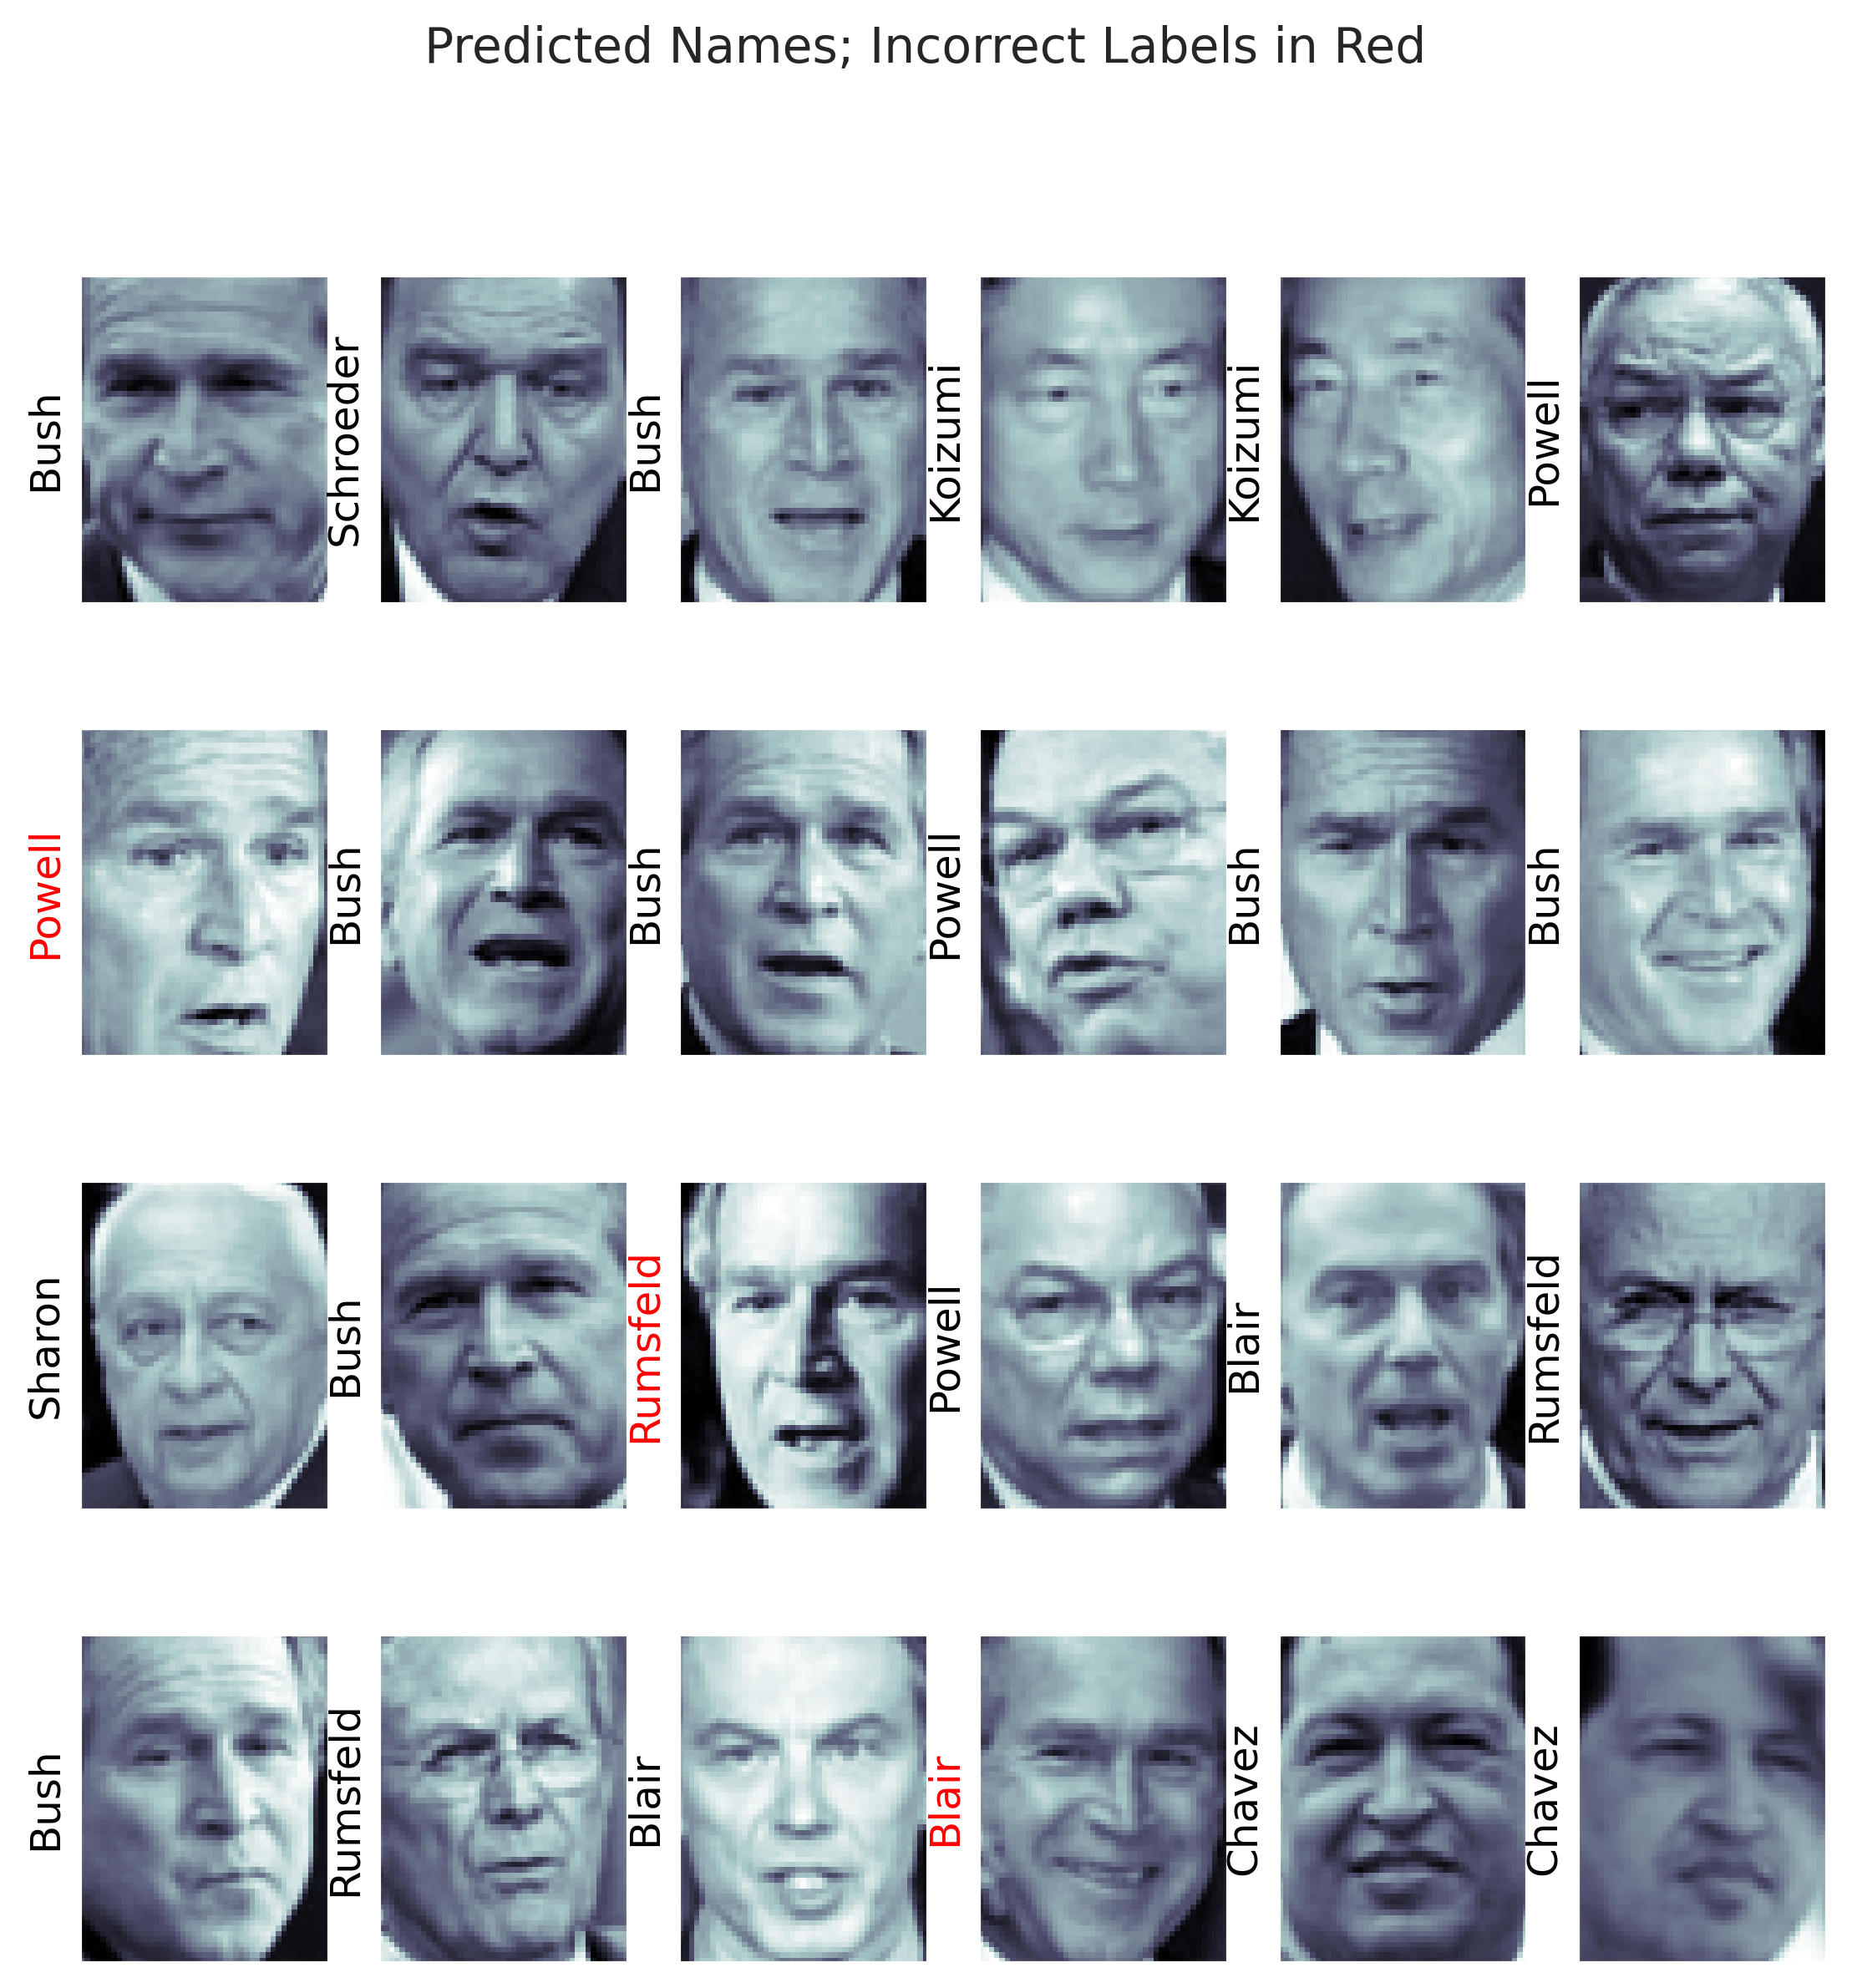

In [61]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                   color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

In [62]:
print(classification_report(y_test, y_fit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.63      0.80      0.71        15
     Colin Powell       0.85      0.88      0.86        68
  Donald Rumsfeld       0.69      0.71      0.70        31
    George W Bush       0.93      0.79      0.85       126
Gerhard Schroeder       0.71      0.74      0.72        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.71      0.93      0.80        42

         accuracy                           0.82       337
        macro avg       0.78      0.82      0.79       337
     weighted avg       0.83      0.82      0.82       337



Логистическая регрессия также относительно успешно справляется с задачей распознавания лиц. Построим <code>confusion_matrix</code>

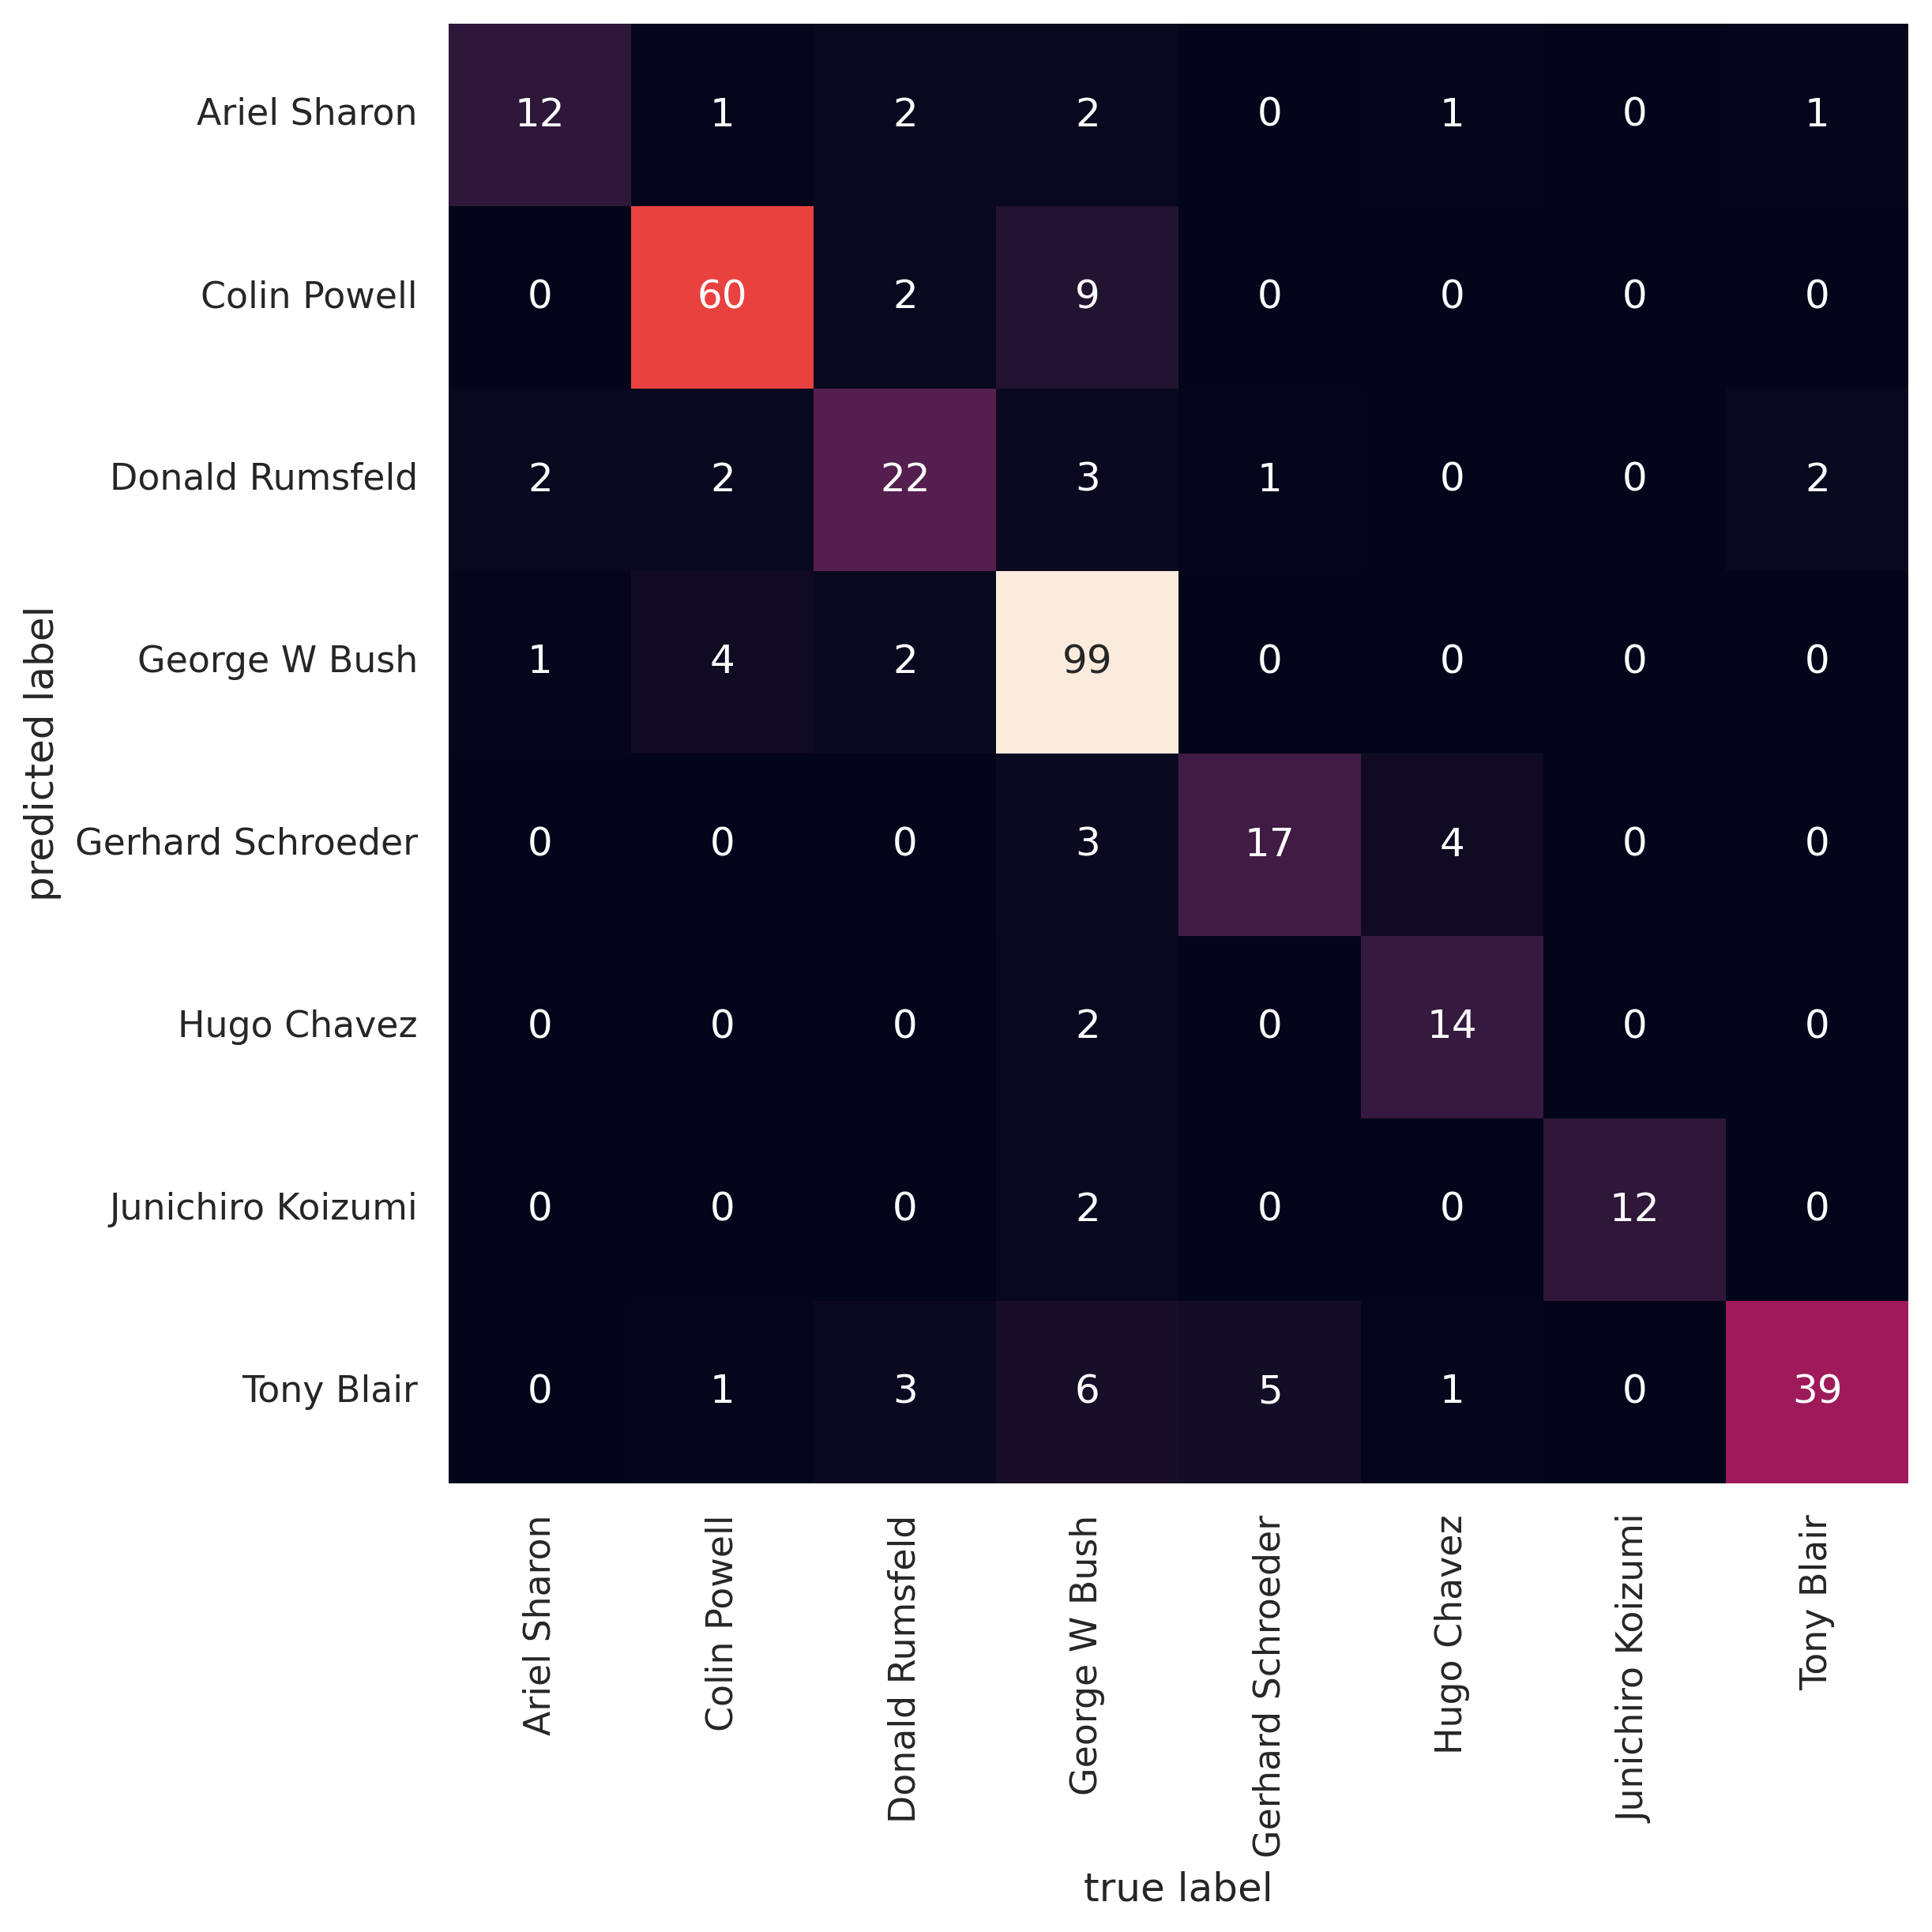

In [63]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Задание 4

Сгенерируем 100 точек для задачи двухклассовой классификации с помощью метода <code>make_moons</code> https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html.

Используем параметр <code>noise=0.1</code>

In [64]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=0.1, random_state=0)

Разобьем датасет на обучающую и валидационную части

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=42)

Изобразим точки на плоскости

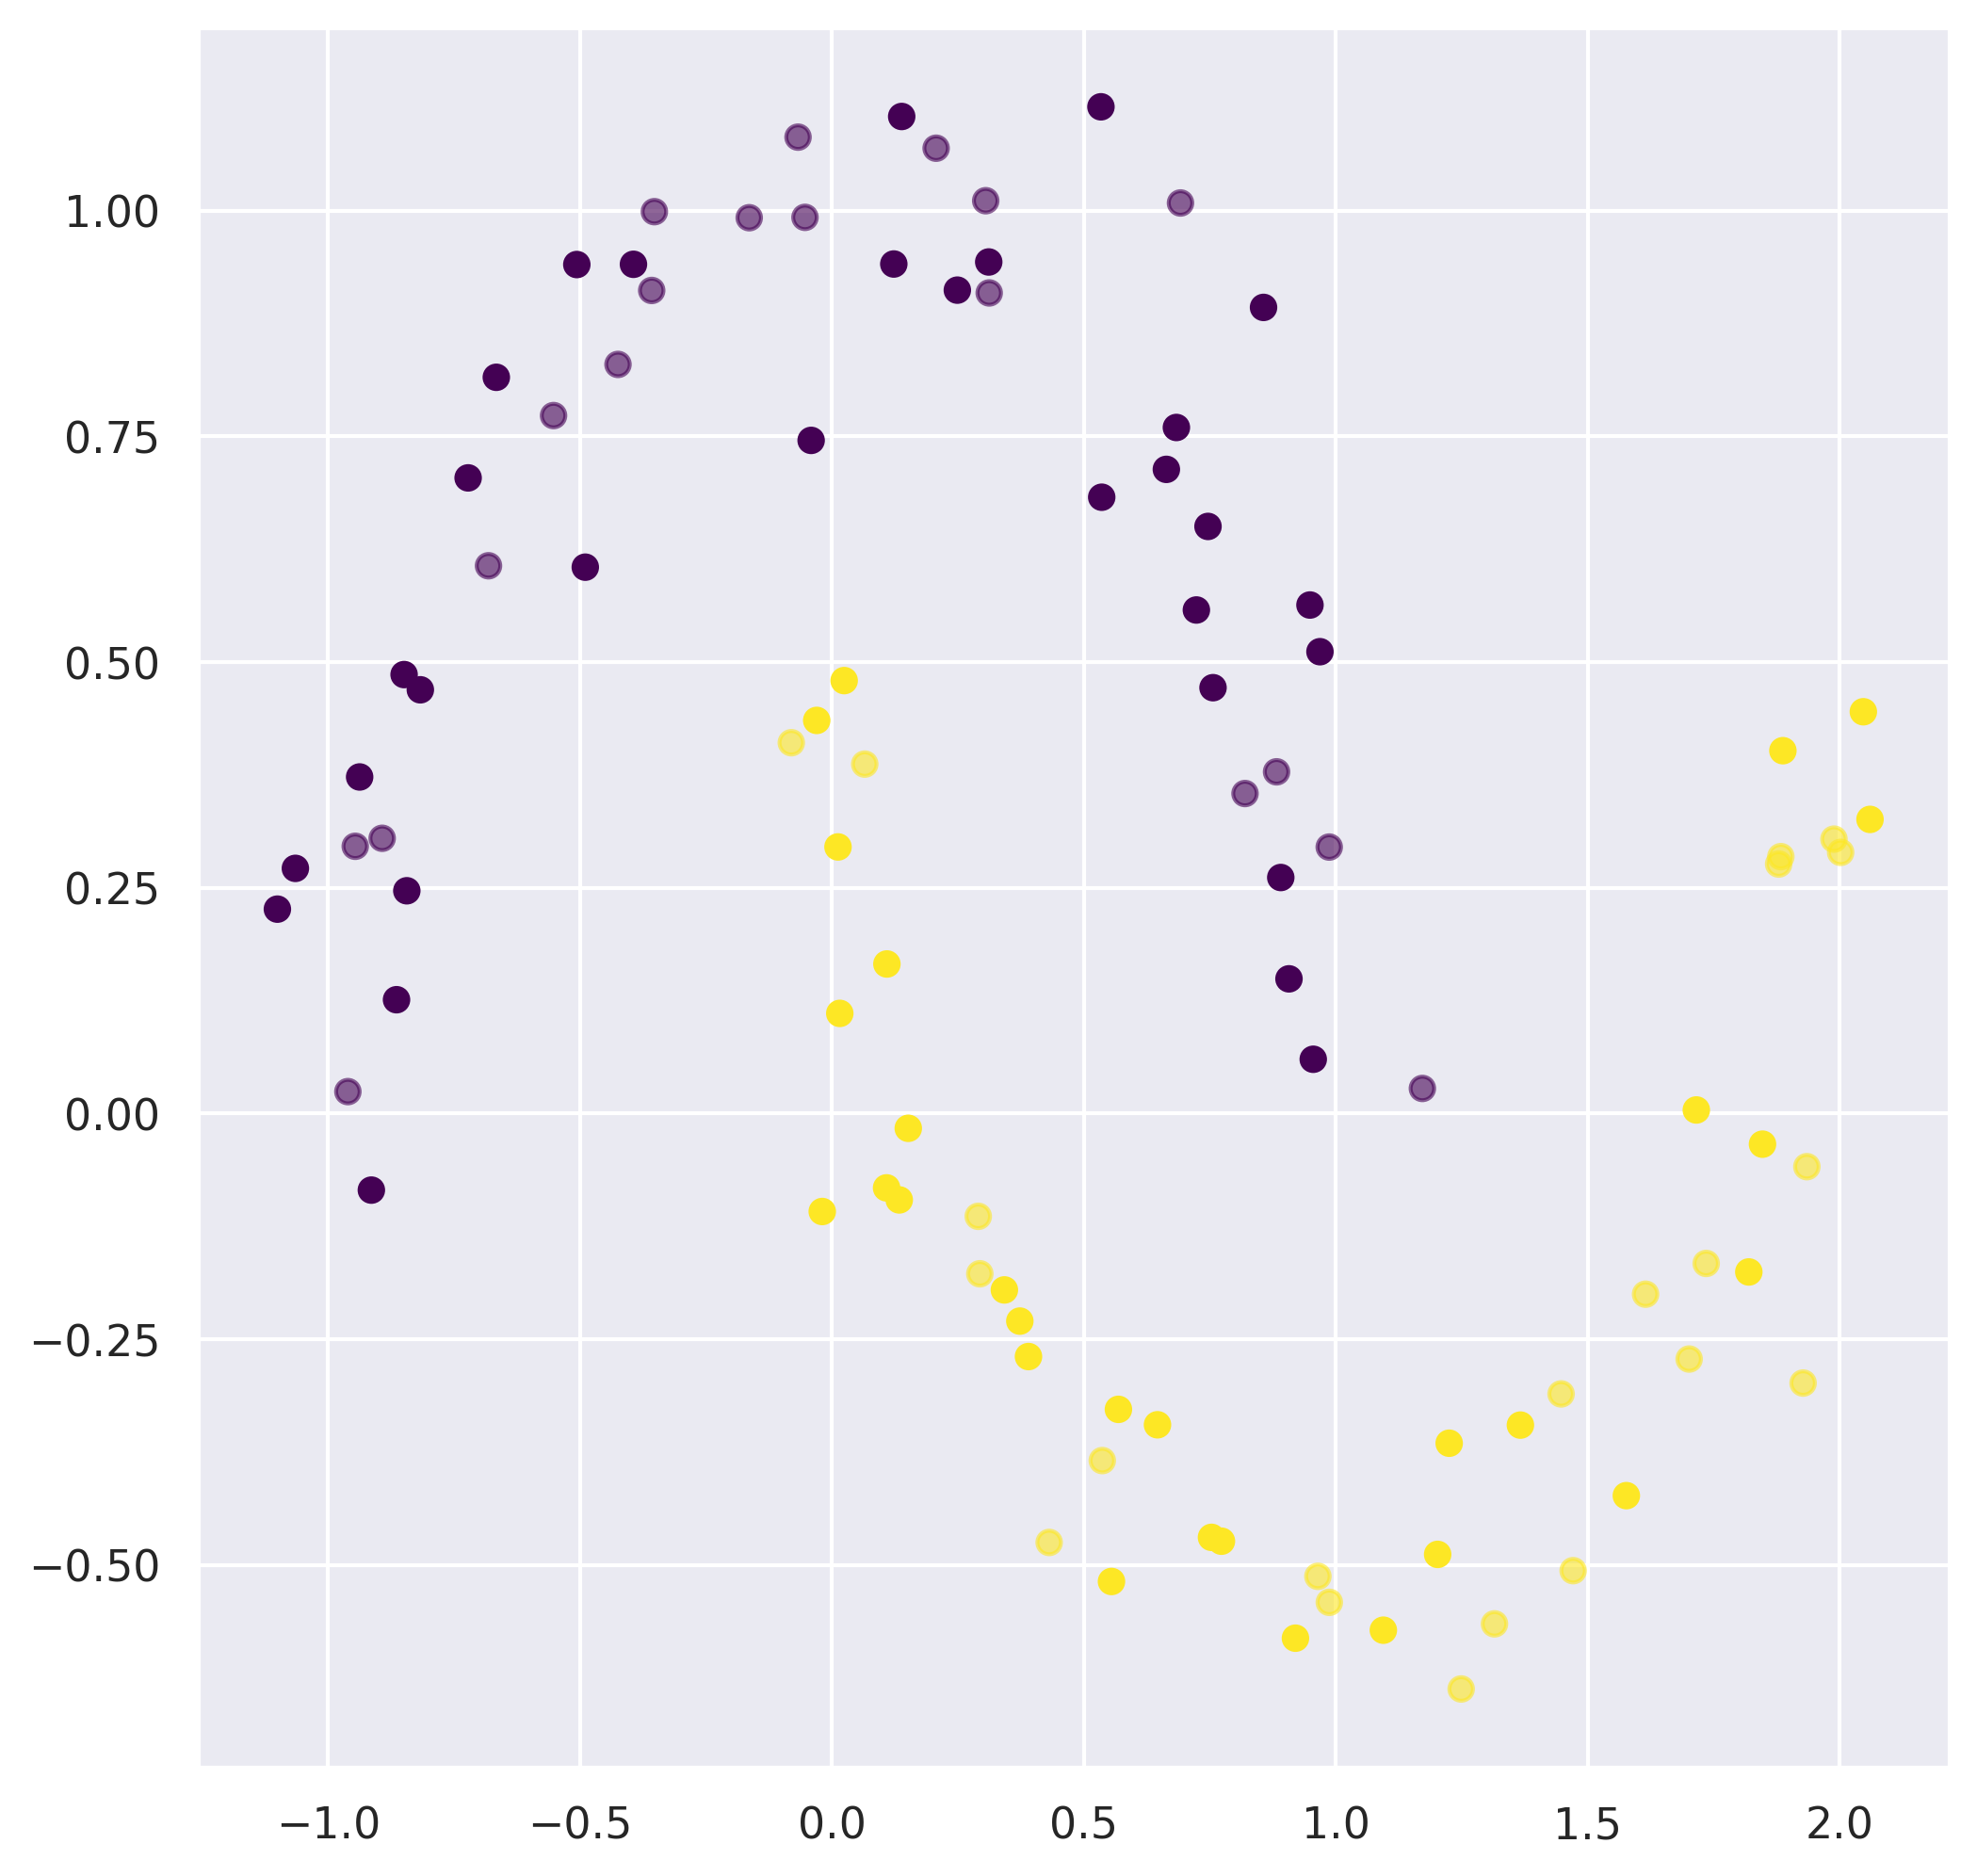

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.6,
           cmap='viridis')
plt.show()

Подберем тип ядра в методе SVM и значение параметра $C$, чтобы добиться (визуально) безошибочной классификации.

Зададим SVM-классификатора без гиперпараметра.

In [67]:
classifiers = [
    SVC(kernel='linear'),
    SVC(kernel='poly', gamma=2),
    SVC(kernel='rbf'),
    SVC(kernel='sigmoid')
]

classifier_names = ['SVC linear', 'SVC poly', 'SVC rbf', 'SVC sigmoid']

Найдем наилучшую модель для каждого классификатора, перебирая гиперпараметр с помощью <code>GridSearchCV</code>. Применим <code>StandardScaler</code> к классификатору с подобранным гиперпараметром для обучения модели. На валидационной выборке найдем величину <code>score</code>, которая позволит нам оценить качество обучения модели.

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
from sklearn.inspection import DecisionBoundaryDisplay

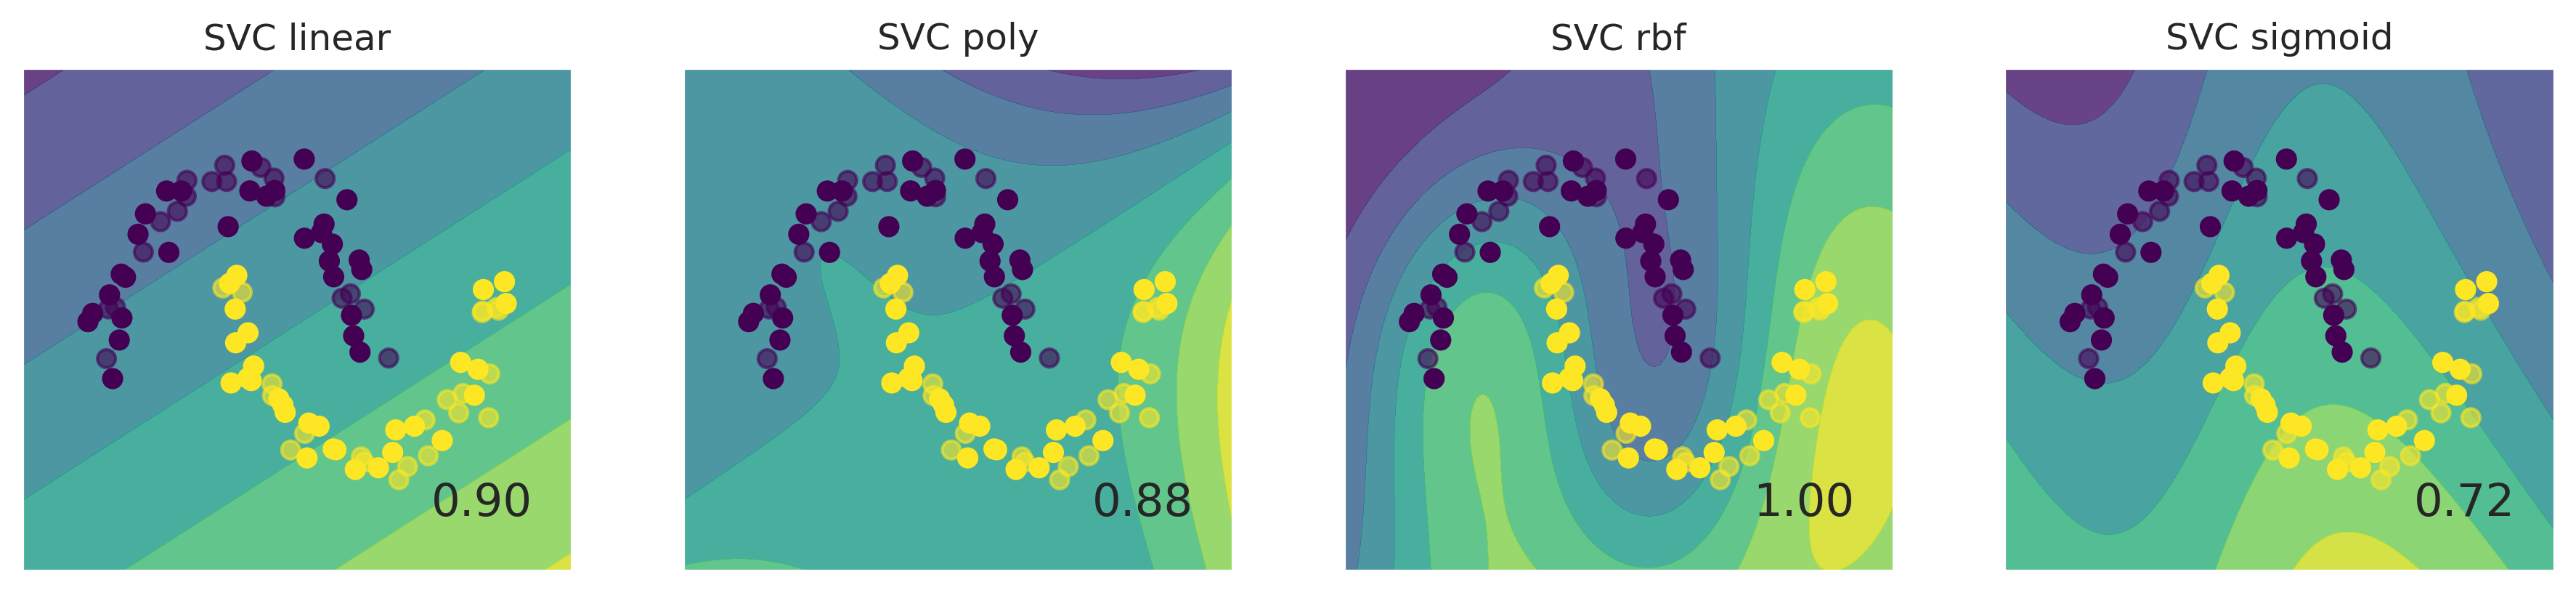

In [70]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

for i, clf in enumerate(classifiers):
    param_grid = {'C': [1, 5, 10, 50]}
    grid = GridSearchCV(clf, param_grid)
    grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_
    pipeline = make_pipeline(StandardScaler(), best_clf)
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(best_clf, X,
                                           cmap='viridis',
                                           alpha=0.8, ax=axes[i],
                                           eps=0.5)
    axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                    cmap='viridis')
    axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.6,
                    cmap='viridis')
    axes[i].set_title(classifier_names[i], size=12)
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)
    axes[i].set_xticks(())
    axes[i].set_yticks(())
    axes[i].text(
            x_max - 0.3,
            y_min + 0.3,
            '{:.2f}'.format(score),
            size=15,
            horizontalalignment='right')
plt.show()

Анализируя визуальные результаты классификации и величину <code>score</code>, можно сделать вывод, что лучше всего справился **SVC с rbf-ядром**.

### Калибровка вероятностей

https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

In [71]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve

In [72]:
X, y = make_classification(n_samples=1000, n_classes=2,
                           weights=[1, 1], random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=2)

In [73]:
model = SVC()
model.fit(X_train, y_train)

SVC()

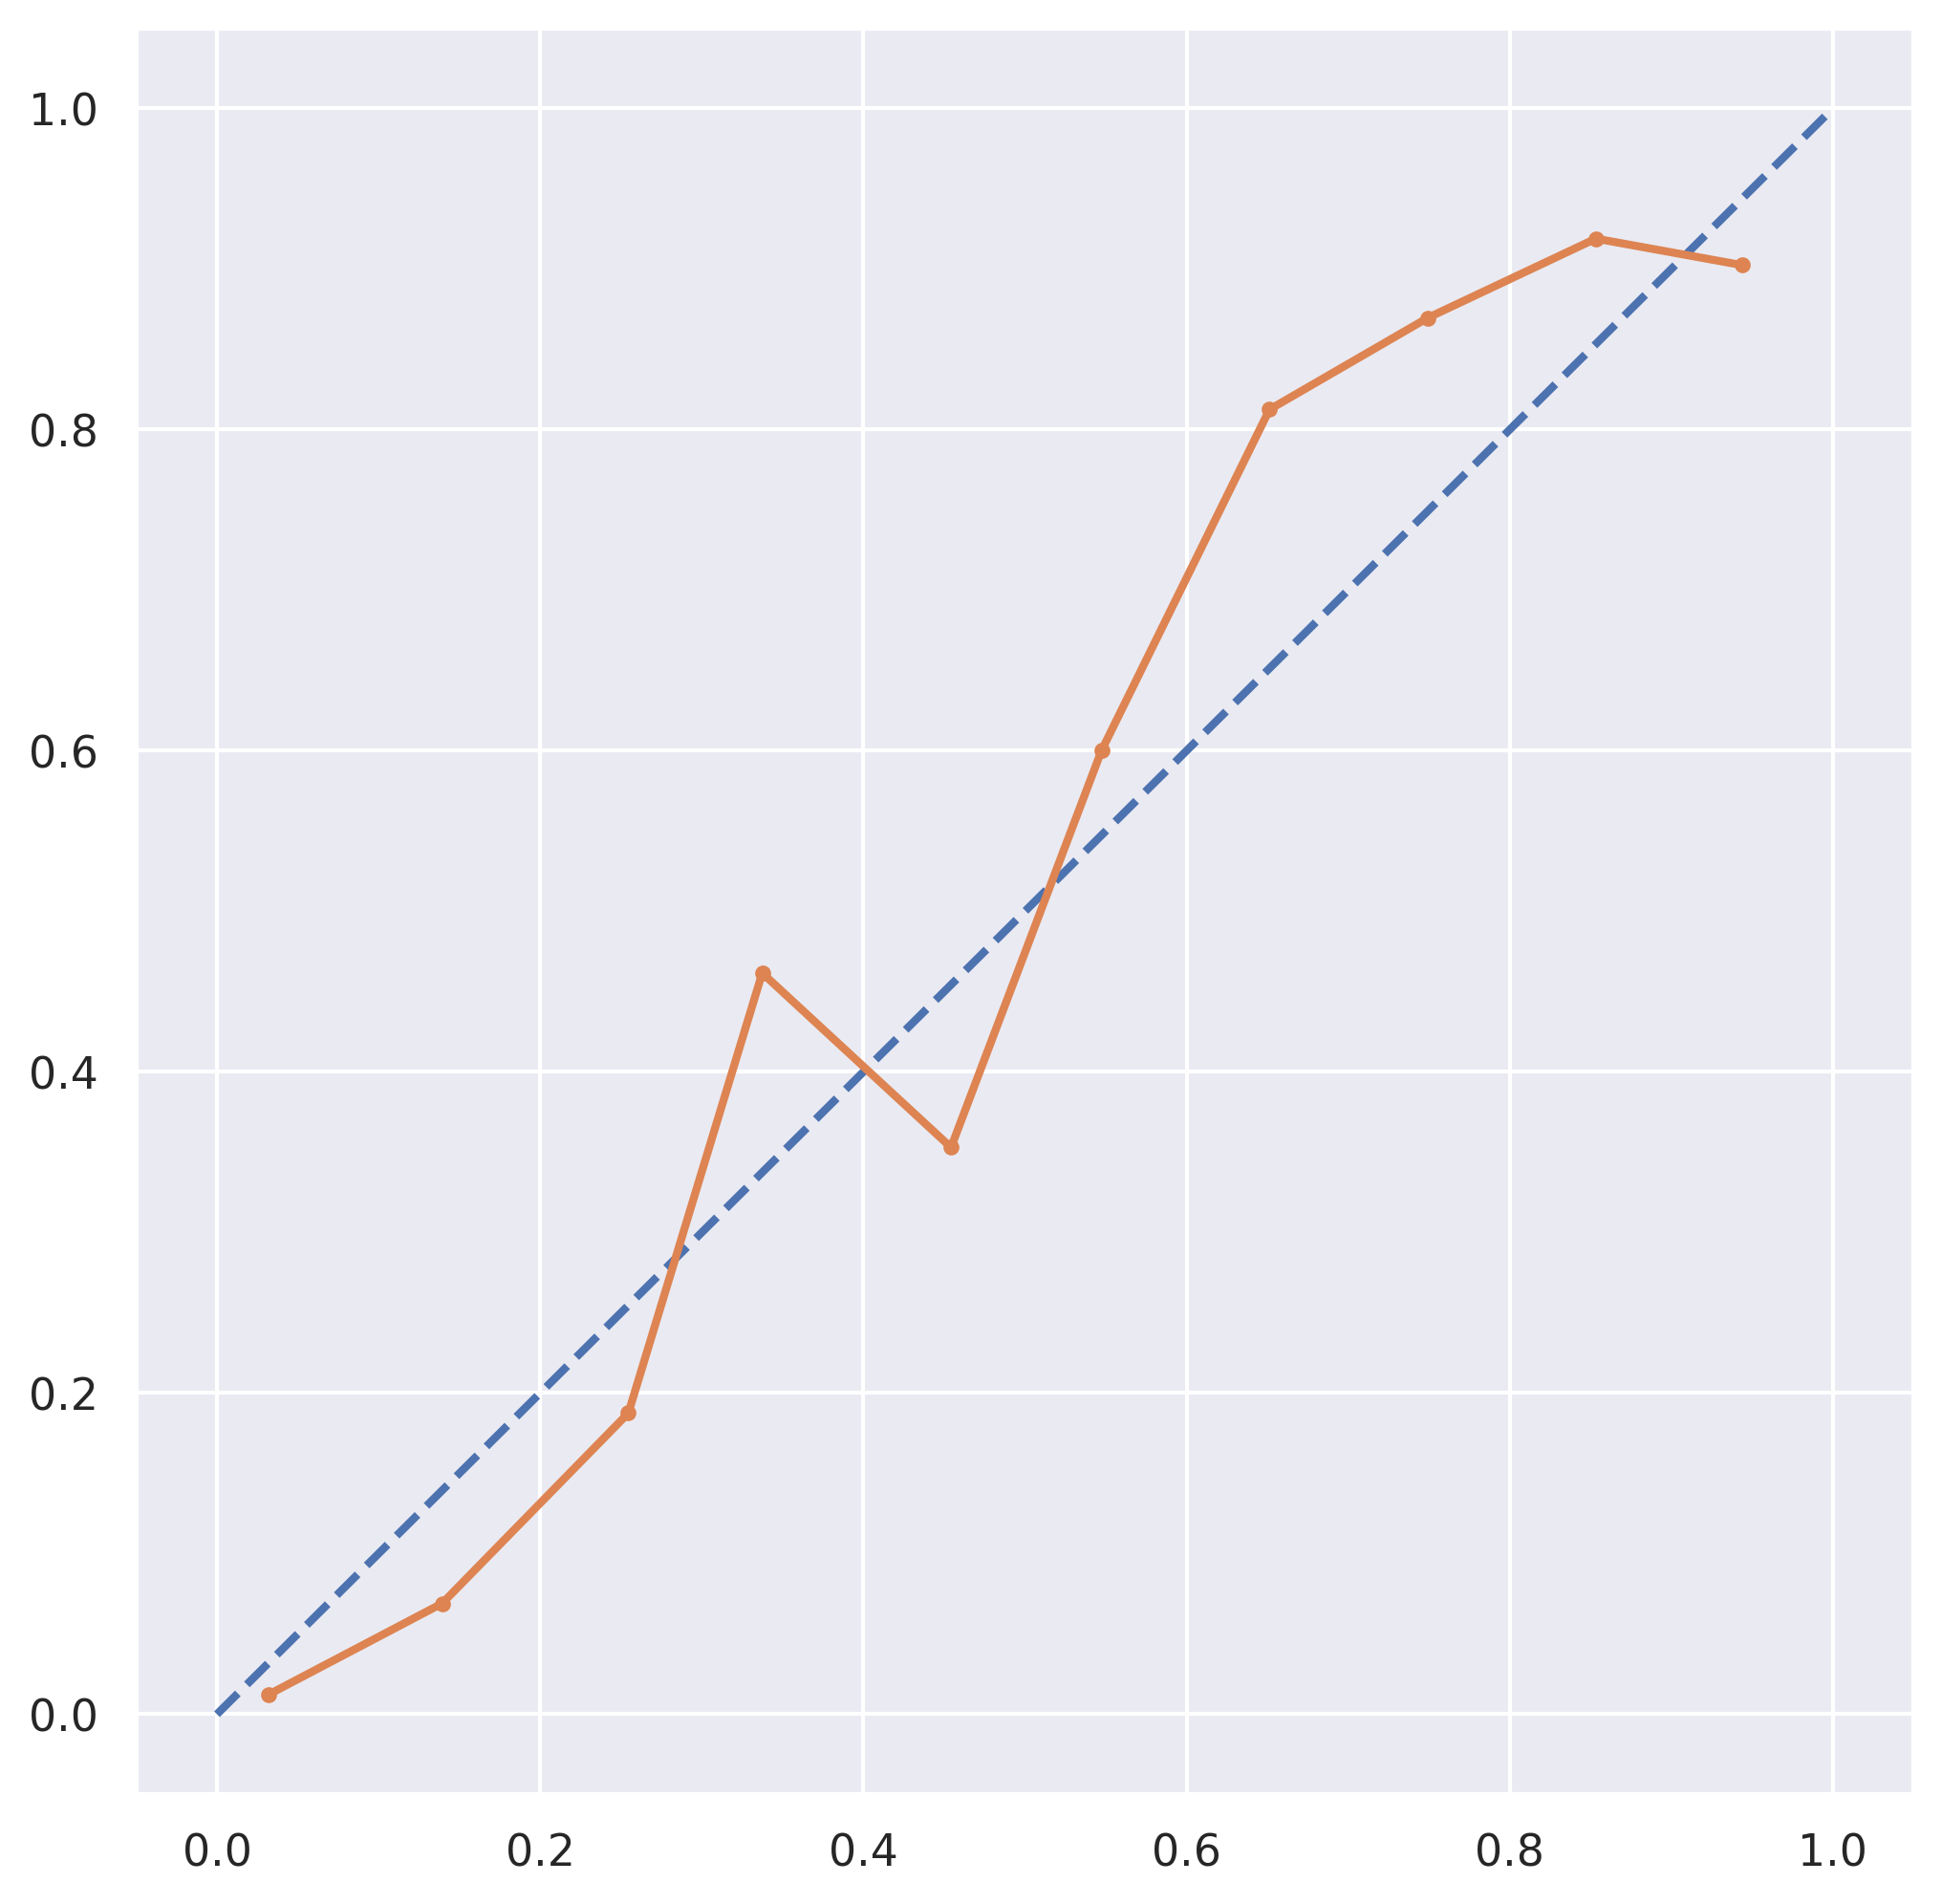

In [74]:
from sklearn.calibration import CalibratedClassifierCV

model = SVC()
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

probs = calibrated.predict_proba(X_test)[:, 1]

fop, mpv = calibration_curve(y_test, probs, n_bins=10)

fig. ax = plt.subplots(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2.0)
plt.plot(mpv, fop, marker='.', lw=2.0)
plt.show()

**Задание 5**

Заново решите задачу классификации точек, сгенерированных с помощью метода <code>make_moons</code>.

1) Разбейте данные на train и test. Обучите SVM на train и сделайте предсказание вероятностей на test.
Представьте результат с помощью <code>calibration_curve</code>.

2) Затем откалибруйте предсказания классификатора и нарисуйте полученную calibration curve.

In [75]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=0.1, random_state=0)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=42)

In [77]:
from sklearn.preprocessing import StandardScaler

In [78]:
from sklearn.inspection import DecisionBoundaryDisplay

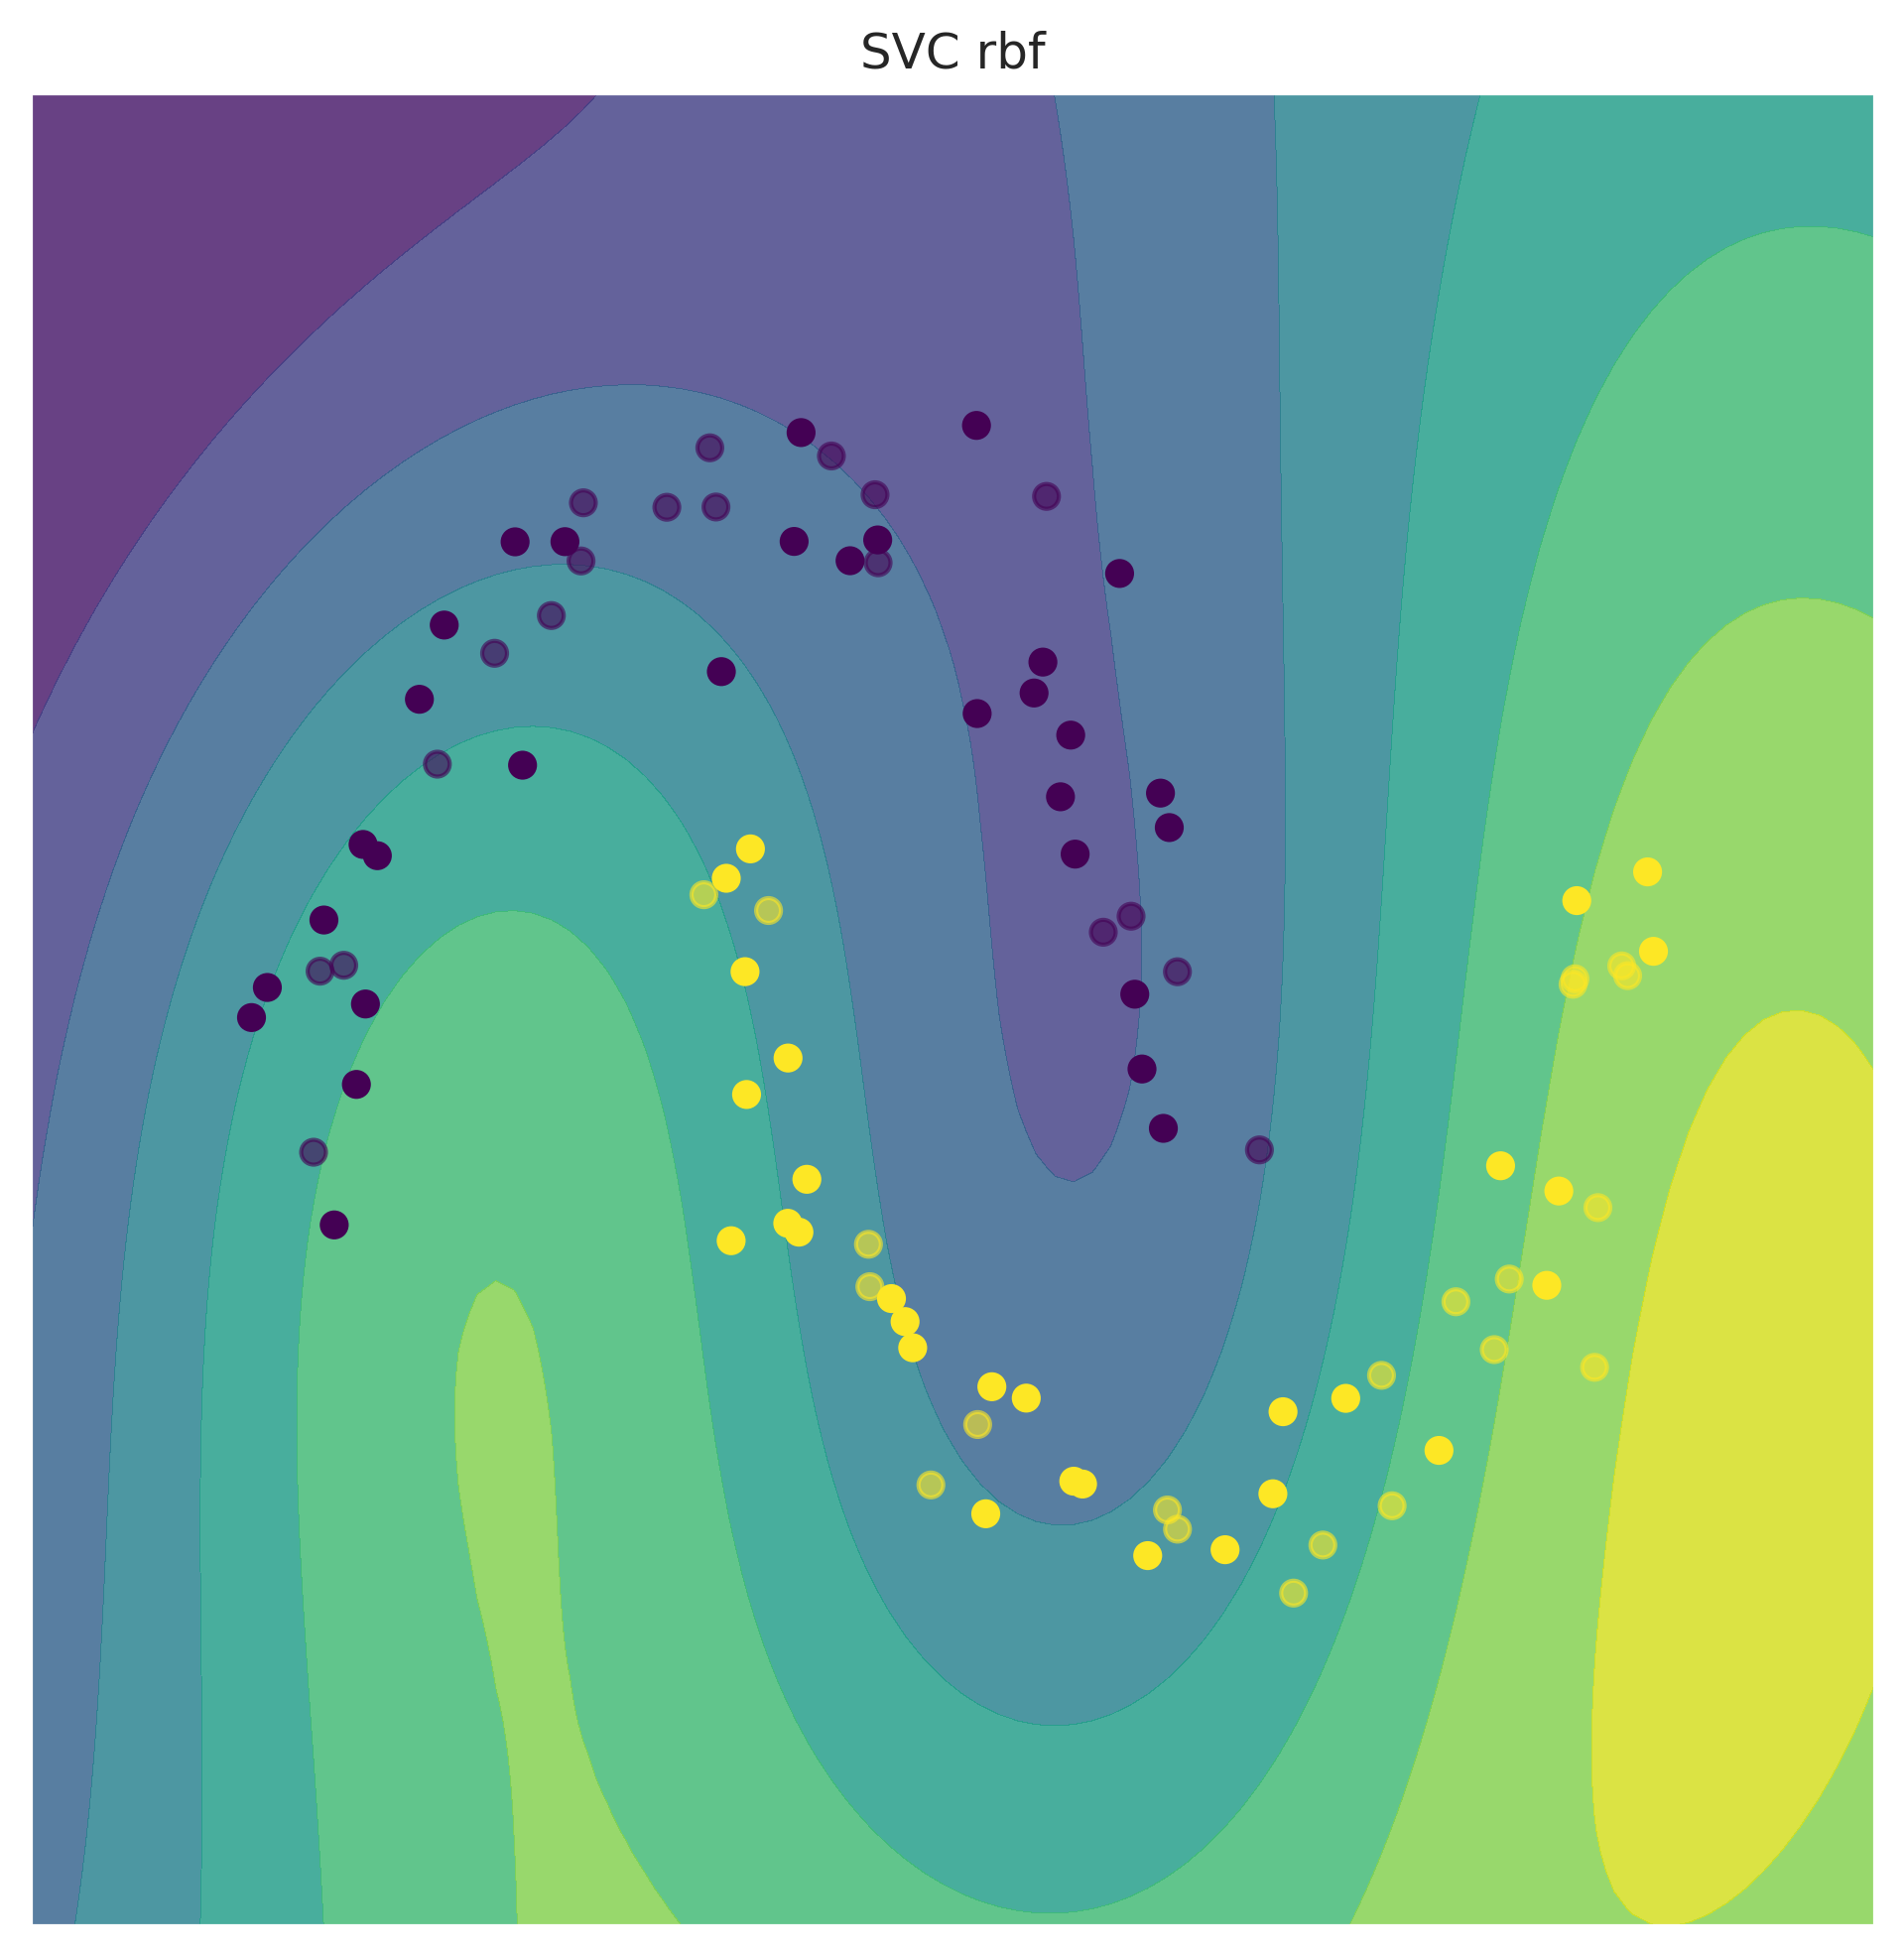

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

clf = SVC(kernel='rbf')
param_grid = {'C': [1, 5, 10, 50]}
grid = GridSearchCV(clf, param_grid)
grid.fit(X_train, y_train)
best_clf = grid.best_estimator_
pipeline = make_pipeline(StandardScaler(), best_clf)
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
DecisionBoundaryDisplay.from_estimator(best_clf, X,
                                       cmap='viridis',
                                       alpha=0.8, ax=ax,
                                       eps=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
           cmap='viridis')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.6,
           cmap='viridis')
ax.set_title('SVC rbf', size=12)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

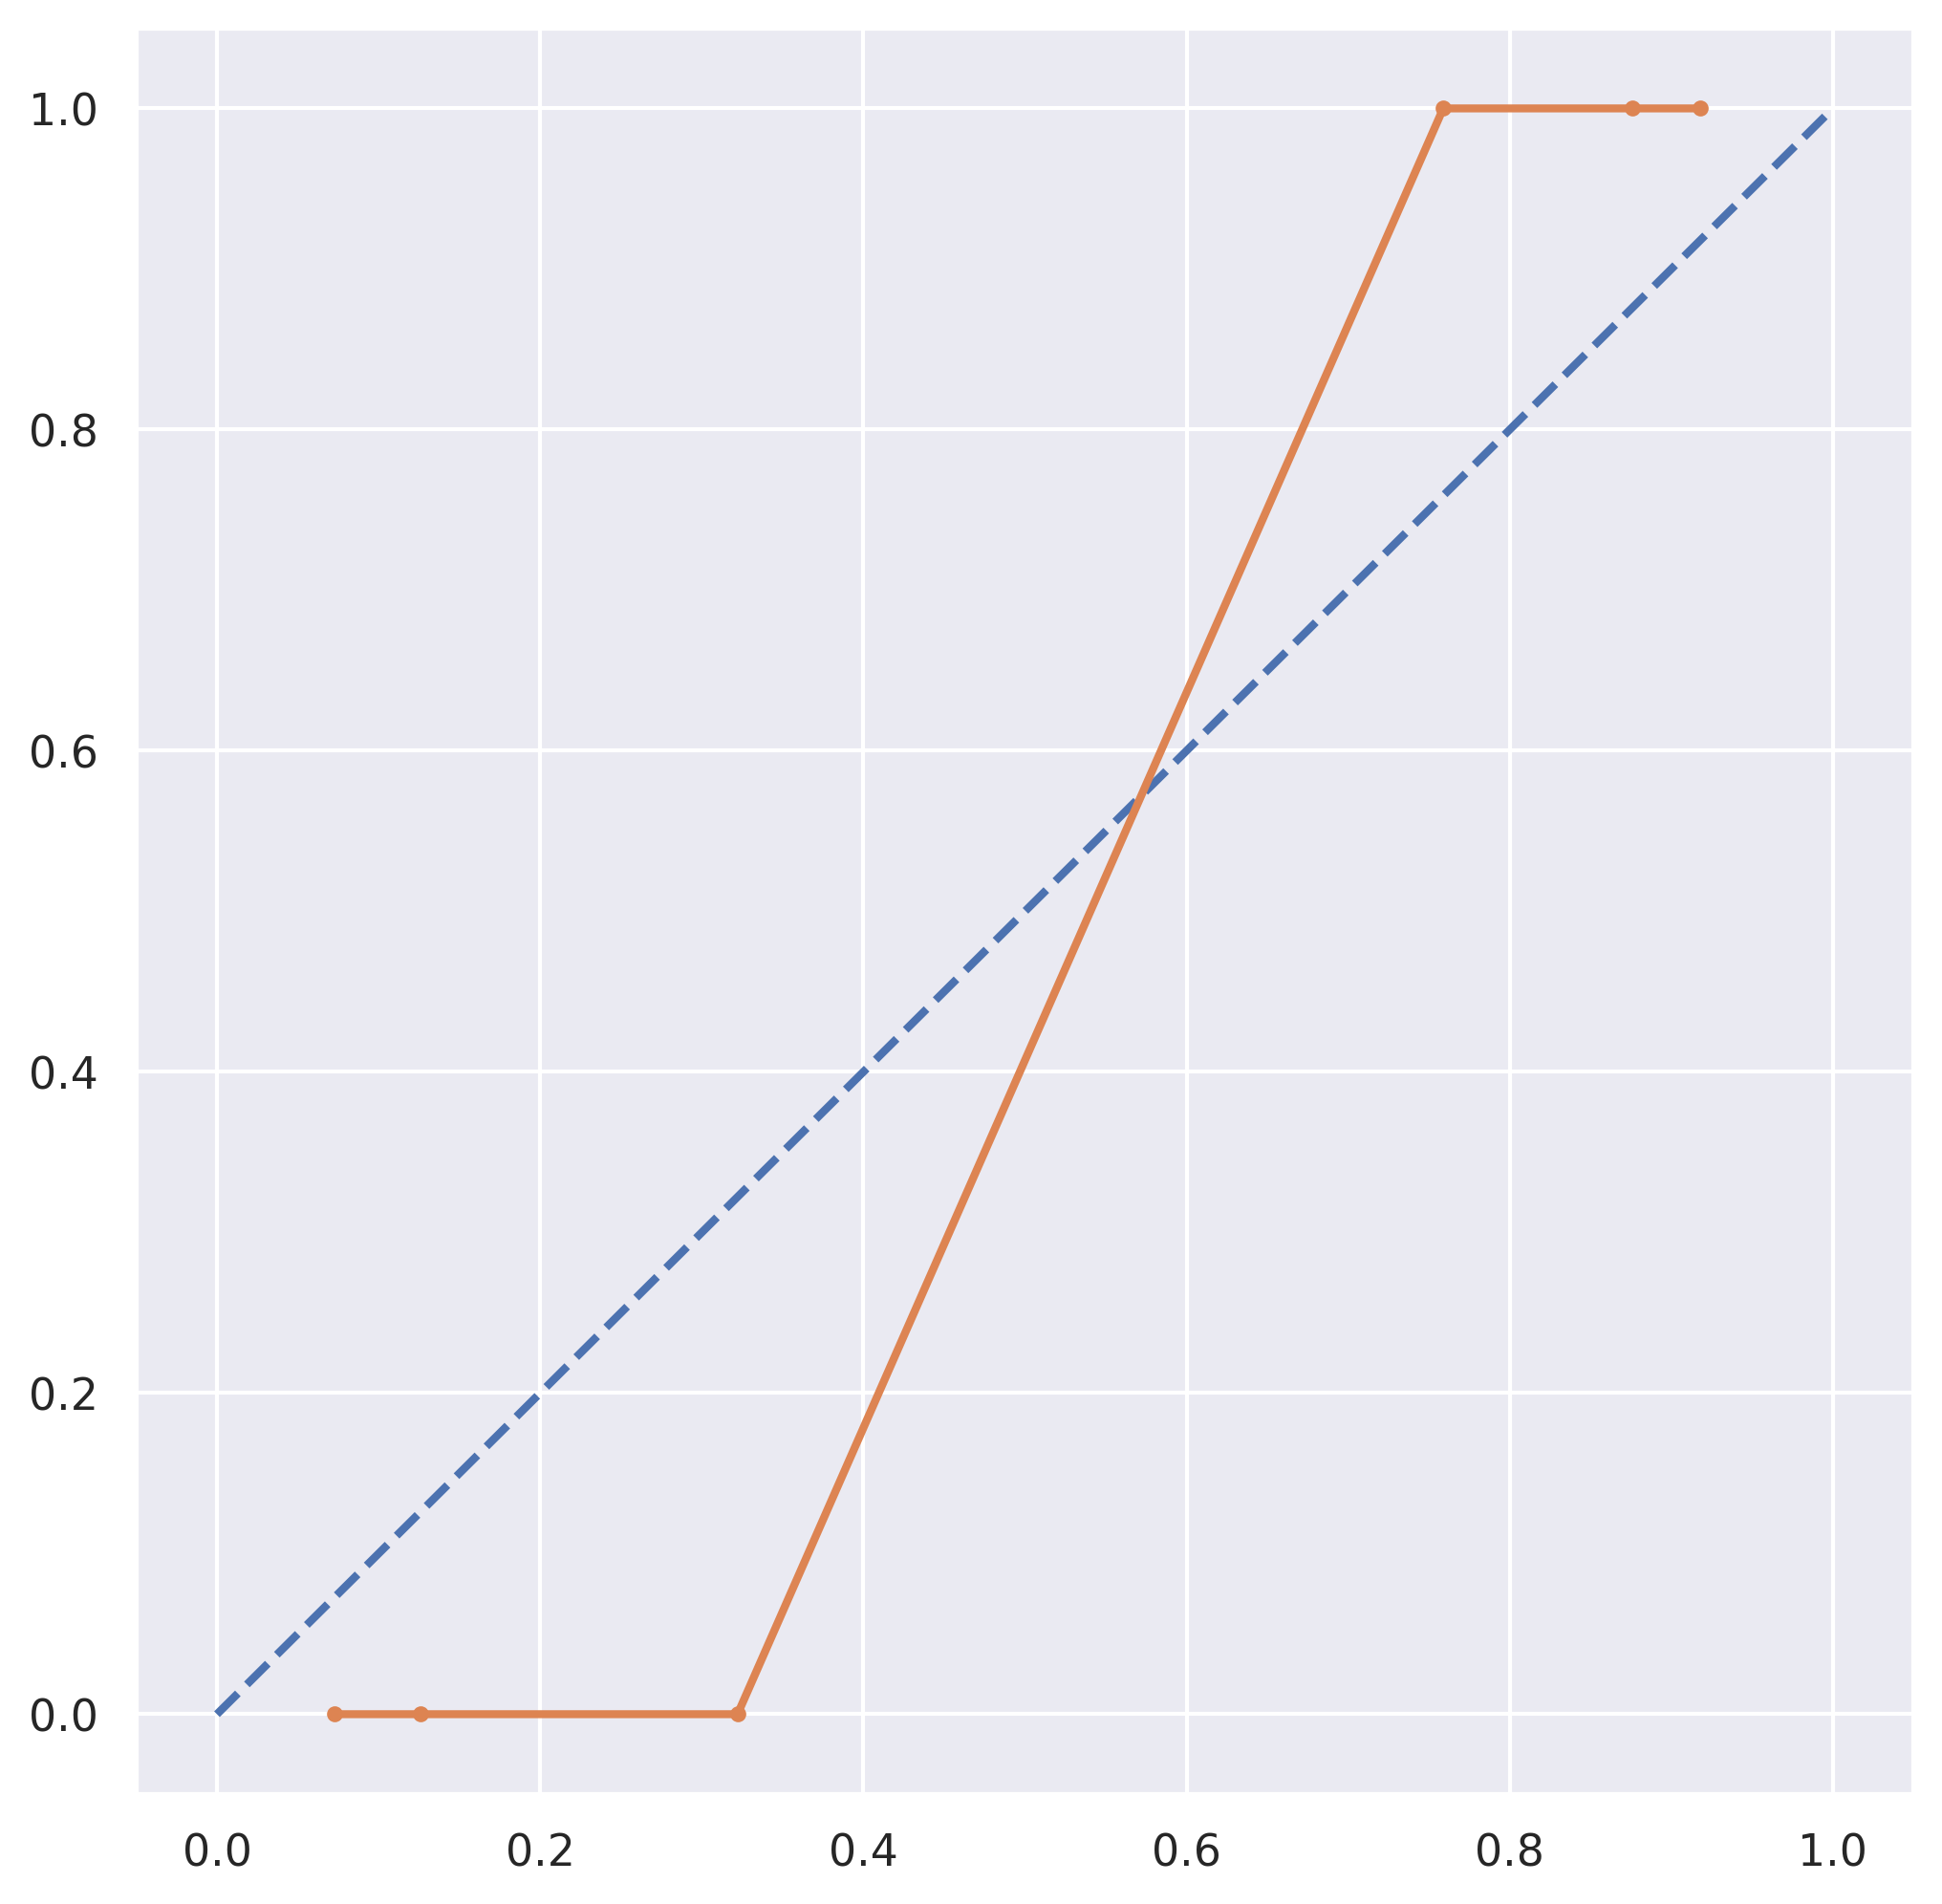

In [80]:
calibrated = CalibratedClassifierCV(pipeline, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

probs = calibrated.predict_proba(X_test)[:, 1]

fop, mpv = calibration_curve(y_test, probs, n_bins=10)

fig. ax = plt.subplots(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2.0)
plt.plot(mpv, fop, marker='.', lw=2.0)
plt.show()